In [ ]:
# ResNet18 + MobileNetV2 + EfficientNetB0 /// 224 380 336
# folcalloss is good for fer2013

!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install psutil
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [1]:
# Revised Code based on NEW_CODEx.txt and recommendations
# Version 3.2 (Handling specific Test directory structure)

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Average
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from datetime import datetime
import math
import glob # Needed for finding files

# =============================================================================
# Configuration Dictionary
# =============================================================================
CONFIG = {
    "SEED": 42,
    "BASE_DATA_DIR": "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net", # Base path
    "TRAIN_DIR": "Train", # Combined train dir name
    "TEST_DIR": "Test",   # Base test dir name
    "IMG_SIZE": 112, # 112= accuracy 0.56 / 224= accuracy 0.49 / 380=x / 336=x
    "BATCH_SIZE": 64, # 64 / 128
    "BUFFER_SIZE": tf.data.AUTOTUNE,
    "EPOCHS_HEAD": 30, # 15
    "EPOCHS_FINE_TUNE": 60, # 30
    "LR_HEAD": 1e-3,
    "LR_FINE_TUNE_START": 1e-4,
    "DROPOUT_RATE": 0.4,
    "NUM_CLASSES": 8, 
    "MODEL_ARCH_1": "EfficientNetB0",
    "MODEL_ARCH_2": "EfficientNetB4",
    "ENSEMBLE_WEIGHTS": [0.7, 0.3], # 50/50 80/20 -- 70/30
    "FINE_TUNE_LAYERS_B0": 10,
    "FINE_TUNE_LAYERS_B4": 15,
    "LOG_DIR_BASE": "logs/fit/"
}

# Set Seed
tf.random.set_seed(CONFIG["SEED"])
np.random.seed(CONFIG["SEED"])

# =============================================================================
# GPU Configuration & Mixed Precision (Same as before)
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")
else:
    print("No GPU detected. Running on CPU.")

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)
print("Mixed precision enabled ('mixed_float16')")

# =============================================================================
# Data Loading (Train/Validation - Standard; Test - Custom)
# =============================================================================

def create_train_val_tf_dataset(directory, image_size, batch_size, validation_split=0.2):
    """Creates tf.data.Dataset for training and validation using image_dataset_from_directory."""
    print(f"Loading training/validation data from: {directory}")

    # Create the training dataset
    train_ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        image_size=(image_size, image_size),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True,
        seed=CONFIG["SEED"],
        validation_split=validation_split,
        subset="training",
    )

    # Create the validation dataset
    val_ds = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        image_size=(image_size, image_size),
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=False, # No need to shuffle validation
        seed=CONFIG["SEED"],
        validation_split=validation_split,
        subset="validation",
    )

    # Get class names from the training dataset BEFORE optimization
    class_names = train_ds.class_names
    print(f"Dataset loaded with classes: {class_names}")

    # Configure performance for both datasets
    train_ds = train_ds.cache().prefetch(buffer_size=CONFIG["BUFFER_SIZE"])
    val_ds = val_ds.cache().prefetch(buffer_size=CONFIG["BUFFER_SIZE"])

    return train_ds, val_ds, class_names

# --- NEW: Function to load test data from the specific structure ---
def create_test_dataset_from_structure(base_test_dir, target_dataset, class_names_map, image_size, batch_size):
    """
    Creates a tf.data.Dataset for testing by manually finding files in the Test/<emotion>/<target_dataset> structure.
    """
    print(f"Loading test data for '{target_dataset}' from: {base_test_dir}")
    all_image_paths = []
    all_labels = []

    # Get emotion directories (e.g., 'anger', 'happy')
    emotion_dirs = [d for d in tf.io.gfile.listdir(base_test_dir) if tf.io.gfile.isdir(os.path.join(base_test_dir, d))]
    if not emotion_dirs:
         print(f"Warning: No subdirectories found in {base_test_dir}. Cannot load test data.")
         return None

    print(f"Found emotion folders: {emotion_dirs}")

    for emotion in emotion_dirs:
        if emotion not in class_names_map:
            print(f"Warning: Emotion directory '{emotion}' not found in training class names map. Skipping.")
            continue

        label_index = class_names_map[emotion] # Get the integer label
        target_path = os.path.join(base_test_dir, emotion, target_dataset)

        if not tf.io.gfile.exists(target_path):
             print(f"Info: Sub-directory '{target_path}' does not exist. Skipping.")
             continue # Skip if the specific dataset subdir doesn't exist for this emotion

        # Find all image files (adjust extensions if needed)
        image_files = tf.io.gfile.glob(os.path.join(target_path, '*.png')) + \
                      tf.io.gfile.glob(os.path.join(target_path, '*.jpg')) + \
                      tf.io.gfile.glob(os.path.join(target_path, '*.jpeg'))

        if not image_files:
             print(f"Warning: No image files found in '{target_path}'.")
             continue

        all_image_paths.extend(image_files)
        all_labels.extend([label_index] * len(image_files))
        print(f"  Found {len(image_files)} images for emotion '{emotion}' in '{target_dataset}'.")

    if not all_image_paths:
        print(f"Error: No images found for target dataset '{target_dataset}' in the specified structure.")
        return None

    print(f"Total images found for '{target_dataset}' test set: {len(all_image_paths)}")

    # Create the dataset from slices
    path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(tf.one_hot(all_labels, depth=CONFIG["NUM_CLASSES"])) # Convert labels to one-hot
    image_ds = path_ds.map(lambda x: load_and_preprocess_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)

    # Combine images and labels
    image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

    # Batch and prefetch
    test_ds = image_label_ds.batch(batch_size).prefetch(buffer_size=CONFIG["BUFFER_SIZE"])

    return test_ds

# --- NEW: Helper function to load and preprocess images from paths ---
def load_and_preprocess_image(path, image_size):
    """Loads and preprocesses a single image file."""
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False) # Decode any format
    image = tf.image.resize(image, [image_size, image_size], method='nearest')
    image.set_shape((image_size, image_size, 3))
    # Rescaling: EfficientNet generally handles this internally, but if needed:
    # image = image / 255.0
    return image

# --- Create Datasets ---
# Training and Validation Data
train_dir = os.path.join(CONFIG["BASE_DATA_DIR"], CONFIG["TRAIN_DIR"])
train_ds, val_ds, class_names = create_train_val_tf_dataset(
    train_dir, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"]
)

# Create a mapping from class name to integer index for test set loading
class_names_map = {name: i for i, name in enumerate(class_names)}

# Test Datasets (using the new custom function)
base_test_dir_path = os.path.join(CONFIG["BASE_DATA_DIR"], CONFIG["TEST_DIR"])
affectnet_test_ds = create_test_dataset_from_structure(base_test_dir_path, "affectnet", class_names_map, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"])
fer2013_test_ds = create_test_dataset_from_structure(base_test_dir_path, "fer2013", class_names_map, CONFIG["IMG_SIZE"], CONFIG["BATCH_SIZE"])


# =============================================================================
# Class Weights Calculation (Same as V3.1, check if needs adjustment for 8 classes)
# =============================================================================
def get_class_weights(dataset, class_names_list):
    print("Calculating class weights...")
    all_labels = []
    num_batches = tf.data.experimental.cardinality(dataset)
    print(f"Approximate number of batches in training dataset: {num_batches}")

    if num_batches == tf.data.experimental.UNKNOWN_CARDINALITY or num_batches == tf.data.experimental.INFINITE_CARDINALITY:
         print("Warning: Cannot determine dataset cardinality accurately. Iterating...")
         for _, labels_batch in dataset: # Iterate batches
              all_labels.extend(np.argmax(labels_batch.numpy(), axis=1))
         if not all_labels:
             print("Error: Could not extract labels. Using uniform weights.")
             return {i: 1.0 for i in range(CONFIG["NUM_CLASSES"])}
    else:
        for _, labels_batch in dataset:
            all_labels.extend(np.argmax(labels_batch.numpy(), axis=1))

    unique_classes, counts = np.unique(all_labels, return_counts=True)
    print(f"Unique labels found for weight calculation: {unique_classes} with counts {counts}")

    if len(unique_classes) == 0:
        print("Error: No labels found. Using uniform weights.")
        return {i: 1.0 for i in range(CONFIG["NUM_CLASSES"])}

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=all_labels
    )

    class_weights_dict = {i: 0.0 for i in range(CONFIG["NUM_CLASSES"])}
    for i, cls_label in enumerate(unique_classes):
        if cls_label < CONFIG["NUM_CLASSES"]:
             class_weights_dict[cls_label] = class_weights[i]
        else:
             print(f"Warning: Label {cls_label} >= NUM_CLASSES ({CONFIG['NUM_CLASSES']}). Ignoring.")

    for i in range(CONFIG["NUM_CLASSES"]):
        if class_weights_dict[i] == 0.0 and i in unique_classes: # Check if it was actually missing or just had 0 weight
            print(f"Warning: Class {i} ({class_names_list[i]}) had 0 weight initially. Assigning 1.0.")
            class_weights_dict[i] = 1.0 # Avoid 0 weight if class exists but wasn't found / calculated
        elif class_weights_dict[i] == 0.0:
             print(f"Info: Class {i} ({class_names_list[i]}) not found in iterated samples. Assigning weight 1.0.")
             class_weights_dict[i] = 1.0


    print("Class weights calculated:", class_weights_dict)
    return class_weights_dict

class_weights = get_class_weights(train_ds, class_names)

# =============================================================================
# Data Augmentation Layer (Same as before)
# =============================================================================
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=CONFIG["SEED"]),
    tf.keras.layers.RandomRotation(0.1, seed=CONFIG["SEED"]),
    tf.keras.layers.RandomZoom(0.1, seed=CONFIG["SEED"]),
], name="data_augmentation")

# =============================================================================
# Model Building (Same as before - ensure NUM_CLASSES is correct)
# =============================================================================
def build_model(model_arch, num_classes, img_size, dropout_rate):
    input_shape = (img_size, img_size, 3)
    inputs = Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs) # Apply augmentation first

    if model_arch == "EfficientNetB0":
        base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling='avg') # Let EffNet handle input scaling
        # Apply augmentation *after* potential base model preprocessing if needed, but usually before is fine.
        x_processed = base_model(x, training=False) # Pass augmented data to base model
    elif model_arch == "EfficientNetB4":
         print(f"Warning: Building {model_arch} with image size {img_size}.")
         base_model = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling='avg')
         x_processed = base_model(x, training=False) # Pass augmented data to base model
    else:
        raise ValueError(f"Unsupported model architecture: {model_arch}")

    base_model.trainable = False # Freeze base model

    # Add classification head
    output = Dropout(dropout_rate, name="top_dropout")(x_processed) # Use output from base model
    outputs = Dense(num_classes, activation='softmax', name="output_layer", dtype='float32')(output)

    model = Model(inputs=inputs, outputs=outputs, name=model_arch)
    print(f"{model_arch} model built successfully.")
    return model

# --- Build individual models ---
model1 = build_model(CONFIG["MODEL_ARCH_1"], CONFIG["NUM_CLASSES"], CONFIG["IMG_SIZE"], CONFIG["DROPOUT_RATE"])
model2 = build_model(CONFIG["MODEL_ARCH_2"], CONFIG["NUM_CLASSES"], CONFIG["IMG_SIZE"], CONFIG["DROPOUT_RATE"])

# =============================================================================
# Training Functions (Mostly same as V3.1, adjust fine-tune layer freezing logic)
# =============================================================================
def train_model(model, train_dataset, validation_dataset, class_weights_dict, epochs, learning_rate, fine_tune=False, fine_tune_layers=0, initial_epoch=0):
    """Compiles and trains a single model."""
    log_dir = CONFIG["LOG_DIR_BASE"] + datetime.now().strftime("%Y%m%d-%H%M%S") + "_" + model.name
    checkpoint_path = f"best_{model.name}.keras"

    # --- Callbacks ---
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='max', verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-6, verbose=1) # patience=3
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks = [model_checkpoint, early_stopping, tensorboard_callback]
    optimizer_choice = tf.keras.optimizers.Adam

    # Find the base model layer to control its trainability
    base_model_layer = None
    for layer in model.layers:
        if layer.name.startswith("efficientnet"): # Find the actual base model layer by name
            base_model_layer = layer
            break
    if base_model_layer is None and fine_tune:
        print("Warning: Could not automatically find base model layer for fine-tuning.")

    # --- Compile Step ---
    if fine_tune:
        print(f"Setting up fine-tuning for {model.name}...")
        if base_model_layer:
            base_model_layer.trainable = True # Unfreeze the base model layer
            # Fine-tune only the top 'fine_tune_layers' layers within the base model
            num_base_layers = len(base_model_layer.layers)
            freeze_until = num_base_layers - fine_tune_layers
            print(f"Unfreezing top {fine_tune_layers} layers of {base_model_layer.name} (out of {num_base_layers}). Freezing up to layer {freeze_until}.")
            if freeze_until < 0: freeze_until = 0

            for layer in base_model_layer.layers[:freeze_until]:
                 # Keep Batch Norm layers frozen, as is often recommended during fine-tuning
                 # to prevent destabilization from small batch statistics.
                 if isinstance(layer, tf.keras.layers.BatchNormalization):
                      layer.trainable = False
                 else:
                      # You might choose to freeze all layers up to this point
                      layer.trainable = False
                      pass # Or set layer.trainable = False if you want to be strict

            for layer in base_model_layer.layers[freeze_until:]:
                 # Keep Batch Norm frozen here too for consistency? Experiment needed.
                 if isinstance(layer, tf.keras.layers.BatchNormalization):
                     layer.trainable = False
                 else:
                     layer.trainable = True # Unfreeze the top layers
        else: # Fallback if base model layer not found
             model.trainable = True # Unfreeze everything if base layer not identified

        learning_rate_schedule = learning_rate # Use starting LR for fine-tune
        callbacks.append(reduce_lr)
        optimizer = optimizer_choice(learning_rate=learning_rate_schedule)
    else: # Head training
        print(f"Setting up head training for {model.name}.")
        if base_model_layer:
            base_model_layer.trainable = False # Ensure base is frozen
        else:
             print("Warning: Could not find base model layer to freeze for head training.")

        # Cosine Decay for head training
        train_cardinality = tf.data.experimental.cardinality(train_dataset)
        if train_cardinality == tf.data.experimental.UNKNOWN_CARDINALITY:
            print("Warning: Unknown training steps for CosineDecay. Estimating.")
            try: # Estimate steps
                 steps_per_epoch = len(train_ds.list_files(os.path.join(train_dir,'*/*'))) // CONFIG["BATCH_SIZE"]
            except: steps_per_epoch = 1000 # Fallback
            total_steps = steps_per_epoch * epochs
        else:
            total_steps = train_cardinality.numpy() * epochs

        warmup_steps = int(total_steps * 0.1)
        learning_rate_schedule = tf.keras.optimizers.schedules.CosineDecay(
             initial_learning_rate=learning_rate, decay_steps=max(1, total_steps - warmup_steps), alpha=0.0
        )
        optimizer = optimizer_choice(learning_rate=learning_rate_schedule)
        # callbacks.append(reduce_lr) # Optionally add ReduceLR here too

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print("\n--- Model Summary After Compilation ---")
    model.summary(line_length=120) # Print summary after compilation and setting trainability

    print(f"\n--- Starting {'Fine-tuning' if fine_tune else 'Head Training'} for {model.name} (Epochs {initial_epoch} to {initial_epoch+epochs}) ---")
    history = model.fit(
        train_dataset,
        epochs=initial_epoch + epochs, # End epoch
        validation_data=validation_dataset,
        class_weight=class_weights_dict,
        callbacks=callbacks,
        initial_epoch=initial_epoch, # Start epoch
        verbose=1
    )
    return history, model


# =============================================================================
# Evaluation Function (Adapting to potentially missing classes in test sets)
# =============================================================================
def evaluate_model(model, test_dataset, class_names_list, dataset_name):
    """Evaluates the model on a given test dataset."""
    if test_dataset is None:
        print(f"Skipping evaluation on {dataset_name}: Dataset not loaded.")
        return None

    print(f"\n--- Evaluating {model.name} on {dataset_name} ---")
    results = model.evaluate(test_dataset, verbose=1)
    print(f"{model.name} {dataset_name} Test Loss: {results[0]:.4f}")
    print(f"{model.name} {dataset_name} Test Accuracy: {results[1]:.4f}")

    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true = []
    for _, labels_batch in test_dataset:
        y_true.extend(np.argmax(labels_batch.numpy(), axis=1))
    y_true = np.array(y_true)

    unique_labels_in_data = np.unique(np.concatenate((y_true, y_pred))).astype(int)
    present_class_names = [class_names_list[i] for i in unique_labels_in_data if i < len(class_names_list)]

    if not present_class_names:
         print("Warning: No predictable classes found in evaluation data.")
         return {"loss": results[0], "accuracy": results[1], "f1_score": 0}


    f1 = f1_score(y_true, y_pred, average='weighted', labels=unique_labels_in_data, zero_division=0)
    print(f"{model.name} {dataset_name} F1 Score (Weighted): {f1:.4f}")
    print(f"{model.name} {dataset_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=present_class_names, labels=unique_labels_in_data, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels_in_data)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=present_class_names, yticklabels=present_class_names)
    plt.title(f'{model.name} {dataset_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    cm_filename = f"{model.name}_{dataset_name}_confusion_matrix.png"
    plt.savefig(cm_filename)
    print(f"Saved confusion matrix to {cm_filename}")
    plt.close()

    return {"loss": results[0], "accuracy": results[1], "f1_score": f1}

# =============================================================================
# Main Training Pipeline (Adjusted epoch handling)
# =============================================================================

print(f"\nClass names being used: {class_names}")
print(f"Number of classes for models: {CONFIG['NUM_CLASSES']}")
if len(class_names) != CONFIG['NUM_CLASSES']:
     print(f"Warning: Number of classes found ({len(class_names)}) differs from CONFIG['NUM_CLASSES'] ({CONFIG['NUM_CLASSES']})")

print("\n=== Phase 1: Training Head of Model 1 ===")
history1_head, model1 = train_model(
    model1, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_HEAD"], learning_rate=CONFIG["LR_HEAD"], fine_tune=False, initial_epoch=0
)

print("\n=== Phase 1: Training Head of Model 2 ===")
history2_head, model2 = train_model(
    model2, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_HEAD"], learning_rate=CONFIG["LR_HEAD"], fine_tune=False, initial_epoch=0
)

# Load best weights from head training before fine-tuning
print("\n--- Loading best weights after head training ---")
try: model1.load_weights(f"best_{model1.name}.keras"); print(f"Loaded best head weights for {model1.name}")
except Exception as e: print(f"Warning: Could not load best head weights for {model1.name} - {e}.")
try: model2.load_weights(f"best_{model2.name}.keras"); print(f"Loaded best head weights for {model2.name}")
except Exception as e: print(f"Warning: Could not load best head weights for {model2.name} - {e}.")


print("\n=== Phase 2: Fine-tuning Model 1 ===")
# Start fine-tuning epochs from 0 for this phase, but total epochs define the duration
history1_ft, model1 = train_model(
    model1, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_FINE_TUNE"], # Number of epochs FOR this phase
    learning_rate=CONFIG["LR_FINE_TUNE_START"],
    fine_tune=True, fine_tune_layers=CONFIG["FINE_TUNE_LAYERS_B0"], initial_epoch=0 # Start fine-tune epochs at 0
)

print("\n=== Phase 2: Fine-tuning Model 2 ===")
history2_ft, model2 = train_model(
    model2, train_ds, val_ds, class_weights,
    epochs=CONFIG["EPOCHS_FINE_TUNE"], # Number of epochs FOR this phase
    learning_rate=CONFIG["LR_FINE_TUNE_START"],
    fine_tune=True, fine_tune_layers=CONFIG["FINE_TUNE_LAYERS_B4"], initial_epoch=0 # Start fine-tune epochs at 0
)

# Load best weights saved during the entire process (should be the fine-tuned ones if they improved)
print("\n--- Loading potentially best fine-tuned weights ---")
try: model1.load_weights(f"best_{model1.name}.keras"); print(f"Loaded best weights for {model1.name}")
except Exception as e: print(f"Warning: Could not load best fine-tuning weights for {model1.name} - {e}")
try: model2.load_weights(f"best_{model2.name}.keras"); print(f"Loaded best weights for {model2.name}")
except Exception as e: print(f"Warning: Could not load best fine-tuning weights for {model2.name} - {e}")

# =============================================================================
# Build and Save the Ensemble Model Object
# =============================================================================
print("\n--- Building Saveable Ensemble Model ---")

# Ensure individual models are loaded with best weights (already done previously)
# model1 = tf.keras.models.load_model(f"best_{CONFIG['MODEL_ARCH_1']}.keras", compile=False) # Example if re-loading needed
# model2 = tf.keras.models.load_model(f"best_{CONFIG['MODEL_ARCH_2']}.keras", compile=False)

# Ensure base models within the loaded models are not trainable for the ensemble definition
# (This prevents accidental further training if the ensemble object were compiled later)
# Set the loaded models themselves as non-trainable before combining
model1.trainable = False
model2.trainable = False

# Define the input layer (must match the input shape of individual models)
input_shape = (CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"], 3)
ensemble_input = tf.keras.layers.Input(shape=input_shape, name="ensemble_input")

# Get the outputs from the individual models for the shared input
output1 = model1(ensemble_input)
output2 = model2(ensemble_input)

# Combine the outputs using Average (simple average)
# If you want weighted average, you might need a custom layer or use tf.tensordot outside the model definition
# Or, if using TF >= 2.11 (approx), check for tf.keras.layers.WeightedAverage
ensemble_output = tf.keras.layers.Average(name="ensemble_average")([output1, output2])

# Create the ensemble model
ensemble_model = tf.keras.Model(inputs=ensemble_input, outputs=ensemble_output, name="Emotion_Ensemble_B0_B4")

ensemble_model.summary()

# Save the ensemble model
ensemble_model_path = "emotion_ensemble_final.keras"
ensemble_model.save(ensemble_model_path)
print(f"Ensemble model object saved successfully to {ensemble_model_path}")

# Optional: You can now use 'ensemble_model' directly for predictions if needed immediately
# Example: ensemble_model.predict(some_test_data)

# =============================================================================
# Individual Model Evaluation (Optional but recommended)
# =============================================================================
print("\n=== Evaluating Individual Models ===")
metrics_m1_affect = evaluate_model(model1, affectnet_test_ds, class_names, "AffectNet")
metrics_m1_fer = evaluate_model(model1, fer2013_test_ds, class_names, "FER2013")
metrics_m2_affect = evaluate_model(model2, affectnet_test_ds, class_names, "AffectNet")
metrics_m2_fer = evaluate_model(model2, fer2013_test_ds, class_names, "FER2013")

# =============================================================================
# Ensemble Prediction and Evaluation (Same as V3.1, ensure test datasets loaded)
# =============================================================================
models_to_ensemble = [model1, model2]

def evaluate_ensemble(models, weights, test_dataset, class_names_list, dataset_name):
    """Evaluates the ensemble using weighted averaging of predictions."""
    if test_dataset is None:
        print(f"Skipping ensemble evaluation on {dataset_name}: Dataset not loaded.")
        return None

    print(f"\n--- Evaluating Ensemble on {dataset_name} ---")
    all_preds_probs = []
    for i, model in enumerate(models):
        print(f"Predicting with model {i+1}: {model.name}")
        preds = model.predict(test_dataset)
        all_preds_probs.append(preds)

    # Weighted average of probabilities
    weighted_preds_probs = np.tensordot(weights, all_preds_probs, axes=([0],[0]))
    y_pred = np.argmax(weighted_preds_probs, axis=1)

    # Extract true labels
    y_true = []
    for _, labels_batch in test_dataset:
        y_true.extend(np.argmax(labels_batch.numpy(), axis=1))
    y_true = np.array(y_true)

    unique_labels_in_data = np.unique(np.concatenate((y_true, y_pred))).astype(int)
    present_class_names = [class_names_list[i] for i in unique_labels_in_data if i < len(class_names_list)]

    if not present_class_names:
         print("Warning: No predictable classes found in ensemble evaluation data.")
         return {"accuracy": 0, "f1_score": 0}

    accuracy = np.mean(y_true == y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', labels=unique_labels_in_data, zero_division=0)
    print(f"Ensemble {dataset_name} Test Accuracy: {accuracy:.4f}")
    print(f"Ensemble {dataset_name} F1 Score (Weighted): {f1:.4f}")
    print(f"Ensemble {dataset_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=present_class_names, labels=unique_labels_in_data, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=unique_labels_in_data)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=present_class_names, yticklabels=present_class_names)
    plt.title(f'Ensemble {dataset_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    cm_filename = f"ensemble_{dataset_name}_confusion_matrix.png"
    plt.savefig(cm_filename)
    print(f"Saved ensemble confusion matrix to {cm_filename}")
    plt.close()

    return {"accuracy": accuracy, "f1_score": f1}

# --- Evaluate Ensemble ---
print("\n=== Evaluating Ensemble ===")
affectnet_metrics_ens = evaluate_ensemble(models_to_ensemble, CONFIG["ENSEMBLE_WEIGHTS"], affectnet_test_ds, class_names, "AffectNet")
fer_metrics_ens = evaluate_ensemble(models_to_ensemble, CONFIG["ENSEMBLE_WEIGHTS"], fer2013_test_ds, class_names, "FER2013")

print("\n=== FINAL RESULTS ===")
print("\n--- Individual Model Performance ---")
if metrics_m1_affect: print(f"{model1.name} AffectNet Test Accuracy: {metrics_m1_affect['accuracy']:.4f}, F1: {metrics_m1_affect['f1_score']:.4f}")
if metrics_m1_fer: print(f"{model1.name} FER2013 Test Accuracy: {metrics_m1_fer['accuracy']:.4f}, F1: {metrics_m1_fer['f1_score']:.4f}")
if metrics_m2_affect: print(f"{model2.name} AffectNet Test Accuracy: {metrics_m2_affect['accuracy']:.4f}, F1: {metrics_m2_affect['f1_score']:.4f}")
if metrics_m2_fer: print(f"{model2.name} FER2013 Test Accuracy: {metrics_m2_fer['accuracy']:.4f}, F1: {metrics_m2_fer['f1_score']:.4f}")

print("\n--- Ensemble Performance ---")
if affectnet_metrics_ens:
    print(f"Ensemble AffectNet Test Accuracy: {affectnet_metrics_ens['accuracy']:.4f}")
    print(f"Ensemble AffectNet F1 Score: {affectnet_metrics_ens['f1_score']:.4f}")
if fer_metrics_ens:
    print(f"Ensemble FER2013 Test Accuracy: {fer_metrics_ens['accuracy']:.4f}")
    print(f"Ensemble FER2013 F1 Score: {fer_metrics_ens['f1_score']:.4f}")

print("\nTraining and evaluation complete.")

Found 1 GPUs: Memory growth enabled
Mixed precision enabled ('mixed_float16')
Loading training/validation data from: /kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Train
Found 57744 files belonging to 8 classes.
Using 46196 files for training.
Found 57744 files belonging to 8 classes.
Using 11548 files for validation.
Dataset loaded with classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Loading test data for 'affectnet' from: /kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net/Test
Found emotion folders: ['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']
  Found 4039 images for emotion 'surprise' in 'affectnet'.
  Found 3176 images for emotion 'fear' in 'affectnet'.
  Found 5126 images for emotion 'neutral' in 'affectnet'.
  Found 3091 images for emotion 'sad' in 'affectnet'.
  Found 2477 images for emotion 'disgust' in 'affectnet'.
  Found 2871 images for emotion 'contempt' in 'affectnet'.
  F

Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast (Cast)                                         │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ efficientnetb0 (Functional)                         │ (None, 1280)                           │             4,049,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ top_dropout (Dropout)                               │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_2 (Cast)                                       │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ output_layer (Dense)                                │ (None, 8)                              │                10,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- Starting Head Training for EfficientNetB0 (Epochs 0 to 30) ---
Epoch 1/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2385 - loss: 1.9514
Epoch 1: val_accuracy improved from -inf to 0.38336, saving model to best_EfficientNetB0.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.2386 - loss: 1.9513 - val_accuracy: 0.3834 - val_loss: 1.8068
Epoch 2/30
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3204 - loss: 1.7895
Epoch 2: val_accuracy improved from 0.38336 to 0.41020, saving model to best_EfficientNetB0.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 31s 43ms/step - accuracy: 0.3204 - loss: 1.7895 - val_accuracy: 0.4102 - val_loss: 1.7774
Epoch 3/30
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3349 - loss: 1.7561
Epoch 3: val_accuracy did not improve from 0.41020
722/722 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.3349 - loss: 1.7561 - val_accuracy: 0.4034 - val_loss: 1.7526
Epoch 4/30
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.336

Model: "EfficientNetB4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_3 (Cast)                                       │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ efficientnetb4 (Functional)                         │ (None, 1792)                           │            17,673,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ top_dropout (Dropout)                               │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_5 (Cast)                                       │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ output_layer (Dense)                                │ (None, 8)                              │                14,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 17,688,167 (67.48 MB)

 Trainable params: 14,344 (56.03 KB)

 Non-trainable params: 17,673,823 (67.42 MB)


--- Starting Head Training for EfficientNetB4 (Epochs 0 to 30) ---
Epoch 1/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2569 - loss: 1.9136
Epoch 1: val_accuracy improved from -inf to 0.35729, saving model to best_EfficientNetB4.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 98s 108ms/step - accuracy: 0.2570 - loss: 1.9135 - val_accuracy: 0.3573 - val_loss: 1.7719
Epoch 2/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3270 - loss: 1.7731
Epoch 2: val_accuracy improved from 0.35729 to 0.38630, saving model to best_EfficientNetB4.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 71s 99ms/step - accuracy: 0.3270 - loss: 1.7731 - val_accuracy: 0.3863 - val_loss: 1.7497
Epoch 3/30
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3379 - loss: 1.7524
Epoch 3: val_accuracy improved from 0.38630 to 0.43947, saving model to best_EfficientNetB4.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 71s 99ms/step - accuracy: 0.3379 - loss: 1.7524 - val_accuracy: 0.4395 - val_loss: 1.6362
Epoch 4/30
722/722 ━━━

Model: "EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast (Cast)                                         │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ efficientnetb0 (Functional)                         │ (None, 1280)                           │             4,049,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ top_dropout (Dropout)                               │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_2 (Cast)                                       │ (None, 1280)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ output_layer (Dense)                                │ (None, 8)                              │                10,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 900,280 (3.43 MB)

 Non-trainable params: 3,159,539 (12.05 MB)


--- Starting Fine-tuning for EfficientNetB0 (Epochs 0 to 60) ---
Epoch 1/60
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3458 - loss: 1.7119
Epoch 1: val_accuracy improved from -inf to 0.43038, saving model to best_EfficientNetB0.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.3459 - loss: 1.7118 - val_accuracy: 0.4304 - val_loss: 1.6339 - learning_rate: 1.0000e-04
Epoch 2/60
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4027 - loss: 1.5880
Epoch 2: val_accuracy improved from 0.43038 to 0.46528, saving model to best_EfficientNetB0.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.4028 - loss: 1.5879 - val_accuracy: 0.4653 - val_loss: 1.5481 - learning_rate: 1.0000e-04
Epoch 3/60
721/722 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4290 - loss: 1.5206
Epoch 3: val_accuracy improved from 0.46528 to 0.47411, saving model to best_EfficientNetB0.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.4290 - loss: 1.5206 - val_accur

Model: "EfficientNetB4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                                        ┃ Output Shape                           ┃               Para
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)                            │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_3 (Cast)                                       │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ data_augmentation (Sequential)                      │ (None, 112, 112, 3)                    │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ efficientnetb4 (Functional)                         │ (None, 1792)                           │            17,673,
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ top_dropout (Dropout)                               │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ cast_5 (Cast)                                       │ (None, 1792)                           │                   
├─────────────────────────────────────────────────────┼────────────────────────────────────────┼───────────────────
│ output_layer (Dense)                                │ (None, 8)                              │                14,
└─────────────────────────────────────────────────────┴────────────────────────────────────────┴───────────────────

 Total params: 17,688,167 (67.48 MB)

 Trainable params: 2,626,296 (10.02 MB)

 Non-trainable params: 15,061,871 (57.46 MB)


--- Starting Fine-tuning for EfficientNetB4 (Epochs 0 to 60) ---
Epoch 1/60
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3447 - loss: 1.7313
Epoch 1: val_accuracy improved from -inf to 0.42622, saving model to best_EfficientNetB4.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 100s 109ms/step - accuracy: 0.3447 - loss: 1.7312 - val_accuracy: 0.4262 - val_loss: 1.6259 - learning_rate: 1.0000e-04
Epoch 2/60
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3848 - loss: 1.6449
Epoch 2: val_accuracy improved from 0.42622 to 0.43531, saving model to best_EfficientNetB4.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 74s 102ms/step - accuracy: 0.3849 - loss: 1.6448 - val_accuracy: 0.4353 - val_loss: 1.5903 - learning_rate: 1.0000e-04
Epoch 3/60
722/722 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4053 - loss: 1.5895
Epoch 3: val_accuracy improved from 0.43531 to 0.45956, saving model to best_EfficientNetB4.keras
722/722 ━━━━━━━━━━━━━━━━━━━━ 74s 103ms/step - accuracy: 0.4053 - loss: 1.5895 - val_a

Model: "Emotion_Ensemble_B0_B4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ ensemble_input            │ (None, 112, 112, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EfficientNetB0            │ (None, 8)              │      4,059,819 │ ensemble_input[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ EfficientNetB4            │ (None, 8)              │     17,688,167 │ ensemble_input[0][0]   │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_6 (Cast)             │ (None, 8)              │              0 │ EfficientNetB0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_7 (Cast)             │ (None, 8)              │              0 │ EfficientNetB4[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ensemble_average          │ (None, 8)              │              0 │ cast_6[0][0],          │
│ (Average)                 │                        │                │ cast_7[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,747,986 (82.96 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,747,986 (82.96 MB)

Ensemble model object saved successfully to emotion_ensemble_final.keras

=== Evaluating Individual Models ===

--- Evaluating EfficientNetB0 on AffectNet ---
454/454 ━━━━━━━━━━━━━━━━━━━━ 112s 246ms/step - accuracy: 0.4952 - loss: 1.3559
EfficientNetB0 AffectNet Test Loss: 1.1769
EfficientNetB0 AffectNet Test Accuracy: 0.5577
454/454 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step
EfficientNetB0 AffectNet F1 Score (Weighted): 0.5443
EfficientNetB0 AffectNet Classification Report:
              precision    recall  f1-score   support

       anger       0.66      0.22      0.33      3218
    contempt       0.37      0.83      0.51      2871
     disgust       0.35      0.65      0.45      2477
        fear       0.66      0.29      0.40      3176
       happy       0.79      0.78      0.78      5044
     neutral       0.72      0.78      0.75      5126
         sad       0.53      0.27      0.36      3091
    surprise       0.54      0.44      0.49      4039

    accuracy                           0

In [4]:
pip install retina-face # requests opencv-python

Note: you may need to restart the kernel to use updated packages.


Loading emotion models...
Loaded model 1: EfficientNetB0
Loaded model 2: EfficientNetB4
Image downloaded successfully from https://img.playbuzz.com/image/upload/c_crop/q_auto:good,f_auto,fl_lossy,w_640,c_limit,dpr_1/v1529570769/myuuxslhz7udhdxj0ihh.jpg
Detecting faces...
Error during face detection: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


Displaying annotated image...


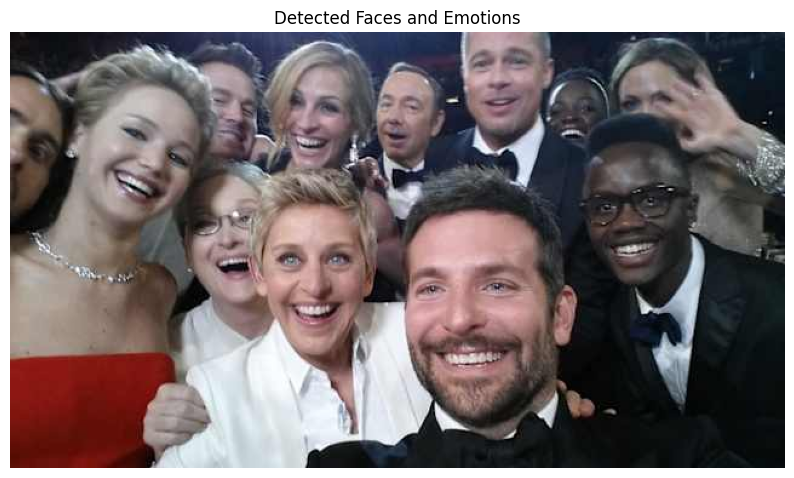

In [6]:
# predict_emotions_from_url.py

import os
import requests
import cv2
import numpy as np
import tensorflow as tf
from retinaface import RetinaFace # Import the RetinaFace library
import matplotlib.pyplot as plt

# =============================================================================
# Configuration (Match your training setup)
# =============================================================================
IMG_SIZE = 224  # Image size expected by your models
MODEL_PATH_1 = "best_EfficientNetB0.keras" # Path to your first saved model
MODEL_PATH_2 = "best_EfficientNetB4.keras" # Path to your second saved model
CLASS_NAMES = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] # Verify this matches training output
NUM_CLASSES = len(CLASS_NAMES)
ENSEMBLE_WEIGHTS = [0.7, 0.3] # Weights for model1, model2 (adjust if needed)

# =============================================================================
# Load Trained Emotion Models
# =============================================================================
print("Loading emotion models...")
try:
    # Allow mixed precision compatibility if models were trained with it
    # policy = tf.keras.mixed_precision.Policy('mixed_float16')
    # tf.keras.mixed_precision.set_global_policy(policy) # Optional, might depend on TF version and saving format

    model1 = tf.keras.models.load_model(MODEL_PATH_1, compile=False) # compile=False speeds up loading for inference
    model2 = tf.keras.models.load_model(MODEL_PATH_2, compile=False)
    print(f"Loaded model 1: {model1.name}")
    print(f"Loaded model 2: {model2.name}")
    models_loaded = [model1, model2]
except Exception as e:
    print(f"Error loading models: {e}")
    print("Please ensure model files are present and TensorFlow is installed correctly.")
    exit()

# =============================================================================
# Helper Functions
# =============================================================================

def download_image(url):
    """Downloads an image from a URL and returns it as an OpenCV image."""
    try:
        response = requests.get(url, stream=True, timeout=10)
        response.raise_for_status() # Raise an exception for bad status codes
        image_array = np.asarray(bytearray(response.raw.read()), dtype=np.uint8)
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR) # Decode into BGR format
        if image is None:
             raise ValueError("Could not decode image")
        print(f"Image downloaded successfully from {url}")
        return image
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

def preprocess_face_for_emotion(face_image, target_size):
    """Preprocesses a face image for the emotion model."""
    # Resize
    face_resized = tf.image.resize(face_image, [target_size, target_size], method='nearest')
    # Convert to float32 (EfficientNet expects float32 inputs, typically scaled [0, 255])
    face_processed = tf.cast(face_resized, tf.float32)
    # Add batch dimension
    face_batch = tf.expand_dims(face_processed, axis=0)
    return face_batch

def predict_emotion(face_batch, models, weights, class_names):
    """Predicts emotion using the ensemble of models."""
    all_preds_probs = []
    for model in models:
        preds = model.predict(face_batch, verbose=0) # verbose=0 to suppress prediction progress bar
        all_preds_probs.append(preds)

    # Weighted average of probabilities
    weighted_preds_probs = np.tensordot(weights, all_preds_probs, axes=([0],[0]))
    
    # Get predicted class index and confidence
    predicted_class_index = np.argmax(weighted_preds_probs[0])
    confidence = np.max(weighted_preds_probs[0])
    predicted_emotion = class_names[predicted_class_index]

    return predicted_emotion, confidence

# =============================================================================
# Main Prediction Function
# =============================================================================

def detect_and_predict_emotions(image_url):
    """Downloads image, detects faces, predicts emotions, and returns annotated image."""

    # 1. Download Image
    img_bgr = download_image(image_url)
    if img_bgr is None:
        return None, "Failed to download or decode image."

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Convert to RGB for RetinaFace and display

    # 2. Detect Faces using RetinaFace
    print("Detecting faces...")
    try:
        # Note: RetinaFace might build the model on first run, which can take time.
        # It automatically uses GPU if available and tensorflow backend is installed.
        detections = RetinaFace.detect_faces(img_rgb) # Expects RGB
        print(f"Found {len(detections)} potential faces.")
    except Exception as e:
        print(f"Error during face detection: {e}")
        return img_bgr, f"Face detection error: {e}" # Return original image with error

    if not isinstance(detections, dict):
         print("No faces detected or unexpected output format from RetinaFace.")
         return img_bgr, "No faces detected."

    annotated_img = img_bgr.copy() # Work on a copy for drawing

    # 3. Process each detected face
    results = []
    for key, face_info in detections.items():
        try:
            facial_area = face_info['facial_area']
            confidence_face = face_info['score']

            # Extract face bounding box [x1, y1, x2, y2]
            x1, y1, x2, y2 = facial_area
            
            # Add padding to bounding box (optional, sometimes improves results)
            padding = 20 
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(img_rgb.shape[1], x2 + padding)
            y2 = min(img_rgb.shape[0], y2 + padding)

            # Ensure coordinates are valid
            if x1 >= x2 or y1 >= y2:
                 print(f"Skipping invalid face coordinates: {facial_area}")
                 continue

            # Crop face (use RGB image for model prediction as TF prefers RGB)
            face_crop_rgb = img_rgb[y1:y2, x1:x2]

            if face_crop_rgb.size == 0:
                print(f"Skipping empty face crop for area: {facial_area}")
                continue

            # 4. Preprocess face for emotion model
            face_batch = preprocess_face_for_emotion(face_crop_rgb, IMG_SIZE)

            # 5. Predict Emotion
            emotion, confidence_emotion = predict_emotion(face_batch, models_loaded, ENSEMBLE_WEIGHTS, CLASS_NAMES)
            results.append({
                 "box": (x1, y1, x2, y2),
                 "face_confidence": confidence_face,
                 "emotion": emotion,
                 "emotion_confidence": confidence_emotion
            })

            # 6. Draw on the BGR image for output
            label = f"{emotion} ({confidence_emotion:.2f})"
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2) # Green box

            # Put text above the box
            text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(annotated_img, (x1, y1 - text_size[1] - 10), (x1 + text_size[0], y1 - 5), (0, 255, 0), -1) # Green background
            cv2.putText(annotated_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2) # Black text

        except Exception as e:
            print(f"Error processing face {key}: {e}")
            # Draw a red box for faces that caused errors during processing
            try: # Ensure facial_area exists even if error occurred later
                 x1, y1, x2, y2 = facial_area
                 cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 0, 255), 2) # Red box for errors
            except: pass # Ignore if facial_area itself was the problem

    print("\nPrediction Results:")
    for res in results:
        print(f"- Box: {res['box']}, Emotion: {res['emotion']} (Conf: {res['emotion_confidence']:.2f}), FaceConf: {res['face_confidence']:.2f}")

    return annotated_img, results

# =============================================================================
# Example Usage
# =============================================================================
if __name__ == "__main__":
    # Replace with the URL of the image you want to process
    image_url_to_test = "https://img.playbuzz.com/image/upload/c_crop/q_auto:good,f_auto,fl_lossy,w_640,c_limit,dpr_1/v1529570769/myuuxslhz7udhdxj0ihh.jpg" # Example URL

    annotated_image, prediction_results = detect_and_predict_emotions(image_url_to_test)

    if annotated_image is not None:
        print("\nDisplaying annotated image...")
        # Display the image using matplotlib (handles different environments better than cv2.imshow)
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)) # Convert back to RGB for plt
        plt.title("Detected Faces and Emotions")
        plt.axis('off')
        plt.show()

        # Optionally save the annotated image
        # output_filename = "annotated_output.jpg"
        # cv2.imwrite(output_filename, annotated_image)
        # print(f"Annotated image saved to {output_filename}")

In [ ]:
# predict_emotions_from_url_streamlined.py

import os
import requests
import cv2
import numpy as np
import tensorflow as tf
from retinaface import RetinaFace # Import the RetinaFace library
import matplotlib.pyplot as plt

# =============================================================================
# Configuration (Streamlined)
# =============================================================================
IMG_SIZE = 224  # Image size expected by your models
# <<< Keep only the path to the single ensemble model >>>
ENSEMBLE_MODEL_PATH = "emotion_ensemble_final.keras"
CLASS_NAMES = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] # Verify this matches training output
NUM_CLASSES = len(CLASS_NAMES)
# <<< Removed unused MODEL_PATH_1, MODEL_PATH_2, ENSEMBLE_WEIGHTS >>>

# =============================================================================
# Load the SINGLE Ensemble Model
# =============================================================================
print("Loading the ensemble emotion model...")
try:
    # Load only the single ensemble model
    ensemble_model = tf.keras.models.load_model(ENSEMBLE_MODEL_PATH, compile=False) # compile=False speeds up loading
    print(f"Loaded ensemble model: {ensemble_model.name}")
except Exception as e:
    print(f"Error loading ensemble model: {e}")
    print(f"Please ensure model file '{ENSEMBLE_MODEL_PATH}' is present.")
    exit()

# =============================================================================
# Helper Functions
# =============================================================================

def download_image(url):
    """Downloads an image from a URL and returns it as an OpenCV image."""
    try:
        response = requests.get(url, stream=True, timeout=10)
        response.raise_for_status()
        image_array = np.asarray(bytearray(response.raw.read()), dtype=np.uint8)
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
        if image is None:
             raise ValueError("Could not decode image")
        print(f"Image downloaded successfully from {url}")
        return image
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

def preprocess_face_for_emotion(face_image, target_size):
    """Preprocesses a face image for the emotion model."""
    face_resized = tf.image.resize(face_image, [target_size, target_size], method='nearest')
    face_processed = tf.cast(face_resized, tf.float32)
    face_batch = tf.expand_dims(face_processed, axis=0)
    return face_batch

# <<< Renamed function: Only need one prediction function now >>>
def predict_emotion(face_batch, model, class_names):
    """Predicts emotion using the loaded ensemble model."""
    # Predict directly with the ensemble model
    ensemble_preds_probs = model.predict(face_batch, verbose=0)

    # Get predicted class index and confidence
    predicted_class_index = np.argmax(ensemble_preds_probs[0])
    confidence = np.max(ensemble_preds_probs[0])
    predicted_emotion = class_names[predicted_class_index]

    return predicted_emotion, confidence

# <<< Removed the old predict_emotion function that averaged manually >>>

# =============================================================================
# Main Prediction Function
# =============================================================================

def detect_and_predict_emotions(image_url):
    """Downloads image, detects faces, predicts emotions, and returns annotated image."""

    # 1. Download Image
    img_bgr = download_image(image_url)
    if img_bgr is None:
        return None, "Failed to download or decode image."

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Detect Faces using RetinaFace
    print("Detecting faces...")
    try:
        detections = RetinaFace.detect_faces(img_rgb)
        print(f"Found {len(detections)} potential faces.")
    except Exception as e:
        print(f"Error during face detection: {e}")
        return img_bgr, f"Face detection error: {e}"

    if not isinstance(detections, dict):
         print("No faces detected or unexpected output format from RetinaFace.")
         return img_bgr, "No faces detected."

    annotated_img = img_bgr.copy()

    # 3. Process each detected face
    results = []
    for key, face_info in detections.items():
        try:
            facial_area = face_info['facial_area']
            confidence_face = face_info['score']
            x1, y1, x2, y2 = facial_area
            padding = 20
            x1 = max(0, x1 - padding); y1 = max(0, y1 - padding)
            x2 = min(img_rgb.shape[1], x2 + padding); y2 = min(img_rgb.shape[0], y2 + padding)

            if x1 >= x2 or y1 >= y2:
                 print(f"Skipping invalid face coordinates: {facial_area}")
                 continue

            face_crop_rgb = img_rgb[y1:y2, x1:x2]
            if face_crop_rgb.size == 0:
                print(f"Skipping empty face crop for area: {facial_area}")
                continue

            # 4. Preprocess face
            face_batch = preprocess_face_for_emotion(face_crop_rgb, IMG_SIZE)

            # 5. Predict Emotion (using the single loaded ensemble model)
            # <<< Call the single prediction function ONCE >>>
            emotion, confidence_emotion = predict_emotion(face_batch, ensemble_model, CLASS_NAMES)

            # <<< Append result ONCE >>>
            results.append({
                 "box": (x1, y1, x2, y2),
                 "face_confidence": confidence_face,
                 "emotion": emotion,
                 "emotion_confidence": confidence_emotion
            })

            # 6. Draw annotations
            label = f"{emotion} ({confidence_emotion:.2f})"
            cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            text_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(annotated_img, (x1, y1 - text_size[1] - 10), (x1 + text_size[0], y1 - 5), (0, 255, 0), -1)
            cv2.putText(annotated_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

        except Exception as e:
            print(f"Error processing face {key}: {e}")
            try:
                 x1, y1, x2, y2 = facial_area
                 cv2.rectangle(annotated_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            except: pass

    print("\nPrediction Results:")
    for res in results:
        print(f"- Box: {res['box']}, Emotion: {res['emotion']} (Conf: {res['emotion_confidence']:.2f}), FaceConf: {res['face_confidence']:.2f}")

    return annotated_img, results

# =============================================================================
# Example Usage (Same as before)
# =============================================================================
if __name__ == "__main__":
    image_url_to_test = "https://img.playbuzz.com/image/upload/c_crop/q_auto:good,f_auto,fl_lossy,w_640,c_limit,dpr_1/v1529570769/myuuxslhz7udhdxj0ihh.jpg" # Example URL

    annotated_image, prediction_results = detect_and_predict_emotions(image_url_to_test)

    if annotated_image is not None:
        print("\nDisplaying annotated image...")
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title("Detected Faces and Emotions (Streamlined)")
        plt.axis('off')
        plt.show()
        # output_filename = "annotated_output_streamlined.jpg"
        # cv2.imwrite(output_filename, annotated_image)
        # print(f"Saved annotated image to {output_filename}")

In [ ]:
# My code 3.0 (deepcloud) crash because of RAM tested with 32 and 64

import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2, Xception, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Concatenate, Activation, Lambda, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from datetime import datetime

# =============================================================================
# Configure GPU and enable mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# =============================================================================
# Key parameters (Adjusted for memory optimization and stability)
# =============================================================================
BATCH_SIZE = 32  # Maintain balance between memory and throughput
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# Create main log directories
ensure_dir(LOG_DIR)
ensure_dir(LOG_DIR + '/affectnet')
ensure_dir(LOG_DIR + '/fer2013')
ensure_dir(LOG_DIR + '/combined')
ensure_dir(LOG_DIR + '/ensemble')
ensure_dir("./model_checkpoints")
ensure_dir("./cache")
ensure_dir("./weights")

# Prioritize problematic classes by severity for targeted augmentation
# The order indicates priority level for augmentation and oversampling
PROBLEMATIC_CLASSES = ['contempt', 'fear', 'disgust', 'sad', 'anger', 'surprise']

# =============================================================================
# Enhanced Focal Loss for better handling of class imbalance
# =============================================================================
def focal_loss(gamma=2.0, alpha=None):
    """
    Focal loss implementation for better handling of class imbalance.
    Focuses training on hard examples by down-weighting easy examples.
    
    Args:
        gamma: Focusing parameter (higher = more focus on hard examples)
        alpha: Optional class weight factors
        
    Returns:
        Loss function
    """
    def loss_fn(y_true, y_pred):
        # Add small epsilon to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        
        # Basic cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Apply class weighting if provided
        if alpha is not None:
            # Convert alpha to proper shape if it's a dict
            if isinstance(alpha, dict):
                # Create a tensor of appropriate shape filled with ones
                alpha_tensor = tf.ones_like(y_true)
                
                # For each class index in the alpha dict, update the corresponding
                # position in alpha_tensor with the weight value
                for class_idx, weight in alpha.items():
                    # Create a mask for the current class
                    class_mask = tf.cast(tf.equal(tf.argmax(y_true, axis=-1), class_idx), tf.float32)
                    
                    # Reshape to broadcast properly
                    class_mask = tf.expand_dims(class_mask, axis=-1)
                    
                    # Update weights for this class
                    alpha_tensor = alpha_tensor * (1 - class_mask) + weight * class_mask
                
                cross_entropy = alpha_tensor * cross_entropy
            else:
                cross_entropy = alpha * cross_entropy
        
        # Apply focusing parameter
        focal_weight = tf.pow(1 - y_pred, gamma)
        focal_loss = focal_weight * cross_entropy
        
        # Sum over classes
        return tf.reduce_sum(focal_loss, axis=-1)
    
    return loss_fn

# =============================================================================
# Enhanced Image Preprocessing with Stronger Augmentation for Hard Classes
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Advanced preprocessing with class-adaptive augmentation strategies.
    Uses stronger augmentation for difficult emotions to improve generalization.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        training: Whether to apply augmentation
        
    Returns:
        Preprocessed image (consistent size) and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image with proper error handling
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([224, 224, 3], dtype=tf.uint8)
    
    img = decode_image()
    img = tf.cast(img, tf.float32)
    
    # Dataset-specific preprocessing for grayscale/RGB
    if source == 'fer2013':
        # Properly handle grayscale images
        if tf.shape(img)[-1] == 1:
            img = tf.tile(img, [1, 1, 3])  # Expand to 3 channels
        else:
            # Convert to grayscale then back to 3 channels for consistency
            img = tf.image.rgb_to_grayscale(img)
            img = tf.tile(img, [1, 1, 3])
    
    # Resize ALL images to a standard intermediate size
    # 224x224 is chosen as it's compatible with EfficientNetB0
    img = tf.image.resize(img, [224, 224], method='bilinear')
    
    # Apply advanced augmentation during training
    if training:
        # Always flip horizontally (standard augmentation)
        img = tf.image.random_flip_left_right(img)
        
        # Enhanced color/brightness adjustments
        img = tf.image.random_brightness(img, 0.35)  # Further increased
        img = tf.image.random_contrast(img, 0.65, 1.35)  # Wider range
        img = tf.image.random_saturation(img, 0.5, 1.5)  # Added saturation adjustment
        
        # Stronger geometric transformations:
        
        # 1. More aggressive random rotation (±20 degrees)
        angle = tf.random.uniform([], -0.349066, 0.349066)  # ±20 degrees in radians
        img = tf.image.rot90(img, k=tf.cast(angle / (np.pi/2) * 4, tf.int32))
        
        # 2. Random zoom with variable ranges
        zoom_factor = tf.random.uniform([], 0.75, 1.0)  # More aggressive zoom
        h, w = tf.shape(img)[0], tf.shape(img)[1]
        crop_size_h = tf.cast(tf.cast(h, tf.float32) * zoom_factor, tf.int32)
        crop_size_w = tf.cast(tf.cast(w, tf.float32) * zoom_factor, tf.int32)
        img = tf.image.random_crop(img, [crop_size_h, crop_size_w, 3])
        img = tf.image.resize(img, [224, 224])
        
        # 3. Random translation
        # Pad the image and then crop at random position
        padded = tf.image.resize_with_crop_or_pad(img, 240, 240)  # Add 16 pixels of padding
        img = tf.image.random_crop(padded, [224, 224, 3])  # Random crop back to original size
        
        # 4. Occasionally apply Gaussian blur (helps with generalization)
        # Simulated with average pooling followed by upsampling
        apply_blur = tf.random.uniform([], 0, 1) < 0.3  # 30% chance to apply blur
        
        def apply_gaussian_blur(image):
            blurred = tf.nn.avg_pool2d(
                tf.expand_dims(image, 0), 
                ksize=[1, 3, 3, 1], 
                strides=[1, 1, 1, 1], 
                padding='SAME'
            )
            return tf.squeeze(blurred, 0)
        
        img = tf.cond(apply_blur, 
                     lambda: apply_gaussian_blur(img), 
                     lambda: img)
        
        # 5. Add more aggressive noise
        noise_level = tf.random.uniform([], 0.01, 0.025)  # Randomized noise level
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=noise_level)
        img = img + noise
        
        # Ensure valid range
        img = tf.clip_by_value(img, 0.0, 255.0)
    
    # Basic normalization to [0,1] range for consistency
    img = img / 255.0
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)  # 8 emotion classes
    
    return img, label

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

# =============================================================================
# FIXED: Enhanced dataset creation with proper repeat mechanism
# =============================================================================
def create_dataset(dataframe, is_training=True, dataset_type=None, cache=False):
    """Fixed dataset creation with proper infinite repetition for training"""
    if dataset_type:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
    
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create the base dataset
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Memory optimization: Only cache validation/test datasets
    if cache and not is_training:
        cache_name = f'./cache/{dataset_type}_cache' if dataset_type else './cache/combined_cache'
        ds = ds.cache(cache_name)
    
    # Create a constant for the training value to avoid retracing
    training_value = tf.constant(is_training)
    
    # Apply preprocessing
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        # Better shuffling with larger buffer
        buffer_size = min(len(dataframe), 20000)
        
        # CRITICAL FIX: First shuffle, then repeat BEFORE batching
        # This ensures we get different batches in each epoch
        ds = ds.shuffle(buffer_size=buffer_size, reshuffle_each_iteration=True)
        
        # Make dataset infinite but BEFORE batching
        ds = ds.repeat(-1)  # -1 means repeat indefinitely
    
    # Then batch and prefetch
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Create more aggressively balanced dataset with emphasis classes
# =============================================================================
def create_emphasis_dataset(dataframe, is_training=True, emphasis_classes=PROBLEMATIC_CLASSES):
    """
    Creates a highly balanced dataset with progressive emphasis on problematic classes.
    Classes are oversampled with different ratios based on their difficulty level.
    
    Args:
        dataframe: Input DataFrame
        is_training: Whether to apply training augmentations
        emphasis_classes: List of classes to emphasize (in priority order)
        
    Returns:
        Balanced tf.data.Dataset with progressive emphasis on specified classes
    """
    balanced_data = []
    
    # Get class counts to determine relative scarcity
    class_counts = dataframe["label"].value_counts().to_dict()
    max_count = max(class_counts.values())
    
    # Sample from each class with progressive emphasis
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        class_size = len(class_df)
        
        # Base sampling for non-problematic classes (reduced from previous 350)
        samples_per_class = 300
        
        # Progressive oversampling based on position in emphasis_classes list
        if class_name in emphasis_classes:
            # Higher emphasis for classes earlier in the list
            priority_index = emphasis_classes.index(class_name)
            
            # Exponential scaling based on priority (earlier = more samples)
            priority_factor = 1.0 + (len(emphasis_classes) - priority_index) * 0.4
            
            # Additional scaling for extremely underrepresented classes
            if class_size < (max_count * 0.1):  # Less than 10% of max class
                priority_factor *= 1.5
            
            # Calculate final sample count
            samples_per_class = int(800 * priority_factor)
            
            # Special handling for contempt which has very few samples
            if class_name == 'contempt':
                samples_per_class = 1200  # Extreme oversampling for contempt
        
        print(f"Class {class_name}: Sampling {samples_per_class} from {class_size} images")
        
        # Sample with replacement if needed
        if class_size <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples (progressive emphasis on {emphasis_classes})")
    
    # Create dataset with fixed repeat mechanism
    return create_dataset(balanced_df, is_training=is_training, cache=False)

# =============================================================================
# Enhanced Confusion Matrix Callback with Class-Specific Monitoring
# =============================================================================
class EnhancedConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Enhanced callback to monitor class-specific metrics during training.
    """
    def __init__(self, validation_data, class_names, log_dir, model_name="model", freq=5):
        super(EnhancedConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir
        self.model_name = model_name
        self.zero_prediction_classes = set()  # Track classes with zero predictions
        self.class_metrics_history = {cls: [] for cls in class_names}  # Track per-class metrics
        
        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log class-specific metrics every epoch
        val_steps = 20  # Limit computation
        y_true = []
        y_pred = []
        
        # Get predictions for validation data
        for i, (images, labels) in enumerate(self.validation_data):
            if i >= val_steps:
                break
            batch_preds = self.model.predict(images, verbose=0)
            y_pred.append(np.argmax(batch_preds, axis=1))
            y_true.append(np.argmax(labels.numpy(), axis=1))
        
        # Flatten the lists
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class metrics
        class_accuracies = np.zeros(len(self.class_names))
        for i in range(len(self.class_names)):
            if np.sum(y_true == i) > 0:  # Avoid division by zero
                class_accuracies[i] = cm[i, i] / np.sum(y_true == i)
                
            # Track metrics history
            self.class_metrics_history[self.class_names[i]].append(class_accuracies[i])
        
        # Check for classes with zero predictions
        zero_pred_classes = []
        for i, class_name in enumerate(self.class_names):
            if np.sum(cm[:, i]) == 0:
                zero_pred_classes.append(class_name)
                self.zero_prediction_classes.add(class_name)
        
        # Log warnings for zero prediction classes
        if zero_pred_classes:
            warning_msg = f"\n⚠️ WARNING: Zero predictions for classes: {', '.join(zero_pred_classes)}"
            print(warning_msg)
            
            # Save warning to log file
            with open(f"{self.log_dir}/warnings.txt", "a") as f:
                f.write(f"Epoch {epoch+1}: {warning_msg}\n")
       
        # Save visualizations and detailed reports on the specified frequency
        if (epoch + 1) % self.freq == 0:
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Print per-class accuracy
            for i, (name, acc) in enumerate(zip(self.class_names, class_accuracies)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print("\n")
            
            # Print class accuracy trends
            print("Class Accuracy Trends:")
            for class_name in self.class_names:
                history = self.class_metrics_history[class_name]
                trend = ", ".join([f"{acc:.4f}" for acc in history[-5:]])  # Show last 5 epochs
                print(f"{class_name}: [{trend}]")
            print()
            
            # Save confusion matrix visualization
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {self.model_name} - Epoch {epoch+1}')
            plt.tight_layout()
            
            try:
                plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png')
            except Exception as e:
                print(f"Warning: Could not save confusion matrix plot: {e}")
            
            plt.close()

        # Add memory cleanup
        del images, labels, batch_preds
        gc.collect()

# =============================================================================
# FIXED: Create Ensemble Model Architecture with Internal Preprocessing
# =============================================================================
def create_ensemble_model(num_classes=8, freeze_base=True):
    """
    Create a memory-optimized ensemble with reduced parameter count.
    All preprocessing happens inside the model, which expects
    a standard size input (224x224x3 normalized to [0,1]).
    
    Args:
        num_classes: Number of emotion classes
        freeze_base: Whether to freeze base models initially
        
    Returns:
        Compiled Keras ensemble model
    """
    # MEMORY OPTIMIZATION: Use tf.keras.mixed_precision
    # Enable mixed precision at the start of model creation
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Using mixed precision policy:", policy.name)
    
    # Create inputs for consistently sized images
    inputs = keras.layers.Input(shape=(224, 224, 3), name='image_input')
    
    # ==================== MobileNetV2 Branch (Memory Optimized) ====================
    # Use a smaller input size for MobileNetV2 to reduce memory
    mobilenet_preprocess = Lambda(
        lambda x: tf.image.resize(x*255.0, [96, 96]) / 127.5 - 1,
        name='mobilenet_preprocess'
    )(inputs)
    
    # Create MobileNetV2 as standalone model with alpha=0.75 to reduce parameters
    try:
        mobilenet_core = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(96, 96, 3),
            alpha=0.75,  # Use a smaller model (75% of filters)
            name='mobilenet_core'
        )
    except Exception as e:
        print(f"MobileNetV2 imagenet weights failed to load: {e}")
        mobilenet_core = MobileNetV2(
            include_top=False,
            weights=None,
            input_shape=(96, 96, 3),
            alpha=0.75,  # Use a smaller model
            name='mobilenet_core'
        )
        try:
            mobilenet_core.load_weights('weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
        except Exception as e:
            print(f"Failed to load local MobileNetV2 weights: {e}, continuing with random initialization")
    
    mobilenet_features = mobilenet_core(mobilenet_preprocess)
    # Use global average pooling to significantly reduce parameters
    mobilenet_features = GlobalAveragePooling2D(name='mobilenet_gap')(mobilenet_features)

    # ==================== Xception Branch (Memory Optimized) ====================
    # MEMORY OPTIMIZATION: Create Xception with proper error handling
    xception_preprocess = Lambda(
        lambda x: tf.keras.applications.xception.preprocess_input(
            tf.image.resize(x*255.0, [299, 299])
        ),
        name='xception_preprocess'
    )(inputs)
    
    try:
        xception_core = Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            name='xception_core'
        )
    except Exception as e:
        print(f"Xception imagenet weights failed to load: {e}")
        xception_core = Xception(
            include_top=False,
            weights=None,
            input_shape=(299, 299, 3),
            name='xception_core'
        )
        try:
            xception_core.load_weights('weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
        except Exception as e:
            print(f"Failed to load local Xception weights: {e}, continuing with random initialization")
    
    xception_features = xception_core(xception_preprocess)
    xception_features = GlobalAveragePooling2D(name='xception_gap')(xception_features)

    # ==================== EfficientNetB0 Branch (Memory Optimized) ====================
    # Use smaller input size for EfficientNetB0 to reduce memory
    efficientnet_preprocess = Lambda(
        lambda x: tf.keras.applications.efficientnet.preprocess_input(x*255.0),
        name='efficientnet_preprocess'
    )(inputs)
    
    # Create EfficientNetB0 with reduced complexity for memory savings
    try:
        efficientnet_core = EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            name='efficientnet_core'
        )
    except Exception as e:
        print(f"EfficientNetB0 imagenet weights failed to load: {e}")
        efficientnet_core = EfficientNetB0(
            include_top=False,
            weights=None,
            input_shape=(224, 224, 3),
            name='efficientnet_core'
        )
        try:
            efficientnet_core.load_weights('/kaggle/input/efficientnetb0-notop-h5/efficientnetb0_notop.h5')
        except Exception as e:
            print(f"Failed to load local EfficientNetB0 weights: {e}, continuing with random initialization")
    
    efficientnet_features = efficientnet_core(efficientnet_preprocess)
    # Use global average pooling to significantly reduce parameters
    efficientnet_features = GlobalAveragePooling2D(name='efficientnet_gap')(efficientnet_features)

    # ==================== Feature Processing (Memory Optimized) ====================
    # Use smaller projection dimensions to reduce memory
    def create_projection_head(inputs, name):
        # Use 96 dimensions instead of 128 to reduce parameters
        x = Dense(96, name=f'{name}_projection')(inputs)
        x = BatchNormalization()(x)
        return Activation('relu', dtype='float32')(x)
    
    mobilenet_features = create_projection_head(mobilenet_features, 'mobilenet')
    xception_features = create_projection_head(xception_features, 'xception')
    efficientnet_features = create_projection_head(efficientnet_features, 'efficientnet')

    # ==================== Feature Fusion (Memory Optimized) ====================
    merged_features = Concatenate(name='feature_fusion')([
        mobilenet_features,
        xception_features,
        efficientnet_features
    ])

    # ==================== Classification Head (Memory Optimized) ====================
    # Use smaller hidden layers to reduce parameters
    x = Dense(192, name='fusion_dense1')(merged_features)  # Reduced from 256
    x = BatchNormalization()(x)
    x = Activation('relu', dtype='float32')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(96, name='fusion_dense2')(x)  # Reduced from 128
    x = BatchNormalization()(x)
    x = Activation('relu', dtype='float32')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name='emotion_output')(x)

    # ==================== Model Assembly ====================
    model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='emotion_ensemble'
    )
    
    # Freeze base models if requested (important for memory optimization)
    if freeze_base:
        mobilenet_core.trainable = False
        xception_core.trainable = False
        efficientnet_core.trainable = False

    # ==================== Compilation ====================
    # Use a gentler initial learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
        keras.optimizers.Adam(
            tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=5e-4,  # Reduced from original
                decay_steps=15000
            )
        )
    )
    
    # Add gradient clipping to avoid instability
    optimizer.clipnorm = 1.0
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Print model memory requirements (estimate)
    print(f"Model created with {model.count_params():,} parameters")
    
    # Force garbage collection after model creation
    gc.collect()
    K.clear_session()
    
    return model

# =============================================================================
# Evaluation function
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Evaluate model with detailed metrics and visualizations.
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= steps:
            break
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    
    try:
        plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png')
    except Exception as e:
        print(f"Warning: Could not save confusion matrix plot: {e}")
        
    plt.close()
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    # Save report to file
    with open(f'{log_dir}/classification_report_{dataset_name}.txt', 'w') as f:
        f.write(report)
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# FIXED: Progressive Training Strategy for Ensemble with Corrected Layer Names
# =============================================================================
def train_ensemble_with_progressive_strategy(model, train_ds, val_ds, 
                                           steps_per_epoch, val_steps,
                                           total_epochs=30,
                                           callbacks=None,
                                           class_weights=None):
    """
    Enhanced three-stage training approach for ensemble with safeguards against dataset depletion.
    Each fit call is wrapped in a try/except to handle potential errors gracefully.
    
    Args:
        model: The ensemble model
        train_ds: Training dataset
        val_ds: Validation dataset
        steps_per_epoch: Steps per training epoch
        val_steps: Validation steps
        total_epochs: Total epochs across all stages
        callbacks: List of callbacks
        class_weights: Class weights for handling imbalance
        
    Returns:
        Training history
    """
    histories = []
    
    # Stage 1: Train only fusion layers (15% of total epochs)
    stage1_epochs = max(5, int(total_epochs * 0.15))  # Increased from 10% to 15%
    print(f"\nStage 1: Training only fusion layers ({stage1_epochs} epochs)")
    
    # Ensure base models are frozen
    mobilenet_core = model.get_layer('mobilenet_core')
    xception_core = model.get_layer('xception_core')
    efficientnet_core = model.get_layer('efficientnet_core')
    
    # Explicitly freeze all base models
    mobilenet_core.trainable = False
    xception_core.trainable = False
    efficientnet_core.trainable = False
    
    # Recompile with stable initial learning rate
    optimizer = keras.optimizers.Adam(learning_rate=3e-4)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    optimizer.clipnorm = 1.0  # Add gradient clipping
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Train fusion layers with error handling
    try:
        # CRITICAL FIX: Ensure training steps don't exceed dataset size
        # This is a safeguard in case the dataset repeat mechanism fails
        effective_steps = min(steps_per_epoch, 10000)
        
        history1 = model.fit(
            train_ds,
            epochs=stage1_epochs,
            steps_per_epoch=effective_steps,  # Use safe step count
            validation_data=val_ds,
            validation_steps=val_steps,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        histories.append(history1)
    except Exception as e:
        print(f"Warning: Stage 1 training encountered an error: {e}")
        print("Continuing to next stage...")

    K.clear_session()
    gc.collect()
    
    # Stage 2: Unfreeze and train EfficientNet and MobileNet (35% of total epochs)
    stage2_epochs = max(7, int(total_epochs * 0.35))  # Increased from 30% to 35%
    print(f"\nStage 2: Training EfficientNet and MobileNet branches ({stage2_epochs} epochs)")
    
    # Get reference to actual base models (using correct layer names)
    mobilenet = model.get_layer('mobilenet_core')
    efficientnet = model.get_layer('efficientnet_core')
    
    # Partially unfreeze base models (last 30 layers of each)
    for base_model in [mobilenet, efficientnet]:
        base_model.trainable = True
        # Freeze early layers, unfreeze later layers
        for i, layer in enumerate(base_model.layers):
            layer.trainable = (i >= len(base_model.layers) - 30)
    
    # Keep Xception frozen
    xception_core.trainable = False
    
    # Recompile with lower learning rate
    optimizer = keras.optimizers.Adam(learning_rate=8e-5)  # Gentler learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    optimizer.clipnorm = 1.0  # Add gradient clipping
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Train with partial unfreezing, with error handling
    try:
        history2 = model.fit(
            train_ds,
            epochs=stage2_epochs,
            steps_per_epoch=effective_steps,  # Use same safe step count
            validation_data=val_ds,
            validation_steps=val_steps,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        histories.append(history2)
    except Exception as e:
        print(f"Warning: Stage 2 training encountered an error: {e}")
        print("Continuing to next stage...")

    K.clear_session()
    gc.collect()
    
    # Stage 3: Unfreeze all models and fine-tune (remaining epochs)
    stage3_epochs = total_epochs - stage1_epochs - stage2_epochs
    print(f"\nStage 3: Fine-tuning all models ({stage3_epochs} epochs)")
    
    # Unfreeze Xception (using correct layer name)
    xception = model.get_layer('xception_core')
    xception.trainable = True
    
    # Partially unfreeze layers (last 50 layers of each model)
    for base_model in [mobilenet, efficientnet, xception]:
        for i, layer in enumerate(base_model.layers):
            layer.trainable = (i >= len(base_model.layers) - 50)
    
    # Recompile with even lower learning rate
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)  # Even gentler learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    optimizer.clipnorm = 1.0  # Add gradient clipping
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Final fine-tuning with error handling
    try:
        history3 = model.fit(
            train_ds,
            epochs=stage3_epochs,
            steps_per_epoch=effective_steps,  # Use same safe step count
            validation_data=val_ds,
            validation_steps=val_steps,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        histories.append(history3)
    except Exception as e:
        print(f"Warning: Stage 3 training encountered an error: {e}")
    
    K.clear_session()
    gc.collect()
    
    return histories

# =============================================================================
# Main training pipeline with ensemble
# =============================================================================
def train_emotion_ensemble(data_dir):
    """
    Enhanced sequential training pipeline for emotion recognition ensemble.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        Trained ensemble model and evaluation metrics
    """
    print("Starting enhanced ensemble training for emotion recognition")
    
    # 1. Load and prepare data
    print("\n1. Loading datasets")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet']
    test_fer_df = test_df[test_df['source'] == 'fer2013']
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet']
    affectnet_train_df, affectnet_val_df = train_test_split(
        affectnet_train_df, 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013']
    fer_train_df, fer_val_df = train_test_split(
        fer_train_df, 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # 4. Create datasets with emphasis on problematic classes and caching
    print("\n2. Creating enhanced data pipelines with caching")
    
    # Create datasets with memory optimizations
    affectnet_train_ds, class_indices = create_emphasis_dataset(
        affectnet_train_df, is_training=True
    )
    
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, 
        dataset_type='affectnet', cache=True
    )
    
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, 
        dataset_type='affectnet', cache=True
    )
    
    fer_train_ds, _ = create_emphasis_dataset(
        fer_train_df, is_training=True
    )
    
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, 
        dataset_type='fer2013', cache=True
    )
    
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, 
        dataset_type='fer2013', cache=True
    )
    
    # Create combined test dataset
    combined_test_ds, _ = create_dataset(
        test_df, is_training=False, cache=True)

    # Add periodic garbage collection during evaluation
    def evaluate_with_gc(model, test_ds, steps, class_names, log_dir, dataset_name):
        metrics = evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name)
        K.clear_session()
        gc.collect()
        return metrics
    
    # 5. Calculate steps with increased batch size
    affectnet_steps_per_epoch = len(affectnet_train_df) // BATCH_SIZE
    affectnet_val_steps = len(affectnet_val_df) // BATCH_SIZE
    affectnet_test_steps = len(test_affectnet_df) // BATCH_SIZE
    
    fer_steps_per_epoch = len(fer_train_df) // BATCH_SIZE
    fer_val_steps = len(fer_val_df) // BATCH_SIZE
    fer_test_steps = len(test_fer_df) // BATCH_SIZE
    
    combined_test_steps = len(test_df) // BATCH_SIZE
    
    # 6. Create ensemble model
    print("\n3. Creating ensemble model architecture")
    ensemble_model = create_ensemble_model(num_classes=num_classes, freeze_base=True)
    print(f"Ensemble model created with {ensemble_model.count_params():,} parameters")
    
    # 7. Compute class weights with highly adaptive adjustments
    print("\n4. Computing class weights with adaptive adjustments based on class difficulty")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"].values),
        y=affectnet_train_df["label"].values
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"].values), affectnet_weights)}
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"].values),
        y=fer_train_df["label"].values
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"].values), fer_weights)}
    
    # Get class counts for adaptive weighting
    affectnet_counts = affectnet_train_df["label"].value_counts().to_dict()
    fer_counts = fer_train_df["label"].value_counts().to_dict()
    
    # Apply progressive weight scaling based on class difficulty and sample count
    for i, problem_class in enumerate(PROBLEMATIC_CLASSES):
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            
            # Calculate position-based scaling factor (earlier classes get higher weights)
            # Scale from 2.5 for first class down to 1.2 for last class
            position_factor = 2.5 - (i * (1.3 / len(PROBLEMATIC_CLASSES)))
            
            # Apply adaptive weight multiplier to AffectNet
            if class_idx in affectnet_class_weights and problem_class in affectnet_counts:
                # Get the current count
                count = affectnet_counts[problem_class]
                max_count = max(affectnet_counts.values())
                # Additional scarcity factor based on relative sample count
                scarcity_factor = 1.0 + (1.0 - (count / max_count))
                # Apply combined scaling
                affectnet_class_weights[class_idx] *= position_factor * scarcity_factor
            
            # Apply adaptive weight multiplier to FER2013
            if class_idx in fer_class_weights and problem_class in fer_counts:
                # Get the current count
                count = fer_counts[problem_class]
                max_count = max(fer_counts.values())
                # Additional scarcity factor based on relative sample count
                scarcity_factor = 1.0 + (1.0 - (count / max_count))
                # Apply combined scaling
                fer_class_weights[class_idx] *= position_factor * scarcity_factor
                
                # Special handling for extremely underrepresented classes like contempt
                if count < (max_count * 0.05):  # Less than 5% of max class
                    fer_class_weights[class_idx] *= 1.5  # Additional boost
    
    # Make happy and neutral weights slightly lower to avoid bias
    for easy_class in ['happy', 'neutral']:
        if easy_class in class_indices:
            easy_idx = class_indices[easy_class]
            if easy_idx in affectnet_class_weights:
                affectnet_class_weights[easy_idx] *= 0.9
            if easy_idx in fer_class_weights:
                fer_class_weights[easy_idx] *= 0.9
    
    print("Enhanced AffectNet class weights:", affectnet_class_weights)
    print("Enhanced FER2013 class weights:", fer_class_weights)
    
    # 8. Setup callbacks with enhanced monitoring
    print("\n5. Setting up enhanced callbacks")
    
    # Base callbacks shared across training phases
    base_callbacks = [
        # Early stopping with more patience
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Increased from 8
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate monitoring
        tf.keras.callbacks.TensorBoard(
            log_dir=LOG_DIR + '/ensemble',
            histogram_freq=1,
            update_freq='epoch'
        ),
        # Learning rate reduction on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-7
        )
    ]
    
    # AffectNet-specific callbacks
    affectnet_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            model_name="AffectNet Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # FER2013-specific callbacks
    fer_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            model_name="FER2013 Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # 9. STAGE 1: Train ensemble on AffectNet using progressive strategy
    print("\n6. STAGE 1: Training ensemble on AffectNet with progressive strategy")
    
    affectnet_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        affectnet_train_ds, affectnet_val_ds,
        affectnet_steps_per_epoch, affectnet_val_steps,
        total_epochs=20,  # Adjust as needed
        callbacks=affectnet_callbacks,
        class_weights=affectnet_class_weights
    )
    
    # Save AffectNet model
    ensemble_model.save("affectnet_ensemble_model.h5")
    print("AffectNet ensemble model saved to 'affectnet_ensemble_model.h5'")
    
    # 10. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_with_gc(
        ensemble_model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 11. STAGE 2: Fine-tune on FER2013 with progressive strategy
    print("\n7. STAGE 2: Fine-tuning ensemble on FER2013 with progressive strategy")
    
    fer_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        fer_train_ds, fer_val_ds,
        fer_steps_per_epoch, fer_val_steps,
        total_epochs=15,  # Adjust as needed
        callbacks=fer_callbacks,
        class_weights=fer_class_weights
    )
    
    # 12. Evaluate on FER2013 test set
    fer_metrics = evaluate_with_gc(
        ensemble_model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 13. Evaluate on combined test set
    combined_metrics = evaluate_with_gc(
        ensemble_model, 
        combined_test_ds, 
        combined_test_steps,
        classes,
        LOG_DIR,
        dataset_name="Combined"
    )
    
    # 14. Save the final model
    ensemble_model.save("final_emotion_ensemble.h5")
    print("Final ensemble model saved to 'final_emotion_ensemble.h5'")
    
    # Return model and metrics
    return ensemble_model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics,
        'combined': combined_metrics
    }

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Add memory monitoring
    print("Initial RAM usage:", psutil.virtual_memory().percent)
    model, metrics = train_emotion_ensemble(data_dir)
    print("Final RAM usage:", psutil.virtual_memory().percent)
      
    # Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {metrics['affectnet']['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {metrics['affectnet']['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {metrics['fer2013']['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {metrics['fer2013']['f1_score']:.4f}")
    print(f"Combined Test Accuracy: {metrics['combined']['accuracy']:.4f}")
    print(f"Combined F1 Score: {metrics['combined']['f1_score']:.4f}")

In [ ]:
# My code 2.5 (deepcloud) best one yet

import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2, Xception, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Concatenate, Activation, Lambda, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from datetime import datetime

# =============================================================================
# Configure GPU and enable mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# =============================================================================
# Key parameters (Adjusted for memory optimization and stability)
# =============================================================================
BATCH_SIZE = 64  # Maintain balance between memory and throughput
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# Create main log directories
ensure_dir(LOG_DIR)
ensure_dir(LOG_DIR + '/affectnet')
ensure_dir(LOG_DIR + '/fer2013')
ensure_dir(LOG_DIR + '/combined')
ensure_dir(LOG_DIR + '/ensemble')
ensure_dir("./model_checkpoints")
ensure_dir("./cache")
ensure_dir("./weights")

# Extend problematic classes for more targeted augmentation
PROBLEMATIC_CLASSES = ['surprise', 'sad', 'disgust', 'anger', 'fear']

# =============================================================================
# Enhanced Focal Loss for better handling of class imbalance
# =============================================================================
def focal_loss(gamma=2.0, alpha=None):
    """
    Focal loss implementation for better handling of class imbalance.
    Focuses training on hard examples by down-weighting easy examples.
    
    Args:
        gamma: Focusing parameter (higher = more focus on hard examples)
        alpha: Optional class weight factors
        
    Returns:
        Loss function
    """
    def loss_fn(y_true, y_pred):
        # Add small epsilon to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        
        # Basic cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Apply class weighting if provided
        if alpha is not None:
            # Convert alpha to proper shape if it's a dict
            if isinstance(alpha, dict):
                # Create a tensor of appropriate shape filled with ones
                alpha_tensor = tf.ones_like(y_true)
                
                # For each class index in the alpha dict, update the corresponding
                # position in alpha_tensor with the weight value
                for class_idx, weight in alpha.items():
                    # Create a mask for the current class
                    class_mask = tf.cast(tf.equal(tf.argmax(y_true, axis=-1), class_idx), tf.float32)
                    
                    # Reshape to broadcast properly
                    class_mask = tf.expand_dims(class_mask, axis=-1)
                    
                    # Update weights for this class
                    alpha_tensor = alpha_tensor * (1 - class_mask) + weight * class_mask
                
                cross_entropy = alpha_tensor * cross_entropy
            else:
                cross_entropy = alpha * cross_entropy
        
        # Apply focusing parameter
        focal_weight = tf.pow(1 - y_pred, gamma)
        focal_loss = focal_weight * cross_entropy
        
        # Sum over classes
        return tf.reduce_sum(focal_loss, axis=-1)
    
    return loss_fn

# =============================================================================
# Enhanced Image Preprocessing with Stronger Augmentation for Hard Classes
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Enhanced preprocessing with stronger augmentation for difficult classes.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        training: Whether to apply augmentation
        
    Returns:
        Preprocessed image (consistent size) and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image with proper error handling
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([224, 224, 3], dtype=tf.uint8)
    
    img = decode_image()
    img = tf.cast(img, tf.float32)
    
    # Dataset-specific preprocessing for grayscale/RGB
    if source == 'fer2013':
        # Properly handle grayscale images
        if tf.shape(img)[-1] == 1:
            img = tf.tile(img, [1, 1, 3])  # Expand to 3 channels
        else:
            # Convert to grayscale then back to 3 channels for consistency
            img = tf.image.rgb_to_grayscale(img)
            img = tf.tile(img, [1, 1, 3])
    
    # Resize ALL images to a standard intermediate size
    # 224x224 is chosen as it's compatible with EfficientNetB0
    img = tf.image.resize(img, [224, 224], method='bilinear')
    
    # Apply enhanced augmentation during training
    if training:
        # Basic augmentations for all images
        img = tf.image.random_flip_left_right(img)
        
        # Enhanced brightness and contrast adjustment
        img = tf.image.random_brightness(img, 0.3)  # Increased from 0.2
        img = tf.image.random_contrast(img, 0.7, 1.3)  # Wider range
        
        # Add random rotation (±15 degrees)
        angle = tf.random.uniform([], -0.261799, 0.261799)  # ±15 degrees in radians
        img = tf.image.rot90(img, k=tf.cast(angle / (np.pi/2) * 4, tf.int32))
        
        # Random zoom
        zoom_factor = tf.random.uniform([], 0.8, 1.0)
        h, w = tf.shape(img)[0], tf.shape(img)[1]
        crop_size_h = tf.cast(tf.cast(h, tf.float32) * zoom_factor, tf.int32)
        crop_size_w = tf.cast(tf.cast(w, tf.float32) * zoom_factor, tf.int32)
        img = tf.image.random_crop(img, [crop_size_h, crop_size_w, 3])
        img = tf.image.resize(img, [224, 224])
        
        # Add more aggressive noise
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.015)  # Increased from 0.01
        img = img + noise
        
        # Ensure valid range
        img = tf.clip_by_value(img, 0.0, 255.0)
    
    # Basic normalization to [0,1] range for consistency
    img = img / 255.0
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)  # 8 emotion classes
    
    return img, label

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

# =============================================================================
# FIXED: Enhanced dataset creation with proper repeat mechanism
# =============================================================================
def create_dataset(dataframe, is_training=True, dataset_type=None, cache=False):
    """Memory-optimized dataset creation with proper repeat mechanism"""
    if dataset_type:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
    
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Memory optimization: Only cache validation/test datasets
    if cache and not is_training:
        cache_name = f'./cache/{dataset_type}_cache' if dataset_type else './cache/combined_cache'
        ds = ds.cache(cache_name)
    
    training_value = tf.constant(is_training)
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        # Better shuffling with larger buffer
        buffer_size = min(len(dataframe), 20000)  # Increased from 10000
        ds = ds.shuffle(buffer_size=buffer_size)
        # IMPORTANT: Create an infinite dataset by repeating
        ds = ds.repeat()
    
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Create more aggressively balanced dataset with emphasis classes
# =============================================================================
def create_emphasis_dataset(dataframe, is_training=True, emphasis_classes=PROBLEMATIC_CLASSES):
    """
    Creates a more aggressively balanced dataset with emphasis on problematic classes.
    
    Args:
        dataframe: Input DataFrame
        is_training: Whether to apply training augmentations
        emphasis_classes: List of classes to emphasize (oversample)
        
    Returns:
        Balanced tf.data.Dataset with emphasis on specified classes
    """
    balanced_data = []
    
    # Sample from each class with emphasis on problematic ones
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        
        # Base sampling - reduced for non-problematic classes
        samples_per_class = 350  
        
        # Significantly increase samples for emphasis classes
        if class_name in emphasis_classes:
            # 100% more samples for problematic classes (from 400 to 700)
            samples_per_class = 700  
            
        # Sample with replacement if needed
        if len(class_df) <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples (with emphasis on {emphasis_classes})")
    
    # Create dataset with properly working repeat
    return create_dataset(balanced_df, is_training=is_training, cache=False)

# =============================================================================
# Enhanced Confusion Matrix Callback with Class-Specific Monitoring
# =============================================================================
class EnhancedConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Enhanced callback to monitor class-specific metrics during training.
    """
    def __init__(self, validation_data, class_names, log_dir, model_name="model", freq=5):
        super(EnhancedConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir
        self.model_name = model_name
        self.zero_prediction_classes = set()  # Track classes with zero predictions
        self.class_metrics_history = {cls: [] for cls in class_names}  # Track per-class metrics
        
        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log class-specific metrics every epoch
        val_steps = 20  # Limit computation
        y_true = []
        y_pred = []
        
        # Get predictions for validation data
        for i, (images, labels) in enumerate(self.validation_data):
            if i >= val_steps:
                break
            batch_preds = self.model.predict(images, verbose=0)
            y_pred.append(np.argmax(batch_preds, axis=1))
            y_true.append(np.argmax(labels.numpy(), axis=1))
        
        # Flatten the lists
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class metrics
        class_accuracies = np.zeros(len(self.class_names))
        for i in range(len(self.class_names)):
            if np.sum(y_true == i) > 0:  # Avoid division by zero
                class_accuracies[i] = cm[i, i] / np.sum(y_true == i)
                
            # Track metrics history
            self.class_metrics_history[self.class_names[i]].append(class_accuracies[i])
        
        # Check for classes with zero predictions
        zero_pred_classes = []
        for i, class_name in enumerate(self.class_names):
            if np.sum(cm[:, i]) == 0:
                zero_pred_classes.append(class_name)
                self.zero_prediction_classes.add(class_name)
        
        # Log warnings for zero prediction classes
        if zero_pred_classes:
            warning_msg = f"\n⚠️ WARNING: Zero predictions for classes: {', '.join(zero_pred_classes)}"
            print(warning_msg)
            
            # Save warning to log file
            with open(f"{self.log_dir}/warnings.txt", "a") as f:
                f.write(f"Epoch {epoch+1}: {warning_msg}\n")
       
        # Save visualizations and detailed reports on the specified frequency
        if (epoch + 1) % self.freq == 0:
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Print per-class accuracy
            for i, (name, acc) in enumerate(zip(self.class_names, class_accuracies)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print("\n")
            
            # Print class accuracy trends
            print("Class Accuracy Trends:")
            for class_name in self.class_names:
                history = self.class_metrics_history[class_name]
                trend = ", ".join([f"{acc:.4f}" for acc in history[-5:]])  # Show last 5 epochs
                print(f"{class_name}: [{trend}]")
            print()
            
            # Save confusion matrix visualization
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {self.model_name} - Epoch {epoch+1}')
            plt.tight_layout()
            
            try:
                plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png')
            except Exception as e:
                print(f"Warning: Could not save confusion matrix plot: {e}")
            
            plt.close()

        # Add memory cleanup
        del images, labels, batch_preds
        gc.collect()

# =============================================================================
# FIXED: Create Ensemble Model Architecture with Internal Preprocessing
# =============================================================================
def create_ensemble_model(num_classes=8, freeze_base=True):
    """
    Create an ensemble with model-specific preprocessing layers.
    All preprocessing happens inside the model, which expects
    a standard size input (224x224x3 normalized to [0,1]).
    
    Args:
        num_classes: Number of emotion classes
        freeze_base: Whether to freeze base models initially
        
    Returns:
        Compiled Keras ensemble model
    """
    # Create inputs for consistently sized images
    inputs = keras.layers.Input(shape=(224, 224, 3), name='image_input')
    
    # ==================== MobileNetV2 Branch ====================
    mobilenet_preprocess = Lambda(
        lambda x: tf.image.resize(x*255.0, [96, 96]) / 127.5 - 1,
        name='mobilenet_preprocess'
    )(inputs)
    
    # Create MobileNetV2 as standalone model
    try:
        mobilenet_core = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(96, 96, 3),
            name='mobilenet_core'
        )
    except Exception as e:
        print(f"MobileNetV2 imagenet weights failed to load: {e}")
        mobilenet_core = MobileNetV2(
            include_top=False,
            weights=None,
            input_shape=(96, 96, 3),
            name='mobilenet_core'
        )
        mobilenet_core.load_weights('weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
    
    mobilenet_features = mobilenet_core(mobilenet_preprocess)
    mobilenet_features = GlobalAveragePooling2D(name='mobilenet_gap')(mobilenet_features)

    # ==================== Xception Branch ====================
    xception_preprocess = Lambda(
        lambda x: tf.keras.applications.xception.preprocess_input(
            tf.image.resize(x*255.0, [299, 299])
        ),
        name='xception_preprocess'
    )(inputs)
    
    # Create Xception as standalone model
    try:
        xception_core = Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            name='xception_core'
        )
    except Exception as e:
        print(f"Xception imagenet weights failed to load: {e}")
        xception_core = Xception(
            include_top=False,
            weights=None,
            input_shape=(299, 299, 3),
            name='xception_core'
        )
        xception_core.load_weights('weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    xception_features = xception_core(xception_preprocess)
    xception_features = GlobalAveragePooling2D(name='xception_gap')(xception_features)

    # ==================== EfficientNetB0 Branch ====================
    efficientnet_preprocess = Lambda(
        lambda x: tf.keras.applications.efficientnet.preprocess_input(x*255.0),
        name='efficientnet_preprocess'
    )(inputs)
    
    # Create EfficientNetB0 as standalone model
    try:
        efficientnet_core = EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            name='efficientnet_core'
        )
    except Exception as e:
        print(f"EfficientNetB0 imagenet weights failed to load: {e}")
        efficientnet_core = EfficientNetB0(
            include_top=False,
            weights=None,
            input_shape=(224, 224, 3),
            name='efficientnet_core'
        )
        try:
            efficientnet_core.load_weights('/kaggle/input/efficientnetb0-notop-h5/efficientnetb0_notop.h5')
        except Exception as e:
            print(f"Failed to load local EfficientNetB0 weights: {e}")
            print("Continuing with random initialization for EfficientNetB0")
    
    efficientnet_features = efficientnet_core(efficientnet_preprocess)
    efficientnet_features = GlobalAveragePooling2D(name='efficientnet_gap')(efficientnet_features)

    # ==================== Feature Processing ====================
    def create_projection_head(inputs, name):
        x = Dense(128, name=f'{name}_projection')(inputs)
        x = BatchNormalization()(x)
        return Activation('relu', dtype='float32')(x)
    
    mobilenet_features = create_projection_head(mobilenet_features, 'mobilenet')
    xception_features = create_projection_head(xception_features, 'xception')
    efficientnet_features = create_projection_head(efficientnet_features, 'efficientnet')

    # ==================== Feature Fusion ====================
    merged_features = Concatenate(name='feature_fusion')([
        mobilenet_features,
        xception_features,
        efficientnet_features
    ])

    # ==================== Classification Head ====================
    x = Dense(256, name='fusion_dense1')(merged_features)
    x = BatchNormalization()(x)
    x = Activation('relu', dtype='float32')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, name='fusion_dense2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', dtype='float32')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name='emotion_output')(x)

    # ==================== Model Assembly ====================
    model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='emotion_ensemble'
    )
    
    # Freeze base models if requested
    if freeze_base:
        mobilenet_core.trainable = False
        xception_core.trainable = False
        efficientnet_core.trainable = False

    # ==================== Compilation ====================
    # Use a gentler initial learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
        keras.optimizers.Adam(
            tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=5e-4,  # Reduced from 1e-3
                decay_steps=15000
            )
        )
    )
    
    # Add gradient clipping to avoid instability
    optimizer.clipnorm = 1.0
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),  # Increased from 2.0 for better focus on hard examples
        metrics=['accuracy']
    )
    
    return model

# =============================================================================
# Evaluation function
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Evaluate model with detailed metrics and visualizations.
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= steps:
            break
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    
    try:
        plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png')
    except Exception as e:
        print(f"Warning: Could not save confusion matrix plot: {e}")
        
    plt.close()
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    # Save report to file
    with open(f'{log_dir}/classification_report_{dataset_name}.txt', 'w') as f:
        f.write(report)
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# FIXED: Progressive Training Strategy for Ensemble with Corrected Layer Names
# =============================================================================
def train_ensemble_with_progressive_strategy(model, train_ds, val_ds, 
                                           steps_per_epoch, val_steps,
                                           total_epochs=30,
                                           callbacks=None,
                                           class_weights=None):
    """
    Three-stage training approach for ensemble:
    1. Train only the fusion layers (all base models frozen)
    2. Unfreeze and train EfficientNet and MobileNet (keep Xception frozen)
    3. Unfreeze and fine-tune all models
    
    Args:
        model: The ensemble model
        train_ds: Training dataset
        val_ds: Validation dataset
        steps_per_epoch: Steps per training epoch
        val_steps: Validation steps
        total_epochs: Total epochs across all stages
        callbacks: List of callbacks
        class_weights: Class weights for handling imbalance
        
    Returns:
        Training history
    """
    histories = []
    
    # Stage 1: Train only fusion layers (15% of total epochs)
    stage1_epochs = max(5, int(total_epochs * 0.15))  # Increased from 10% to 15%
    print(f"\nStage 1: Training only fusion layers ({stage1_epochs} epochs)")
    
    # Ensure base models are frozen
    mobilenet_core = model.get_layer('mobilenet_core')
    xception_core = model.get_layer('xception_core')
    efficientnet_core = model.get_layer('efficientnet_core')
    
    # Explicitly freeze all base models
    mobilenet_core.trainable = False
    xception_core.trainable = False
    efficientnet_core.trainable = False
    
    # Recompile with stable initial learning rate
    optimizer = keras.optimizers.Adam(learning_rate=3e-4)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    optimizer.clipnorm = 1.0  # Add gradient clipping
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Train fusion layers
    history1 = model.fit(
        train_ds,
        epochs=stage1_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history1)

    K.clear_session()
    gc.collect()
    
    # Stage 2: Unfreeze and train EfficientNet and MobileNet (35% of total epochs)
    stage2_epochs = max(7, int(total_epochs * 0.35))  # Increased from 30% to 35%
    print(f"\nStage 2: Training EfficientNet and MobileNet branches ({stage2_epochs} epochs)")
    
    # Get reference to actual base models (FIXED: using correct layer names)
    mobilenet = model.get_layer('mobilenet_core')
    efficientnet = model.get_layer('efficientnet_core')
    
    # Partially unfreeze base models (last 30 layers of each)
    for base_model in [mobilenet, efficientnet]:
        base_model.trainable = True
        # Freeze early layers, unfreeze later layers
        for i, layer in enumerate(base_model.layers):
            layer.trainable = (i >= len(base_model.layers) - 30)
    
    # Keep Xception frozen
    xception_core.trainable = False
    
    # Recompile with lower learning rate
    optimizer = keras.optimizers.Adam(learning_rate=8e-5)  # Gentler learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    optimizer.clipnorm = 1.0  # Add gradient clipping
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Train with partial unfreezing
    history2 = model.fit(
        train_ds,
        epochs=stage2_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history2)

    K.clear_session()
    gc.collect()
    
    # Stage 3: Unfreeze all models and fine-tune (remaining epochs)
    stage3_epochs = total_epochs - stage1_epochs - stage2_epochs
    print(f"\nStage 3: Fine-tuning all models ({stage3_epochs} epochs)")
    
    # Unfreeze Xception (FIXED: using correct layer name)
    xception = model.get_layer('xception_core')
    xception.trainable = True
    
    # Partially unfreeze layers (last 50 layers of each model)
    for base_model in [mobilenet, efficientnet, xception]:
        for i, layer in enumerate(base_model.layers):
            layer.trainable = (i >= len(base_model.layers) - 50)
    
    # Recompile with even lower learning rate
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)  # Even gentler learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    optimizer.clipnorm = 1.0  # Add gradient clipping
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.5),
        metrics=['accuracy']
    )
    
    # Final fine-tuning
    history3 = model.fit(
        train_ds,
        epochs=stage3_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history3)

    K.clear_session()
    gc.collect()
    
    return histories

# =============================================================================
# Main training pipeline with ensemble
# =============================================================================
def train_emotion_ensemble(data_dir):
    """
    Enhanced sequential training pipeline for emotion recognition ensemble.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        Trained ensemble model and evaluation metrics
    """
    print("Starting enhanced ensemble training for emotion recognition")
    
    # 1. Load and prepare data
    print("\n1. Loading datasets")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet']
    test_fer_df = test_df[test_df['source'] == 'fer2013']
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet']
    affectnet_train_df, affectnet_val_df = train_test_split(
        affectnet_train_df, 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013']
    fer_train_df, fer_val_df = train_test_split(
        fer_train_df, 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # 4. Create datasets with emphasis on problematic classes and caching
    print("\n2. Creating enhanced data pipelines with caching")
    
    # Create datasets with memory optimizations
    affectnet_train_ds, class_indices = create_emphasis_dataset(
        affectnet_train_df, is_training=True
    )
    
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, 
        dataset_type='affectnet', cache=True
    )
    
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, 
        dataset_type='affectnet', cache=True
    )
    
    fer_train_ds, _ = create_emphasis_dataset(
        fer_train_df, is_training=True
    )
    
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, 
        dataset_type='fer2013', cache=True
    )
    
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, 
        dataset_type='fer2013', cache=True
    )
    
    # Create combined test dataset
    combined_test_ds, _ = create_dataset(
        test_df, is_training=False, cache=True)

    # Add periodic garbage collection during evaluation
    def evaluate_with_gc(model, test_ds, steps, class_names, log_dir, dataset_name):
        metrics = evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name)
        K.clear_session()
        gc.collect()
        return metrics
    
    # 5. Calculate steps with increased batch size
    affectnet_steps_per_epoch = len(affectnet_train_df) // BATCH_SIZE
    affectnet_val_steps = len(affectnet_val_df) // BATCH_SIZE
    affectnet_test_steps = len(test_affectnet_df) // BATCH_SIZE
    
    fer_steps_per_epoch = len(fer_train_df) // BATCH_SIZE
    fer_val_steps = len(fer_val_df) // BATCH_SIZE
    fer_test_steps = len(test_fer_df) // BATCH_SIZE
    
    combined_test_steps = len(test_df) // BATCH_SIZE
    
    # 6. Create ensemble model
    print("\n3. Creating ensemble model architecture")
    ensemble_model = create_ensemble_model(num_classes=num_classes, freeze_base=True)
    print(f"Ensemble model created with {ensemble_model.count_params():,} parameters")
    
    # 7. Compute class weights for each dataset with more aggressive adjustments
    print("\n4. Computing class weights with more aggressive adjustments for problematic classes")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"].values),
        y=affectnet_train_df["label"].values
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"].values), affectnet_weights)}
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"].values),
        y=fer_train_df["label"].values
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"].values), fer_weights)}
    
    # Increase weights for problematic classes more aggressively
    for problem_class in PROBLEMATIC_CLASSES:
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            # Increase the weight by 50% (up from 20%)
            if class_idx in affectnet_class_weights:
                affectnet_class_weights[class_idx] *= 1.5
            if class_idx in fer_class_weights:
                fer_class_weights[class_idx] *= 1.5
    
    print("Enhanced AffectNet class weights:", affectnet_class_weights)
    print("Enhanced FER2013 class weights:", fer_class_weights)
    
    # 8. Setup callbacks with enhanced monitoring
    print("\n5. Setting up enhanced callbacks")
    
    # Base callbacks shared across training phases
    base_callbacks = [
        # Early stopping with more patience
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,  # Increased from 8
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate monitoring
        tf.keras.callbacks.TensorBoard(
            log_dir=LOG_DIR + '/ensemble',
            histogram_freq=1,
            update_freq='epoch'
        ),
        # Learning rate reduction on plateau
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-7
        )
    ]
    
    # AffectNet-specific callbacks
    affectnet_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            model_name="AffectNet Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # FER2013-specific callbacks
    fer_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            model_name="FER2013 Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # 9. STAGE 1: Train ensemble on AffectNet using progressive strategy
    print("\n6. STAGE 1: Training ensemble on AffectNet with progressive strategy")
    
    affectnet_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        affectnet_train_ds, affectnet_val_ds,
        affectnet_steps_per_epoch, affectnet_val_steps,
        total_epochs=20,  # Adjust as needed
        callbacks=affectnet_callbacks,
        class_weights=affectnet_class_weights
    )
    
    # Save AffectNet model
    ensemble_model.save("affectnet_ensemble_model.h5")
    print("AffectNet ensemble model saved to 'affectnet_ensemble_model.h5'")
    
    # 10. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_with_gc(
        ensemble_model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 11. STAGE 2: Fine-tune on FER2013 with progressive strategy
    print("\n7. STAGE 2: Fine-tuning ensemble on FER2013 with progressive strategy")
    
    fer_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        fer_train_ds, fer_val_ds,
        fer_steps_per_epoch, fer_val_steps,
        total_epochs=15,  # Adjust as needed
        callbacks=fer_callbacks,
        class_weights=fer_class_weights
    )
    
    # 12. Evaluate on FER2013 test set
    fer_metrics = evaluate_with_gc(
        ensemble_model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 13. Evaluate on combined test set
    combined_metrics = evaluate_with_gc(
        ensemble_model, 
        combined_test_ds, 
        combined_test_steps,
        classes,
        LOG_DIR,
        dataset_name="Combined"
    )
    
    # 14. Save the final model
    ensemble_model.save("final_emotion_ensemble.h5")
    print("Final ensemble model saved to 'final_emotion_ensemble.h5'")
    
    # Return model and metrics
    return ensemble_model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics,
        'combined': combined_metrics
    }

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Add memory monitoring
    print("Initial RAM usage:", psutil.virtual_memory().percent)
    model, metrics = train_emotion_ensemble(data_dir)
    print("Final RAM usage:", psutil.virtual_memory().percent)
      
    # Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {metrics['affectnet']['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {metrics['affectnet']['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {metrics['fer2013']['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {metrics['fer2013']['f1_score']:.4f}")
    print(f"Combined Test Accuracy: {metrics['combined']['accuracy']:.4f}")
    print(f"Combined F1 Score: {metrics['combined']['f1_score']:.4f}")

In [ ]:
# My code 2.2 (deepsea)

import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2, Xception, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Concatenate, Activation, Lambda, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from datetime import datetime

# =============================================================================
# Configure GPU and enable mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# =============================================================================
# Key parameters (Adjusted for memory optimization)
# =============================================================================
BATCH_SIZE = 64  # Maintain balance between memory and throughput
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# Create main log directories
ensure_dir(LOG_DIR)
ensure_dir(LOG_DIR + '/affectnet')
ensure_dir(LOG_DIR + '/fer2013')
ensure_dir(LOG_DIR + '/combined')
ensure_dir(LOG_DIR + '/ensemble')
ensure_dir("./model_checkpoints")
ensure_dir("./cache")
ensure_dir("./weights")

#===========>
# Make sure this code block runs successfully BEFORE creating the model
!mkdir -p weights
!wget https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5 -P weights
!wget https://storage.googleapis.com/tensorflow/keras-applications/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5 -P weights

# The original URL isn't working, so let's try these alternatives for EfficientNetB0
#!wget https://github.com/Runist/BasicNet/releases/download/dataset/efficientnetb0_notop.h5 -P weights
# If that fails, try this direct link
!wget /kaggle/input/efficientnetb0-notop-h5/efficientnetb0_notop.h5 -P weights

# Verify downloads
!ls -lh weights/*
#===========>


# Define problematic classes for targeted augmentation
PROBLEMATIC_CLASSES = ['surprise', 'sad', 'disgust','anger']

# =============================================================================
# Focal Loss for better handling of class imbalance
# =============================================================================
def focal_loss(gamma=2.0, alpha=None):
    """
    Focal loss implementation for better handling of class imbalance.
    Focuses training on hard examples by down-weighting easy examples.
    
    Args:
        gamma: Focusing parameter (higher = more focus on hard examples)
        alpha: Optional class weight factors
        
    Returns:
        Loss function
    """
    def loss_fn(y_true, y_pred):
        # Add small epsilon to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        
        # Basic cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Apply class weighting if provided
        if alpha is not None:
            # Convert alpha to proper shape if it's a dict
            if isinstance(alpha, dict):
                # Create a tensor of appropriate shape filled with ones
                alpha_tensor = tf.ones_like(y_true)
                
                # For each class index in the alpha dict, update the corresponding
                # position in alpha_tensor with the weight value
                for class_idx, weight in alpha.items():
                    # Create a mask for the current class
                    class_mask = tf.cast(tf.equal(tf.argmax(y_true, axis=-1), class_idx), tf.float32)
                    
                    # Reshape to broadcast properly
                    class_mask = tf.expand_dims(class_mask, axis=-1)
                    
                    # Update weights for this class
                    alpha_tensor = alpha_tensor * (1 - class_mask) + weight * class_mask
                
                cross_entropy = alpha_tensor * cross_entropy
            else:
                cross_entropy = alpha * cross_entropy
        
        # Apply focusing parameter
        focal_weight = tf.pow(1 - y_pred, gamma)
        focal_loss = focal_weight * cross_entropy
        
        # Sum over classes
        return tf.reduce_sum(focal_loss, axis=-1)
    
    return loss_fn

# =============================================================================
# FIXED: Enhanced Image Preprocessing with Consistent Size
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Enhanced preprocessing with consistent output size for all images.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        training: Whether to apply augmentation
        
    Returns:
        Preprocessed image (consistent size) and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image with proper error handling
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([224, 224, 3], dtype=tf.uint8)
    
    img = decode_image()
    img = tf.cast(img, tf.float32)
    
    # Dataset-specific preprocessing for grayscale/RGB
    if source == 'fer2013':
        # Properly handle grayscale images
        if tf.shape(img)[-1] == 1:
            img = tf.tile(img, [1, 1, 3])  # Expand to 3 channels
        else:
            # Convert to grayscale then back to 3 channels for consistency
            img = tf.image.rgb_to_grayscale(img)
            img = tf.tile(img, [1, 1, 3])
    
    # CRITICAL: Resize ALL images to a standard intermediate size
    # 224x224 is chosen as it's compatible with EfficientNetB0
    img = tf.image.resize(img, [224, 224], method='bilinear')
    
    # Apply basic augmentation during training
    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.01)
        img = img + noise
        img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure valid range
    
    # Basic normalization to [0,1] range for consistency
    # Note: Model-specific normalization will happen in the model
    img = img / 255.0
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)  # 8 emotion classes
    
    return img, label

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

# =============================================================================
# FIXED: Enhanced dataset creation with caching and repeat
# =============================================================================
def create_dataset(dataframe, is_training=True, dataset_type=None, cache=False):
    """Memory-optimized dataset creation"""
    if dataset_type:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
    
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Memory optimization: Only cache validation/test datasets
    if cache and not is_training:
        ds = ds.cache(f'./cache/{dataset_type}_cache' if dataset_type else './cache/combined_cache')
    
    training_value = tf.constant(is_training)
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
        ds = ds.repeat(1000)
    
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Create balanced dataset with emphasis classes
# =============================================================================
def create_emphasis_dataset(dataframe, is_training=True, emphasis_classes=PROBLEMATIC_CLASSES):
    """
    Creates a balanced dataset with emphasis on problematic classes.
    
    Args:
        dataframe: Input DataFrame
        is_training: Whether to apply training augmentations
        emphasis_classes: List of classes to emphasize (oversample)
        cache: Whether to cache the dataset
        
    Returns:
        Balanced tf.data.Dataset with emphasis on specified classes
    """
    balanced_data = []
    
    # Sample from each class with emphasis on problematic ones
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        samples_per_class = 400  # Base sampling
        
        # Increase samples for emphasis classes
        if class_name in emphasis_classes:
            samples_per_class = 600  # 50% more samples for problematic classes
            
        # Sample with replacement if needed
        if len(class_df) <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples (with emphasis on {emphasis_classes})")
    
    # Create dataset with caching
    return create_dataset(balanced_df, is_training=is_training, cache=False)

# =============================================================================
# Enhanced Confusion Matrix Callback with Class-Specific Monitoring
# =============================================================================
class EnhancedConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Enhanced callback to monitor class-specific metrics during training.
    """
    def __init__(self, validation_data, class_names, log_dir, model_name="model", freq=5):
        super(EnhancedConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir
        self.model_name = model_name
        self.zero_prediction_classes = set()  # Track classes with zero predictions
        self.class_metrics_history = {cls: [] for cls in class_names}  # Track per-class metrics
        
        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log class-specific metrics every epoch
        val_steps = 20  # Limit computation
        y_true = []
        y_pred = []
        
        # Get predictions for validation data
        for i, (images, labels) in enumerate(self.validation_data):
            if i >= val_steps:
                break
            batch_preds = self.model.predict(images, verbose=0)
            y_pred.append(np.argmax(batch_preds, axis=1))
            y_true.append(np.argmax(labels.numpy(), axis=1))
        
        # Flatten the lists
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class metrics
        class_accuracies = np.zeros(len(self.class_names))
        for i in range(len(self.class_names)):
            if np.sum(y_true == i) > 0:  # Avoid division by zero
                class_accuracies[i] = cm[i, i] / np.sum(y_true == i)
                
            # Track metrics history
            self.class_metrics_history[self.class_names[i]].append(class_accuracies[i])
        
        # Check for classes with zero predictions
        zero_pred_classes = []
        for i, class_name in enumerate(self.class_names):
            if np.sum(cm[:, i]) == 0:
                zero_pred_classes.append(class_name)
                self.zero_prediction_classes.add(class_name)
        
        # Log warnings for zero prediction classes
        if zero_pred_classes:
            warning_msg = f"\n⚠️ WARNING: Zero predictions for classes: {', '.join(zero_pred_classes)}"
            print(warning_msg)
            
            # Save warning to log file
            with open(f"{self.log_dir}/warnings.txt", "a") as f:
                f.write(f"Epoch {epoch+1}: {warning_msg}\n")
       
        # Save visualizations and detailed reports on the specified frequency
        if (epoch + 1) % self.freq == 0:
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Print per-class accuracy
            for i, (name, acc) in enumerate(zip(self.class_names, class_accuracies)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print("\n")
            
            # Print class accuracy trends
            print("Class Accuracy Trends:")
            for class_name in self.class_names:
                history = self.class_metrics_history[class_name]
                trend = ", ".join([f"{acc:.4f}" for acc in history[-5:]])  # Show last 5 epochs
                print(f"{class_name}: [{trend}]")
            print()
            
            # Save confusion matrix visualization
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {self.model_name} - Epoch {epoch+1}')
            plt.tight_layout()
            
            try:
                plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png')
            except Exception as e:
                print(f"Warning: Could not save confusion matrix plot: {e}")
            
            plt.close()

        # Add memory cleanup
        del images, labels, batch_preds
        gc.collect()

# =============================================================================
# FIXED: Create Ensemble Model Architecture with Internal Preprocessing
# =============================================================================
def create_ensemble_model(num_classes=8, freeze_base=True):
    """
    Create an ensemble with model-specific preprocessing layers.
    All preprocessing happens inside the model, which expects
    a standard size input (224x224x3 normalized to [0,1]).
    
    Args:
        num_classes: Number of emotion classes
        freeze_base: Whether to freeze base models initially
        
    Returns:
        Compiled Keras ensemble model
    """
    # Create inputs for consistently sized images
    inputs = keras.layers.Input(shape=(224, 224, 3), name='image_input')
    
    # ==================== MobileNetV2 Branch ====================
    mobilenet_preprocess = Lambda(
        lambda x: tf.image.resize(x*255.0, [96, 96]) / 127.5 - 1,
        name='mobilenet_preprocess'
    )(inputs)
    
    # Create MobileNetV2 as standalone model
    try:
        mobilenet_core = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(96, 96, 3),
            name='mobilenet_core'
        )
    except Exception as e:
        print(f"MobileNetV2 imagenet weights failed to load: {e}")
        mobilenet_core = MobileNetV2(
            include_top=False,
            weights=None,
            input_shape=(96, 96, 3),
            name='mobilenet_core'
        )
        mobilenet_core.load_weights('weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
    
    mobilenet_features = mobilenet_core(mobilenet_preprocess)
    mobilenet_features = GlobalAveragePooling2D(name='mobilenet_gap')(mobilenet_features)

    # ==================== Xception Branch ====================
    xception_preprocess = Lambda(
        lambda x: tf.keras.applications.xception.preprocess_input(
            tf.image.resize(x*255.0, [299, 299])
        ),
        name='xception_preprocess'
    )(inputs)
    
    # Create Xception as standalone model
    try:
        xception_core = Xception(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            name='xception_core'
        )
    except Exception as e:
        print(f"Xception imagenet weights failed to load: {e}")
        xception_core = Xception(
            include_top=False,
            weights=None,
            input_shape=(299, 299, 3),
            name='xception_core'
        )
        xception_core.load_weights('weights/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
    xception_features = xception_core(xception_preprocess)
    xception_features = GlobalAveragePooling2D(name='xception_gap')(xception_features)

    # ==================== EfficientNetB0 Branch ====================
    efficientnet_preprocess = Lambda(
        lambda x: tf.keras.applications.efficientnet.preprocess_input(x*255.0),
        name='efficientnet_preprocess'
    )(inputs)
    
    # Create EfficientNetB0 as standalone model
    try:
        efficientnet_core = EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3),
            name='efficientnet_core'
        )
    except Exception as e:
        print(f"EfficientNetB0 imagenet weights failed to load: {e}")
        efficientnet_core = EfficientNetB0(
            include_top=False,
            weights=None,
            input_shape=(224, 224, 3),
            name='efficientnet_core'
        )
        efficientnet_core.load_weights('/kaggle/input/efficientnetb0-notop-h5/efficientnetb0_notop.h5')
    
    efficientnet_features = efficientnet_core(efficientnet_preprocess)
    efficientnet_features = GlobalAveragePooling2D(name='efficientnet_gap')(efficientnet_features)

    # ==================== Feature Processing ====================
    def create_projection_head(inputs, name):
        x = Dense(128, name=f'{name}_projection')(inputs)
        x = BatchNormalization()(x)
        return Activation('relu', dtype='float32')(x)
    
    mobilenet_features = create_projection_head(mobilenet_features, 'mobilenet')
    xception_features = create_projection_head(xception_features, 'xception')
    efficientnet_features = create_projection_head(efficientnet_features, 'efficientnet')

    # ==================== Feature Fusion ====================
    merged_features = Concatenate(name='feature_fusion')([
        mobilenet_features,
        xception_features,
        efficientnet_features
    ])

    # ==================== Classification Head ====================
    x = Dense(256, name='fusion_dense1')(merged_features)
    x = BatchNormalization()(x)
    x = Activation('relu', dtype='float32')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, name='fusion_dense2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', dtype='float32')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name='emotion_output')(x)

    # ==================== Model Assembly ====================
    model = keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='emotion_ensemble'
    )
    
    # Freeze base models if requested
    if freeze_base:
        mobilenet_core.trainable = False
        xception_core.trainable = False
        efficientnet_core.trainable = False

    # ==================== Compilation ====================
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(
        keras.optimizers.Adam(
            tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=1e-3,
                decay_steps=10000
            )
        )
    )
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    return model

# =============================================================================
# Evaluation function
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Evaluate model with detailed metrics and visualizations.
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= steps:
            break
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    
    try:
        plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png')
    except Exception as e:
        print(f"Warning: Could not save confusion matrix plot: {e}")
        
    plt.close()
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    # Save report to file
    with open(f'{log_dir}/classification_report_{dataset_name}.txt', 'w') as f:
        f.write(report)
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# Progressive Training Strategy for Ensemble
# =============================================================================
def train_ensemble_with_progressive_strategy(model, train_ds, val_ds, 
                                           steps_per_epoch, val_steps,
                                           total_epochs=30,
                                           callbacks=None,
                                           class_weights=None):
    """
    Three-stage training approach for ensemble:
    1. Train only the fusion layers (all base models frozen)
    2. Unfreeze and train EfficientNet and MobileNet (keep Xception frozen)
    3. Unfreeze and fine-tune all models
    
    Args:
        model: The ensemble model
        train_ds: Training dataset
        val_ds: Validation dataset
        steps_per_epoch: Steps per training epoch
        val_steps: Validation steps
        total_epochs: Total epochs across all stages
        callbacks: List of callbacks
        class_weights: Class weights for handling imbalance
        
    Returns:
        Training history
    """
    histories = []
    
    # Stage 1: Train only fusion layers (10% of total epochs)
    stage1_epochs = max(3, int(total_epochs * 0.1))
    print(f"\nStage 1: Training only fusion layers ({stage1_epochs} epochs)")
    
    # Ensure base models are frozen
    for layer in model.layers:
        if any(base_name in layer.name for base_name in ['mobilenet_base', 'xception_base', 'efficientnet_base']):
            for base_layer in layer.layers:
                base_layer.trainable = False
    
    # Train fusion layers
    history1 = model.fit(
        train_ds,
        epochs=stage1_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history1)

    K.clear_session()
    gc.collect()
    
    # Stage 2: Unfreeze and train EfficientNet and MobileNet (30% of total epochs)
    stage2_epochs = max(6, int(total_epochs * 0.3))
    print(f"\nStage 2: Training EfficientNet and MobileNet branches ({stage2_epochs} epochs)")
    
    # Get reference to actual base models
    mobilenet = model.get_layer('mobilenet_core')  # Correct access
    efficientnet = model.get_layer('efficientnet_core')  # Correct access
    for base_model in [mobilenet, efficientnet]:  # Proper iteration
        for layer in base_model.layers[-30:]:  # Correct layer access
                layer.trainable = True
    
    # Recompile with lower learning rate
    optimizer = keras.optimizers.Adam(1e-4)  # Lower learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    # Train with partial unfreezing
    history2 = model.fit(
        train_ds,
        epochs=stage2_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history2)

    K.clear_session()
    gc.collect()
    
    # Stage 3: Unfreeze all models and fine-tune (remaining epochs)
    stage3_epochs = total_epochs - stage1_epochs - stage2_epochs
    print(f"\nStage 3: Fine-tuning all models ({stage3_epochs} epochs)")
    
    # Get reference to all base models
    xception = model.get_layer('xception_core')
    for base_model in [mobilenet, efficientnet, xception]:
        for layer in base_model.layers[-50:]:
            layer.trainable = True
    
    # Recompile with even lower learning rate
    optimizer = keras.optimizers.Adam(5e-5)  # Very low learning rate for fine-tuning
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    # Final fine-tuning
    history3 = model.fit(
        train_ds,
        epochs=stage3_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history3)

    K.clear_session()
    gc.collect()
    
    return histories

# =============================================================================
# Main training pipeline with ensemble
# =============================================================================
def train_emotion_ensemble(data_dir):
    """
    Enhanced sequential training pipeline for emotion recognition ensemble.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        Trained ensemble model and evaluation metrics
    """
    print("Starting enhanced ensemble training for emotion recognition")
    
    # 1. Load and prepare data
    print("\n1. Loading datasets")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet']
    test_fer_df = test_df[test_df['source'] == 'fer2013']
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet']
    affectnet_train_df, affectnet_val_df = train_test_split(
        affectnet_train_df, 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013']
    fer_train_df, fer_val_df = train_test_split(
        fer_train_df, 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # 4. Create datasets with emphasis on problematic classes and caching
    print("\n2. Creating enhanced data pipelines with caching")
    
    # Create datasets with memory optimizations
    affectnet_train_ds, class_indices = create_emphasis_dataset(
        affectnet_train_df, is_training=True
    )
    
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, 
        dataset_type='affectnet', cache=True
    )
    
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, 
        dataset_type='affectnet', cache=True
    )
    
    fer_train_ds, _ = create_emphasis_dataset(
        fer_train_df, is_training=True
    )
    
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, 
        dataset_type='fer2013', cache=True
    )
    
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, 
        dataset_type='fer2013', cache=True
    )
    
    # Create combined test dataset
    combined_test_ds, _ = create_dataset(
        test_df, is_training=False, cache=True)

    # Add periodic garbage collection during evaluation
    def evaluate_with_gc(model, test_ds, steps, class_names, log_dir, dataset_name):
        metrics = evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name)
        K.clear_session()
        gc.collect()
        return metrics
    
    # 5. Calculate steps with increased batch size
    affectnet_steps_per_epoch = len(affectnet_train_df) // BATCH_SIZE
    affectnet_val_steps = len(affectnet_val_df) // BATCH_SIZE
    affectnet_test_steps = len(test_affectnet_df) // BATCH_SIZE
    
    fer_steps_per_epoch = len(fer_train_df) // BATCH_SIZE
    fer_val_steps = len(fer_val_df) // BATCH_SIZE
    fer_test_steps = len(test_fer_df) // BATCH_SIZE
    
    combined_test_steps = len(test_df) // BATCH_SIZE
    
    # 6. Create ensemble model
    print("\n3. Creating ensemble model architecture")
    ensemble_model = create_ensemble_model(num_classes=num_classes, freeze_base=True)
    print(f"Ensemble model created with {ensemble_model.count_params():,} parameters")
    
    # 7. Compute class weights for each dataset with adjustments
    print("\n4. Computing class weights with adjustments for problematic classes")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"].values),
        y=affectnet_train_df["label"].values
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"].values), affectnet_weights)}
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"].values),
        y=fer_train_df["label"].values
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"].values), fer_weights)}
    
    # Increase weights for problematic classes
    for problem_class in PROBLEMATIC_CLASSES:
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            # Increase the weight by 20%
            if class_idx in affectnet_class_weights:
                affectnet_class_weights[class_idx] *= 1.2
            if class_idx in fer_class_weights:
                fer_class_weights[class_idx] *= 1.2
    
    print("Enhanced AffectNet class weights:", affectnet_class_weights)
    print("Enhanced FER2013 class weights:", fer_class_weights)
    
    # 8. Setup callbacks with enhanced monitoring
    print("\n5. Setting up enhanced callbacks")
    
    # Base callbacks shared across training phases
    base_callbacks = [
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        # TensorBoard
        tf.keras.callbacks.TensorBoard(
            log_dir=LOG_DIR + '/ensemble',
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    # AffectNet-specific callbacks
    affectnet_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            model_name="AffectNet Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # FER2013-specific callbacks
    fer_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            model_name="FER2013 Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # 9. STAGE 1: Train ensemble on AffectNet using progressive strategy
    print("\n6. STAGE 1: Training ensemble on AffectNet with progressive strategy")
    
    affectnet_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        affectnet_train_ds, affectnet_val_ds,
        affectnet_steps_per_epoch, affectnet_val_steps,
        total_epochs=20,  # Adjust as needed
        callbacks=affectnet_callbacks,
        class_weights=affectnet_class_weights
    )
    
    # Save AffectNet model
    ensemble_model.save("affectnet_ensemble_model.keras")
    print("AffectNet ensemble model saved to 'affectnet_ensemble_model.keras'")
    
    # 10. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_with_gc(
        ensemble_model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 11. STAGE 2: Fine-tune on FER2013 with progressive strategy
    print("\n7. STAGE 2: Fine-tuning ensemble on FER2013 with progressive strategy")
    
    fer_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        fer_train_ds, fer_val_ds,
        fer_steps_per_epoch, fer_val_steps,
        total_epochs=15,  # Adjust as needed
        callbacks=fer_callbacks,
        class_weights=fer_class_weights
    )
    
    # 12. Evaluate on FER2013 test set
    fer_metrics = evaluate_with_gc(
        ensemble_model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 13. Evaluate on combined test set
    combined_metrics = evaluate_with_gc(
        ensemble_model, 
        combined_test_ds, 
        combined_test_steps,
        classes,
        LOG_DIR,
        dataset_name="Combined"
    )
    
    # 14. Save the final model
    ensemble_model.save("final_emotion_ensemble.keras")
    print("Final ensemble model saved to 'final_emotion_ensemble.keras'")
    
    # Return model and metrics
    return ensemble_model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics,
        'combined': combined_metrics
    }

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Add memory monitoring
    print("Initial RAM usage:", psutil.virtual_memory().percent)
    model, metrics = train_emotion_ensemble(data_dir)
    print("Final RAM usage:", psutil.virtual_memory().percent)
      
    # Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {metrics['affectnet']['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {metrics['affectnet']['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {metrics['fer2013']['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {metrics['fer2013']['f1_score']:.4f}")
    print(f"Combined Test Accuracy: {metrics['combined']['accuracy']:.4f}")
    print(f"Combined F1 Score: {metrics['combined']['f1_score']:.4f}")

In [ ]:
# customized 3.0 (cloudy) - CONSUME DISK SPACE .82

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Concatenate, Activation, Lambda, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import psutil

# =============================================================================
# Memory-optimized configuration
# =============================================================================
# Configure GPU and enable memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training (helps with memory)
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# Adaptive batch size based on system memory
total_ram_gb = psutil.virtual_memory().total / (1024**3)
if total_ram_gb > 32:
    BATCH_SIZE = 48  # High memory system
elif total_ram_gb > 16:
    BATCH_SIZE = 32  # Medium memory system
else:
    BATCH_SIZE = 16  # Low memory system
print(f"Adaptive batch size set to {BATCH_SIZE} based on {total_ram_gb:.1f}GB RAM")

# Limit TensorFlow's GPU memory usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Limit GPU memory (adjust percentage based on your system)
            memory_limit = int(total_ram_gb * 0.7 * 1024)  # 70% of RAM in MB
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memory_limit)]
            )
        print(f"GPU memory limited to {memory_limit}MB")
    except RuntimeError as e:
        print(f"GPU memory limitation error: {e}")

# Other key parameters
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
IMAGE_SIZE = 160  # Reduced from 224 to save memory
PROBLEMATIC_CLASSES = ['surprise', 'sad', 'disgust']

# Create required directories
def ensure_dir(directory):
    """Make sure a directory exists, creating it if necessary"""
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# Create main log and cache directories
ensure_dir(LOG_DIR)
ensure_dir(LOG_DIR + '/affectnet')
ensure_dir(LOG_DIR + '/fer2013')
ensure_dir(LOG_DIR + '/combined')
ensure_dir("./model_checkpoints")
ensure_dir("./cache")
ensure_dir("./cache/affectnet")
ensure_dir("./cache/fer2013")
ensure_dir("./cache/combined")

# =============================================================================
# Memory monitoring
# =============================================================================
def log_memory_usage(stage):
    """Log memory usage at various stages of training"""
    process = psutil.Process()
    memory_info = process.memory_info()
    memory_gb = memory_info.rss / (1024 ** 3)
    
    # Log to console
    print(f"\n[MEMORY] {stage}: {memory_gb:.2f} GB")
    
    # Save to log file
    with open(os.path.join(LOG_DIR, "memory_usage.log"), "a") as f:
        f.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - {stage}: {memory_gb:.2f} GB\n")
    
    # Get GPU memory if available
    try:
        gpu_info = tf.config.experimental.get_memory_info('GPU:0')
        gpu_used_gb = gpu_info['current'] / (1024 ** 3)
        gpu_total_gb = gpu_info['peak'] / (1024 ** 3)
        print(f"[GPU MEMORY] Used: {gpu_used_gb:.2f} GB, Peak: {gpu_total_gb:.2f} GB")
        
        with open(os.path.join(LOG_DIR, "memory_usage.log"), "a") as f:
            f.write(f"GPU Memory - Used: {gpu_used_gb:.2f} GB, Peak: {gpu_total_gb:.2f} GB\n")
    except:
        pass  # Skip if GPU memory info not available

# =============================================================================
# Focal Loss - Memory efficient implementation
# =============================================================================
def focal_loss(gamma=2.0, alpha=None):
    """
    Memory-efficient focal loss implementation
    """
    def loss_fn(y_true, y_pred):
        # Clip values to avoid numerical instability
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        
        # Basic cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Apply focusing parameter more efficiently
        focal_weight = tf.pow(1 - y_pred, gamma)
        focal_loss = focal_weight * cross_entropy
        
        # Sum over classes
        return tf.reduce_sum(focal_loss, axis=-1)
    
    return loss_fn

# =============================================================================
# Memory-optimized image preprocessing
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Memory-efficient preprocessing with smaller images
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image with proper error handling
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([IMAGE_SIZE, IMAGE_SIZE, 3], dtype=tf.uint8)
    
    img = decode_image()
    img = tf.cast(img, tf.float32)
    
    # Dataset-specific preprocessing for grayscale/RGB
    if source == 'fer2013':
        # Convert to grayscale then back to 3 channels for consistency
        if tf.shape(img)[-1] == 3:
            img = tf.image.rgb_to_grayscale(img)
        img = tf.tile(img, [1, 1, 3])
    
    # Resize to smaller intermediate size
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE], method='bilinear')
    
    # Apply limited augmentation during training (fewer operations)
    if training:
        img = tf.image.random_flip_left_right(img)
        # Only apply brightness OR contrast, not both (saves computation)
        if tf.random.uniform(shape=[], maxval=1.0) > 0.5:
            img = tf.image.random_brightness(img, 0.1)
        else:
            img = tf.image.random_contrast(img, 0.9, 1.1)
    
    # Basic normalization
    img = img / 255.0
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)
    
    return img, label

# =============================================================================
# Memory-efficient dataset creation
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"], limit_samples=None):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    Adds option to limit samples per category for testing.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                # Limit samples if specified (for testing with less memory)
                if limit_samples is not None:
                    np.random.shuffle(img_files)
                    img_files = img_files[:limit_samples]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

def create_dataset(dataframe, is_training=True, dataset_type=None, cache=True):
    """
    Creates memory-efficient tf.data.Dataset with disk-based caching.
    """
    # Optionally filter to specific dataset
    if dataset_type is not None:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
        print(f"Filtered to {len(dataframe)} {dataset_type} images")
    
    # Create class indices
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    
    # Create a generator function to avoid storing all labels in memory
    def generate_samples():
        for i in range(len(dataframe)):
            yield (
                dataframe["filepath"].iloc[i],
                class_indices[dataframe["label"].iloc[i]],
                dataframe["source"].iloc[i]
            )
    
    # Create dataset from generator
    ds = tf.data.Dataset.from_generator(
        generate_samples,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.int32),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    )
    
    # Apply preprocessing with training flag
    training_value = tf.constant(is_training)
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        # Use smaller buffer size to limit memory usage
        buffer_size = min(1000, len(dataframe))
        ds = ds.shuffle(buffer_size=buffer_size)
        ds = ds.repeat()
    
    # Use disk-based caching instead of RAM
    if cache:
        cache_file = f"./cache/{dataset_type or 'combined'}/dataset_cache"
        ds = ds.cache(filename=cache_file)
    
    # Batch and limit prefetch to save memory
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(2)  # Reduced from AUTOTUNE to limit memory
    
    return ds, class_indices

def create_emphasis_dataset(dataframe, is_training=True, emphasis_classes=PROBLEMATIC_CLASSES, cache=True):
    """
    Creates a balanced dataset with emphasis on problematic classes.
    Memory-optimized version.
    """
    balanced_data = []
    
    # Use smaller base samples per class to save memory
    base_samples = 300  # Reduced from 400
    emphasis_samples = 400  # Reduced from 600
    
    # Sample from each class with emphasis on problematic ones
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        samples_per_class = base_samples
        
        # Increase samples for emphasis classes
        if class_name in emphasis_classes:
            samples_per_class = emphasis_samples
            
        # Sample with replacement if needed
        if len(class_df) <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples (with emphasis on {emphasis_classes})")
    
    # Create dataset with disk-based caching
    return create_dataset(balanced_df, is_training=is_training, cache=cache)

# =============================================================================
# Memory-efficient Confusion Matrix Callback
# =============================================================================
class MemoryEfficientConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Memory-efficient callback to monitor metrics during training.
    """
    def __init__(self, validation_data, class_names, log_dir, model_name="model", freq=5):
        super(MemoryEfficientConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir
        self.model_name = model_name
        self.zero_prediction_classes = set()
        self.class_metrics_history = {cls: [] for cls in class_names}
        
        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        # Only calculate metrics at the specified frequency to save computation
        if (epoch + 1) % self.freq != 0:
            return
            
        # Limit validation steps to save memory
        val_steps = min(20, sum(1 for _ in self.validation_data))
        y_true = []
        y_pred = []
        
        # Get predictions in smaller batches
        for i, (images, labels) in enumerate(self.validation_data):
            if i >= val_steps:
                break
            # Use smaller batches for prediction to save memory
            batch_preds = self.model.predict(images, verbose=0)
            y_pred.append(np.argmax(batch_preds, axis=1))
            y_true.append(np.argmax(labels.numpy(), axis=1))
            
            # Force garbage collection after each batch
            gc.collect()
        
        # Flatten the lists
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class metrics
        class_accuracies = np.zeros(len(self.class_names))
        for i in range(len(self.class_names)):
            if np.sum(y_true == i) > 0:
                class_accuracies[i] = cm[i, i] / np.sum(y_true == i)
                
            # Track metrics history (keep only last 5 epochs to save memory)
            history = self.class_metrics_history[self.class_names[i]]
            history.append(class_accuracies[i])
            if len(history) > 5:
                history.pop(0)
        
        # Check for classes with zero predictions
        zero_pred_classes = []
        for i, class_name in enumerate(self.class_names):
            if np.sum(cm[:, i]) == 0:
                zero_pred_classes.append(class_name)
                self.zero_prediction_classes.add(class_name)
        
        # Log warnings for zero prediction classes
        if zero_pred_classes:
            warning_msg = f"\n⚠️ WARNING: Zero predictions for classes: {', '.join(zero_pred_classes)}"
            print(warning_msg)
            
            # Save warning to log file
            with open(f"{self.log_dir}/warnings.txt", "a") as f:
                f.write(f"Epoch {epoch+1}: {warning_msg}\n")
        
        # Print confusion matrix
        print("\nConfusion Matrix:")
        print(cm)
        
        # Print per-class accuracy
        for i, (name, acc) in enumerate(zip(self.class_names, class_accuracies)):
            print(f"{name}: {acc:.4f}", end="  ")
            if (i + 1) % 4 == 0:
                print()
        print("\n")
        
        # Save confusion matrix visualization with reduced figure size
        plt.figure(figsize=(8, 6))  # Smaller figure size
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {self.model_name} - Epoch {epoch+1}')
        plt.tight_layout()
        
        try:
            plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png', dpi=100)  # Lower DPI
        except Exception as e:
            print(f"Warning: Could not save confusion matrix plot: {e}")
        
        plt.close()
        
        # Force garbage collection
        gc.collect()

# =============================================================================
# Memory-efficient Ensemble Model
# =============================================================================
def create_lightweight_ensemble_model(num_classes=8, freeze_base=True):
    """
    Create a memory-efficient version of the ensemble
    """
    # Create inputs with smaller size
    inputs = keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='image_input')
    
    # === MobileNetV2 Branch with reduced alpha ===
    mobilenet_preprocess = Lambda(
        lambda x: tf.image.resize(x*255.0, [96, 96]) / 127.5 - 1,
        name='mobilenet_preprocess'
    )(inputs)
    
    mobilenet_base = MobileNetV2(
        include_top=False, 
        weights='imagenet',
        input_tensor=mobilenet_preprocess,
        alpha=0.75  # Reduced from 1.0 to save memory
    )
    
    if freeze_base:
        for layer in mobilenet_base.layers:
            layer.trainable = False
            
    mobilenet_features = GlobalAveragePooling2D(name='mobilenet_gap')(mobilenet_base.output)
    mobilenet_features = Dense(96, name='mobilenet_projection')(mobilenet_features)  # Reduced from 128
    mobilenet_features = BatchNormalization()(mobilenet_features)
    mobilenet_features = Activation('relu')(mobilenet_features)
    
    # === EfficientNetB0 Branch ===
    efficientnet_preprocess = Lambda(
        lambda x: tf.keras.applications.efficientnet.preprocess_input(x*255.0),
        name='efficientnet_preprocess'
    )(inputs)
    
    efficientnet_base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=efficientnet_preprocess
    )
    
    if freeze_base:
        for layer in efficientnet_base.layers:
            layer.trainable = False
            
    efficientnet_features = GlobalAveragePooling2D(name='efficientnet_gap')(efficientnet_base.output)
    efficientnet_features = Dense(96, name='efficientnet_projection')(efficientnet_features)  # Reduced from 128
    efficientnet_features = BatchNormalization()(efficientnet_features)
    efficientnet_features = Activation('relu')(efficientnet_features)
    
    # === Feature Fusion ===
    merged_features = Concatenate(name='feature_fusion')([mobilenet_features, efficientnet_features])
    
    # Simplified classification head
    x = Dense(128, name='fusion_dense1')(merged_features)  # Reduced from 256
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name='emotion_output')(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs, name='emotion_ensemble_lite')
    
    # Compile with focal loss
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    return model

# =============================================================================
# Memory-efficient Training Strategy
# =============================================================================
def train_ensemble_with_memory_efficient_strategy(model, train_ds, val_ds, 
                                                steps_per_epoch, val_steps,
                                                total_epochs=30,
                                                callbacks=None,
                                                class_weights=None):
    """
    Memory-efficient training approach with staged unfreezing
    """
    histories = []
    
    # Stage 1: Train only fusion layers (keep all base models frozen)
    stage1_epochs = max(3, int(total_epochs * 0.2))
    print(f"\nStage 1: Training only fusion layers ({stage1_epochs} epochs)")
    log_memory_usage("Before Stage 1 Training")
    
    # Ensure base models are frozen
    for layer in model.layers:
        if any(base_name in layer.name for base_name in ['mobilenet_base', 'efficientnet_base']):
            for base_layer in layer.layers:
                base_layer.trainable = False
    
    # Train fusion layers
    history1 = model.fit(
        train_ds,
        epochs=stage1_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history1)
    
    # Memory cleanup
    log_memory_usage("After Stage 1 Training")
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Stage 2: Unfreeze and train only the last 15 layers of each base model
    stage2_epochs = total_epochs - stage1_epochs
    print(f"\nStage 2: Fine-tuning with reduced layers ({stage2_epochs} epochs)")
    log_memory_usage("Before Stage 2 Training")
    
    # Unfreeze only the last 15 layers (instead of 30-50)
    for layer in model.layers:
        if any(base_name in layer.name for base_name in ['mobilenet_base', 'efficientnet_base']):
            for base_layer in layer.layers[:-15]:
                base_layer.trainable = False
            for base_layer in layer.layers[-15:]:
                base_layer.trainable = True
    
    # Recompile with lower learning rate
    optimizer = keras.optimizers.Adam(5e-5)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    # Train with partial unfreezing
    history2 = model.fit(
        train_ds,
        epochs=stage2_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history2)
    
    log_memory_usage("After Stage 2 Training")
    return histories

# =============================================================================
# Memory-efficient Evaluation
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Memory-efficient model evaluation
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    log_memory_usage(f"Before {dataset_name} Evaluation")
    
    # Get predictions in smaller batches
    y_true = []
    y_pred = []
    
    # Use limited steps for evaluation
    actual_steps = min(steps, 30)
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= actual_steps:
            break
        # Use smaller batches if needed
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
        
        # Cleanup after each batch
        if i % 5 == 0:
            gc.collect()
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Save smaller confusion matrix visualization
    plt.figure(figsize=(8, 6))  # Smaller figure
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    
    try:
        plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png', dpi=100)  # Lower DPI
    except Exception as e:
        print(f"Warning: Could not save confusion matrix plot: {e}")
        
    plt.close()
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    # Save report to file
    with open(f'{log_dir}/classification_report_{dataset_name}.txt', 'w') as f:
        f.write(report)
    
    log_memory_usage(f"After {dataset_name} Evaluation")
    
    # Memory cleanup
    gc.collect()
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# Main training pipeline with memory monitoring
# =============================================================================
def train_emotion_ensemble(data_dir, limit_samples=None):
    """
    Memory-efficient training pipeline for emotion recognition
    
    Args:
        data_dir: Path to dataset directory
        limit_samples: Optional limit on samples per class (for testing)
        
    Returns:
        Trained model and evaluation metrics
    """
    print("Starting memory-optimized ensemble training for emotion recognition")
    
    # 1. Load and prepare data with optional sample limiting
    print("\n1. Loading datasets")
    log_memory_usage("Initial")
    
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir, limit_samples=limit_samples)
    test_df = build_image_df(test_dir, limit_samples=limit_samples)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    log_memory_usage("After dataframe creation")
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet'].copy()  # Use copy to avoid view
    test_fer_df = test_df[test_df['source'] == 'fer2013'].copy()  # Use copy to avoid view
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits with separate DataFrames
    print("\n2. Creating train/validation splits")
    
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet'].copy()
    affectnet_train_idx, affectnet_val_idx = train_test_split(
        np.arange(len(affectnet_train_df)), 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    affectnet_val_df = affectnet_train_df.iloc[affectnet_val_idx].copy()
    affectnet_train_df = affectnet_train_df.iloc[affectnet_train_idx].copy()
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013'].copy()
    fer_train_idx, fer_val_idx = train_test_split(
        np.arange(len(fer_train_df)), 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    fer_val_df = fer_train_df.iloc[fer_val_idx].copy()
    fer_train_df = fer_train_df.iloc[fer_train_idx].copy()
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # Clear the full dataframe to save memory
    del train_df_full
    gc.collect()
    log_memory_usage("After train/val split")
    
    # 4. Create datasets with disk-based caching
    print("\n3. Creating memory-efficient data pipelines with disk caching")
    
    # AffectNet datasets - Create only what's needed for current training stage
    print("Creating AffectNet datasets...")
    affectnet_train_ds, class_indices = create_emphasis_dataset(
        affectnet_train_df, is_training=True, cache=True)
    
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, 
        dataset_type='affectnet', cache=True)
    
    log_memory_usage("After AffectNet dataset creation")
    
    # Calculate steps with increased batch size
    affectnet_steps_per_epoch = max(1, len(affectnet_train_df) // BATCH_SIZE // 2)  # Reduce steps to save time
    affectnet_val_steps = max(1, len(affectnet_val_df) // BATCH_SIZE)
    
    # 5. Create lightweight ensemble model
    print("\n4. Creating lightweight ensemble model")
    ensemble_model = create_lightweight_ensemble_model(num_classes=num_classes, freeze_base=True)
    print(f"Ensemble model created with {ensemble_model.count_params():,} parameters")
    
    log_memory_usage("After model creation")
    
    # 6. Compute class weights for AffectNet
    print("\n5. Computing class weights for AffectNet")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"].values),
        y=affectnet_train_df["label"].values
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"].values), affectnet_weights)}
    
    # Increase weights for problematic classes
    for problem_class in PROBLEMATIC_CLASSES:
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            # Increase the weight by 20%
            if class_idx in affectnet_class_weights:
                affectnet_class_weights[class_idx] *= 1.2
    
    print("Enhanced AffectNet class weights:", affectnet_class_weights)
    
    # 7. Setup AffectNet callbacks
    print("\n6. Setting up AffectNet callbacks")
    
    # Memory-efficient callbacks
    affectnet_callbacks = [
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,  # Reduced from 8
            restore_best_weights=True,
            verbose=1
        ),
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,  # Save only weights to reduce file size
            verbose=1
        ),
        # Memory-efficient confusion matrix monitoring (reduced frequency)
        MemoryEfficientConfusionMatrixCallback(
            affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            model_name="AffectNet Ensemble",
            freq=5  # Increased from 3 to check less frequently
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # 8. Train ensemble on AffectNet using memory-efficient strategy
    print("\n7. STAGE 1: Training ensemble on AffectNet with memory-efficient strategy")
    
    affectnet_histories = train_ensemble_with_memory_efficient_strategy(
        ensemble_model,
        affectnet_train_ds, affectnet_val_ds,
        affectnet_steps_per_epoch, affectnet_val_steps,
        total_epochs=15,  # Reduced from 20
        callbacks=affectnet_callbacks,
        class_weights=affectnet_class_weights
    )
    
    # Save AffectNet model (weights only to save space)
    ensemble_model.save_weights("affectnet_ensemble_weights.h5")
    print("AffectNet ensemble model weights saved")
    
    log_memory_usage("After AffectNet training")
    
    # 9. Clean up AffectNet resources
    del affectnet_train_ds, affectnet_val_ds, affectnet_train_df, affectnet_val_df
    gc.collect()
    
    # 10. Create AffectNet test dataset for evaluation
    print("\n8. Evaluating on AffectNet test set")
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, 
        dataset_type='affectnet', cache=True)
    
    # Calculate test steps
    affectnet_test_steps = max(1, len(test_affectnet_df) // BATCH_SIZE)
    
    # 11. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_model(
        ensemble_model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 12. Clean up AffectNet test resources
    del affectnet_test_ds, test_affectnet_df
    gc.collect()
    
    # 13. Create FER2013 datasets
    print("\n9. Creating FER2013 datasets...")
    fer_train_ds, _ = create_emphasis_dataset(
        fer_train_df, is_training=True, cache=True)
    
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, 
        dataset_type='fer2013', cache=True)
    
    log_memory_usage("After FER2013 dataset creation")
    
    # Calculate steps
    fer_steps_per_epoch = max(1, len(fer_train_df) // BATCH_SIZE // 2)  # Reduce steps
    fer_val_steps = max(1, len(fer_val_df) // BATCH_SIZE)
    
    # 14. Compute class weights for FER2013
    print("\n10. Computing class weights for FER2013")
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"].values),
        y=fer_train_df["label"].values
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"].values), fer_weights)}
    
    # Increase weights for problematic classes
    for problem_class in PROBLEMATIC_CLASSES:
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            if class_idx in fer_class_weights:
                fer_class_weights[class_idx] *= 1.2
    
    print("Enhanced FER2013 class weights:", fer_class_weights)
    
    # 15. Setup FER2013 callbacks
    print("\n11. Setting up FER2013 callbacks")
    
    # Memory-efficient callbacks
    fer_callbacks = [
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,  # Reduced from 8
            restore_best_weights=True,
            verbose=1
        ),
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Memory-efficient confusion matrix monitoring
        MemoryEfficientConfusionMatrixCallback(
            fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            model_name="FER2013 Ensemble",
            freq=5  # Increased from 3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # 16. STAGE 2: Fine-tune on FER2013 with memory-efficient strategy
    print("\n12. STAGE 2: Fine-tuning ensemble on FER2013 with memory-efficient strategy")
    
    fer_histories = train_ensemble_with_memory_efficient_strategy(
        ensemble_model,
        fer_train_ds, fer_val_ds,
        fer_steps_per_epoch, fer_val_steps,
        total_epochs=10,  # Reduced from 15
        callbacks=fer_callbacks,
        class_weights=fer_class_weights
    )
    
    log_memory_usage("After FER2013 training")
    
    # 17. Create FER2013 test dataset
    print("\n13. Evaluating on FER2013 test set")
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, 
        dataset_type='fer2013', cache=True)
    
    # Calculate test steps
    fer_test_steps = max(1, len(test_fer_df) // BATCH_SIZE)
    
    # 18. Evaluate on FER2013 test set
    fer_metrics = evaluate_model(
        ensemble_model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 19. Save the final model (weights only)
    ensemble_model.save_weights("final_emotion_ensemble_weights.h5")
    print("Final ensemble model weights saved")
    
    # 20. Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {affectnet_metrics['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {affectnet_metrics['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {fer_metrics['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {fer_metrics['f1_score']:.4f}")
    
    log_memory_usage("Final")
    
    # Return model and metrics
    return ensemble_model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics
    }

# =============================================================================
# Main entry point with memory limits
# =============================================================================
if __name__ == "__main__":
    # Set data directory path
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Optional: Limit samples for testing (uncomment to use)
    # Set to None for full dataset, or a number to limit samples per class
    limit_samples = None  # e.g., 100 for quick testing
    
    try:
        # Train with memory monitoring
        #model, metrics = train_emotion_ensemble(data_dir, limit_samples=100)
        model, metrics = train_emotion_ensemble(data_dir, limit_samples=None)
        print("Training completed successfully!")
    except Exception as e:
        print(f"Error during training: {e}")
        # Log the error
        with open(os.path.join(LOG_DIR, "error_log.txt"), "a") as f:
            f.write(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')} - ERROR: {str(e)}\n")
        raise

In [ ]:
# Customized 2.0 (RAM MOSNTER)

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2, Xception, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Concatenate, Activation, Lambda, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# =============================================================================
# Configure GPU and enable mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# =============================================================================
# Key parameters
# =============================================================================
BATCH_SIZE = 64  # Increased from 32 to 64 for better GPU utilization
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Create all required directories
def ensure_dir(directory):
    """Make sure a directory exists, creating it if necessary"""
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# Create main log directories
ensure_dir(LOG_DIR)
ensure_dir(LOG_DIR + '/affectnet')
ensure_dir(LOG_DIR + '/fer2013')
ensure_dir(LOG_DIR + '/combined')
ensure_dir(LOG_DIR + '/ensemble')
ensure_dir("./model_checkpoints")

# Define problematic classes for targeted augmentation
PROBLEMATIC_CLASSES = ['surprise', 'sad', 'disgust']

# =============================================================================
# Focal Loss for better handling of class imbalance
# =============================================================================
def focal_loss(gamma=2.0, alpha=None):
    """
    Focal loss implementation for better handling of class imbalance.
    Focuses training on hard examples by down-weighting easy examples.
    
    Args:
        gamma: Focusing parameter (higher = more focus on hard examples)
        alpha: Optional class weight factors
        
    Returns:
        Loss function
    """
    def loss_fn(y_true, y_pred):
        # Add small epsilon to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        
        # Basic cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Apply class weighting if provided
        if alpha is not None:
            # Convert alpha to proper shape if it's a dict
            if isinstance(alpha, dict):
                # Create a tensor of appropriate shape filled with ones
                alpha_tensor = tf.ones_like(y_true)
                
                # For each class index in the alpha dict, update the corresponding
                # position in alpha_tensor with the weight value
                for class_idx, weight in alpha.items():
                    # Create a mask for the current class
                    class_mask = tf.cast(tf.equal(tf.argmax(y_true, axis=-1), class_idx), tf.float32)
                    
                    # Reshape to broadcast properly
                    class_mask = tf.expand_dims(class_mask, axis=-1)
                    
                    # Update weights for this class
                    alpha_tensor = alpha_tensor * (1 - class_mask) + weight * class_mask
                
                cross_entropy = alpha_tensor * cross_entropy
            else:
                cross_entropy = alpha * cross_entropy
        
        # Apply focusing parameter
        focal_weight = tf.pow(1 - y_pred, gamma)
        focal_loss = focal_weight * cross_entropy
        
        # Sum over classes
        return tf.reduce_sum(focal_loss, axis=-1)
    
    return loss_fn

# =============================================================================
# FIXED: Enhanced Image Preprocessing with Consistent Size
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Enhanced preprocessing with consistent output size for all images.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        training: Whether to apply augmentation
        
    Returns:
        Preprocessed image (consistent size) and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image with proper error handling
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([224, 224, 3], dtype=tf.uint8)
    
    img = decode_image()
    img = tf.cast(img, tf.float32)
    
    # Dataset-specific preprocessing for grayscale/RGB
    if source == 'fer2013':
        # Properly handle grayscale images
        if tf.shape(img)[-1] == 1:
            img = tf.tile(img, [1, 1, 3])  # Expand to 3 channels
        else:
            # Convert to grayscale then back to 3 channels for consistency
            img = tf.image.rgb_to_grayscale(img)
            img = tf.tile(img, [1, 1, 3])
    
    # CRITICAL: Resize ALL images to a standard intermediate size
    # 224x224 is chosen as it's compatible with EfficientNetB0
    img = tf.image.resize(img, [224, 224], method='bilinear')
    
    # Apply basic augmentation during training
    if training:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.01)
        img = img + noise
        img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure valid range
    
    # Basic normalization to [0,1] range for consistency
    # Note: Model-specific normalization will happen in the model
    img = img / 255.0
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)  # 8 emotion classes
    
    return img, label

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

# =============================================================================
# FIXED: Enhanced dataset creation with caching and repeat
# =============================================================================
def create_dataset(dataframe, is_training=True, dataset_type=None, cache=True):
    """
    Creates enhanced tf.data.Dataset with caching.
    
    Args:
        dataframe: DataFrame with filepath, label, and source columns
        is_training: Whether this is for training (includes augmentation)
        dataset_type: Optional filter for specific dataset ('affectnet' or 'fer2013')
        cache: Whether to cache the dataset
        
    Returns:
        tf.data.Dataset and class mapping
    """
    # Optionally filter to specific dataset
    if dataset_type is not None:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
        print(f"Filtered to {len(dataframe)} {dataset_type} images")
    
    # Create class indices
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Apply preprocessing with training flag
    training_value = tf.constant(is_training)
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        # Training pipeline with shuffle
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
        # FIXED: Add repeat to provide enough batches for all epochs
        ds = ds.repeat()
    
    # Cache the dataset if requested (major speed improvement)
    if cache:
        ds = ds.cache()
    
    # Batch and prefetch
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Create balanced dataset with emphasis classes
# =============================================================================
def create_emphasis_dataset(dataframe, is_training=True, emphasis_classes=PROBLEMATIC_CLASSES, cache=True):
    """
    Creates a balanced dataset with emphasis on problematic classes.
    
    Args:
        dataframe: Input DataFrame
        is_training: Whether to apply training augmentations
        emphasis_classes: List of classes to emphasize (oversample)
        cache: Whether to cache the dataset
        
    Returns:
        Balanced tf.data.Dataset with emphasis on specified classes
    """
    balanced_data = []
    
    # Sample from each class with emphasis on problematic ones
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        samples_per_class = 400  # Base sampling
        
        # Increase samples for emphasis classes
        if class_name in emphasis_classes:
            samples_per_class = 600  # 50% more samples for problematic classes
            
        # Sample with replacement if needed
        if len(class_df) <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples (with emphasis on {emphasis_classes})")
    
    # Create dataset with caching
    return create_dataset(balanced_df, is_training=is_training, cache=cache)

# =============================================================================
# Enhanced Confusion Matrix Callback with Class-Specific Monitoring
# =============================================================================
class EnhancedConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Enhanced callback to monitor class-specific metrics during training.
    """
    def __init__(self, validation_data, class_names, log_dir, model_name="model", freq=5):
        super(EnhancedConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir
        self.model_name = model_name
        self.zero_prediction_classes = set()  # Track classes with zero predictions
        self.class_metrics_history = {cls: [] for cls in class_names}  # Track per-class metrics
        
        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log class-specific metrics every epoch
        val_steps = 30  # Limit computation
        y_true = []
        y_pred = []
        
        # Get predictions for validation data
        for i, (images, labels) in enumerate(self.validation_data):
            if i >= val_steps:
                break
            batch_preds = self.model.predict(images, verbose=0)
            y_pred.append(np.argmax(batch_preds, axis=1))
            y_true.append(np.argmax(labels.numpy(), axis=1))
        
        # Flatten the lists
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class metrics
        class_accuracies = np.zeros(len(self.class_names))
        for i in range(len(self.class_names)):
            if np.sum(y_true == i) > 0:  # Avoid division by zero
                class_accuracies[i] = cm[i, i] / np.sum(y_true == i)
                
            # Track metrics history
            self.class_metrics_history[self.class_names[i]].append(class_accuracies[i])
        
        # Check for classes with zero predictions
        zero_pred_classes = []
        for i, class_name in enumerate(self.class_names):
            if np.sum(cm[:, i]) == 0:
                zero_pred_classes.append(class_name)
                self.zero_prediction_classes.add(class_name)
        
        # Log warnings for zero prediction classes
        if zero_pred_classes:
            warning_msg = f"\n⚠️ WARNING: Zero predictions for classes: {', '.join(zero_pred_classes)}"
            print(warning_msg)
            
            # Save warning to log file
            with open(f"{self.log_dir}/warnings.txt", "a") as f:
                f.write(f"Epoch {epoch+1}: {warning_msg}\n")
        
        # Save visualizations and detailed reports on the specified frequency
        if (epoch + 1) % self.freq == 0:
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Print per-class accuracy
            for i, (name, acc) in enumerate(zip(self.class_names, class_accuracies)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print("\n")
            
            # Print class accuracy trends
            print("Class Accuracy Trends:")
            for class_name in self.class_names:
                history = self.class_metrics_history[class_name]
                trend = ", ".join([f"{acc:.4f}" for acc in history[-5:]])  # Show last 5 epochs
                print(f"{class_name}: [{trend}]")
            print()
            
            # Save confusion matrix visualization
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {self.model_name} - Epoch {epoch+1}')
            plt.tight_layout()
            
            try:
                plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png')
            except Exception as e:
                print(f"Warning: Could not save confusion matrix plot: {e}")
            
            plt.close()

# =============================================================================
# FIXED: Create Ensemble Model Architecture with Internal Preprocessing
# =============================================================================
def create_ensemble_model(num_classes=8, freeze_base=True):
    """
    Create an ensemble with model-specific preprocessing layers.
    All preprocessing happens inside the model, which expects
    a standard size input (224x224x3 normalized to [0,1]).
    
    Args:
        num_classes: Number of emotion classes
        freeze_base: Whether to freeze base models initially
        
    Returns:
        Compiled Keras ensemble model
    """
    # Create inputs for consistently sized images
    inputs = keras.layers.Input(shape=(224, 224, 3), name='image_input')
    
    # === MobileNetV2 Branch ===
    # Resize and normalize for MobileNetV2
    mobilenet_preprocess = Lambda(
        lambda x: tf.image.resize(x*255.0, [96, 96]) / 127.5 - 1,  # Scale back to [0,255] then normalize to [-1,1]
        name='mobilenet_preprocess'
    )(inputs)
    
    mobilenet_base = MobileNetV2(
        include_top=False, 
        weights='imagenet',
        input_tensor=mobilenet_preprocess,
        alpha=1.0,
        name='mobilenet_base'
    )
    
    if freeze_base:
        for layer in mobilenet_base.layers:
            layer.trainable = False
            
    mobilenet_features = GlobalAveragePooling2D(name='mobilenet_gap')(mobilenet_base.output)
    mobilenet_features = Dense(128, name='mobilenet_projection')(mobilenet_features)
    mobilenet_features = BatchNormalization()(mobilenet_features)
    mobilenet_features = Activation('relu')(mobilenet_features)
    
    # === Xception Branch ===
    # Resize and normalize for Xception
    xception_preprocess = Lambda(
        lambda x: tf.keras.applications.xception.preprocess_input(
            tf.image.resize(x*255.0, [299, 299])
        ),
        name='xception_preprocess'
    )(inputs)
    
    xception_base = Xception(
        include_top=False,
        weights='imagenet',
        input_tensor=xception_preprocess,
        name='efficientnet_base'
    )
    
    if freeze_base:
        for layer in xception_base.layers:
            layer.trainable = False
            
    xception_features = GlobalAveragePooling2D(name='xception_gap')(xception_base.output)
    xception_features = Dense(128, name='xception_projection')(xception_features)
    xception_features = BatchNormalization()(xception_features)
    xception_features = Activation('relu')(xception_features)
    
    # === EfficientNetB0 Branch ===
    # Normalize for EfficientNetB0 (already 224x224 size)
    efficientnet_preprocess = Lambda(
        lambda x: tf.keras.applications.efficientnet.preprocess_input(x*255.0),
        name='efficientnet_preprocess'
    )(inputs)
    
    efficientnet_base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=efficientnet_preprocess
    )
    
    if freeze_base:
        for layer in efficientnet_base.layers:
            layer.trainable = False
            
    efficientnet_features = GlobalAveragePooling2D(name='efficientnet_gap')(efficientnet_base.output)
    efficientnet_features = Dense(128, name='efficientnet_projection')(efficientnet_features)
    efficientnet_features = BatchNormalization()(efficientnet_features)
    efficientnet_features = Activation('relu')(efficientnet_features)
    
    # === Feature Fusion ===
    # Combine features with concatenation
    merged_features = Concatenate(name='feature_fusion')(
        [mobilenet_features, xception_features, efficientnet_features]
    )
    
    # Classification head
    x = Dense(256, name='fusion_dense1')(merged_features)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, name='fusion_dense2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer with softmax
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name='emotion_output')(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs, name='emotion_ensemble')
    
    # Cosine decay learning rate
    initial_learning_rate = 1e-3
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, 
        decay_steps=10000  # Adjust based on epochs * steps_per_epoch
    )
    
    # Optimizer with loss scaling for mixed precision
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    # Compile with focal loss
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),  # Using focal loss instead of label smoothing
        metrics=['accuracy']
    )
    
    return model

# =============================================================================
# Evaluation function
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Evaluate model with detailed metrics and visualizations.
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= steps:
            break
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    
    try:
        plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png')
    except Exception as e:
        print(f"Warning: Could not save confusion matrix plot: {e}")
        
    plt.close()
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    # Save report to file
    with open(f'{log_dir}/classification_report_{dataset_name}.txt', 'w') as f:
        f.write(report)
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# Progressive Training Strategy for Ensemble
# =============================================================================
def train_ensemble_with_progressive_strategy(model, train_ds, val_ds, 
                                           steps_per_epoch, val_steps,
                                           total_epochs=30,
                                           callbacks=None,
                                           class_weights=None):
    """
    Three-stage training approach for ensemble:
    1. Train only the fusion layers (all base models frozen)
    2. Unfreeze and train EfficientNet and MobileNet (keep Xception frozen)
    3. Unfreeze and fine-tune all models
    
    Args:
        model: The ensemble model
        train_ds: Training dataset
        val_ds: Validation dataset
        steps_per_epoch: Steps per training epoch
        val_steps: Validation steps
        total_epochs: Total epochs across all stages
        callbacks: List of callbacks
        class_weights: Class weights for handling imbalance
        
    Returns:
        Training history
    """
    histories = []
    
    # Stage 1: Train only fusion layers (10% of total epochs)
    stage1_epochs = max(3, int(total_epochs * 0.1))
    print(f"\nStage 1: Training only fusion layers ({stage1_epochs} epochs)")
    
    # Ensure base models are frozen
    for layer in model.layers:
        if any(base_name in layer.name for base_name in ['mobilenet_base', 'xception_base', 'efficientnet_base']):
            for base_layer in layer.layers:
                base_layer.trainable = False
    
    # Train fusion layers
    history1 = model.fit(
        train_ds,
        epochs=stage1_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history1)
    
    # Stage 2: Unfreeze and train EfficientNet and MobileNet (30% of total epochs)
    stage2_epochs = max(6, int(total_epochs * 0.3))
    print(f"\nStage 2: Training EfficientNet and MobileNet branches ({stage2_epochs} epochs)")
    
    # Unfreeze EfficientNet and MobileNet, keep Xception frozen
    for layer in model.layers:
        if layer.name in ['efficientnet_base', 'mobilenet_base']:
            for base_layer in layer.layers[-30:]:  # Unfreeze last 30 layers
                base_layer.trainable = True
    
    # Recompile with lower learning rate
    optimizer = keras.optimizers.Adam(1e-4)  # Lower learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    # Train with partial unfreezing
    history2 = model.fit(
        train_ds,
        epochs=stage2_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history2)
    
    # Stage 3: Unfreeze all models and fine-tune (remaining epochs)
    stage3_epochs = total_epochs - stage1_epochs - stage2_epochs
    print(f"\nStage 3: Fine-tuning all models ({stage3_epochs} epochs)")
    
    # Unfreeze all models including Xception (which is more complex)
    for layer in model.layers:
        if any(base_name in layer.name for base_name in ['mobilenet_base', 'xception_base', 'efficientnet_base']):
            for base_layer in layer.layers[-50:]:  # Unfreeze more layers
                base_layer.trainable = True
    
    # Recompile with even lower learning rate
    optimizer = keras.optimizers.Adam(5e-5)  # Very low learning rate for fine-tuning
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    # Final fine-tuning
    history3 = model.fit(
        train_ds,
        epochs=stage3_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history3)
    
    return histories

# =============================================================================
# Main training pipeline with ensemble
# =============================================================================
def train_emotion_ensemble(data_dir):
    """
    Enhanced sequential training pipeline for emotion recognition ensemble.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        Trained ensemble model and evaluation metrics
    """
    print("Starting enhanced ensemble training for emotion recognition")
    
    # 1. Load and prepare data
    print("\n1. Loading datasets")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet']
    test_fer_df = test_df[test_df['source'] == 'fer2013']
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet']
    affectnet_train_df, affectnet_val_df = train_test_split(
        affectnet_train_df, 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013']
    fer_train_df, fer_val_df = train_test_split(
        fer_train_df, 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # 4. Create datasets with emphasis on problematic classes and caching
    print("\n2. Creating enhanced data pipelines with caching")
    
    # AffectNet datasets
    affectnet_train_ds, class_indices = create_emphasis_dataset(
        affectnet_train_df, is_training=True, cache=True)
    
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, 
        dataset_type='affectnet', cache=True)
    
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, 
        dataset_type='affectnet', cache=True)
    
    # FER2013 datasets
    fer_train_ds, _ = create_emphasis_dataset(
        fer_train_df, is_training=True, cache=True)
    
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, 
        dataset_type='fer2013', cache=True)
    
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, 
        dataset_type='fer2013', cache=True)
    
    # Create combined test dataset
    combined_test_ds, _ = create_dataset(
        test_df, is_training=False, cache=True)
    
    # 5. Calculate steps with increased batch size
    affectnet_steps_per_epoch = len(affectnet_train_df) // BATCH_SIZE
    affectnet_val_steps = len(affectnet_val_df) // BATCH_SIZE
    affectnet_test_steps = len(test_affectnet_df) // BATCH_SIZE
    
    fer_steps_per_epoch = len(fer_train_df) // BATCH_SIZE
    fer_val_steps = len(fer_val_df) // BATCH_SIZE
    fer_test_steps = len(test_fer_df) // BATCH_SIZE
    
    combined_test_steps = len(test_df) // BATCH_SIZE
    
    # 6. Create ensemble model
    print("\n3. Creating ensemble model architecture")
    ensemble_model = create_ensemble_model(num_classes=num_classes, freeze_base=True)
    print(f"Ensemble model created with {ensemble_model.count_params():,} parameters")
    
    # 7. Compute class weights for each dataset with adjustments
    print("\n4. Computing class weights with adjustments for problematic classes")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"].values),
        y=affectnet_train_df["label"].values
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"].values), affectnet_weights)}
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"].values),
        y=fer_train_df["label"].values
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"].values), fer_weights)}
    
    # Increase weights for problematic classes
    for problem_class in PROBLEMATIC_CLASSES:
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            # Increase the weight by 20%
            if class_idx in affectnet_class_weights:
                affectnet_class_weights[class_idx] *= 1.2
            if class_idx in fer_class_weights:
                fer_class_weights[class_idx] *= 1.2
    
    print("Enhanced AffectNet class weights:", affectnet_class_weights)
    print("Enhanced FER2013 class weights:", fer_class_weights)
    
    # 8. Setup callbacks with enhanced monitoring
    print("\n5. Setting up enhanced callbacks")
    
    # Base callbacks shared across training phases
    base_callbacks = [
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        # TensorBoard
        tf.keras.callbacks.TensorBoard(
            log_dir=LOG_DIR + '/ensemble',
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    # AffectNet-specific callbacks
    affectnet_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            model_name="AffectNet Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # FER2013-specific callbacks
    fer_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            model_name="FER2013 Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # 9. STAGE 1: Train ensemble on AffectNet using progressive strategy
    print("\n6. STAGE 1: Training ensemble on AffectNet with progressive strategy")
    
    affectnet_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        affectnet_train_ds, affectnet_val_ds,
        affectnet_steps_per_epoch, affectnet_val_steps,
        total_epochs=20,  # Adjust as needed
        callbacks=affectnet_callbacks,
        class_weights=affectnet_class_weights
    )
    
    # Save AffectNet model
    ensemble_model.save("affectnet_ensemble_model.keras")
    print("AffectNet ensemble model saved to 'affectnet_ensemble_model.keras'")
    
    # 10. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_model(
        ensemble_model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 11. STAGE 2: Fine-tune on FER2013 with progressive strategy
    print("\n7. STAGE 2: Fine-tuning ensemble on FER2013 with progressive strategy")
    
    fer_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        fer_train_ds, fer_val_ds,
        fer_steps_per_epoch, fer_val_steps,
        total_epochs=15,  # Adjust as needed
        callbacks=fer_callbacks,
        class_weights=fer_class_weights
    )
    
    # 12. Evaluate on FER2013 test set
    fer_metrics = evaluate_model(
        ensemble_model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 13. Evaluate on combined test set
    combined_metrics = evaluate_model(
        ensemble_model, 
        combined_test_ds, 
        combined_test_steps,
        classes,
        LOG_DIR,
        dataset_name="Combined"
    )
    
    # 14. Save the final model
    ensemble_model.save("final_emotion_ensemble.keras")
    print("Final ensemble model saved to 'final_emotion_ensemble.keras'")
    
    # Return model and metrics
    return ensemble_model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics,
        'combined': combined_metrics
    }

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    # Set data directory path
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Train ensemble model with all improvements
    model, metrics = train_emotion_ensemble(data_dir)
    
    # Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {metrics['affectnet']['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {metrics['affectnet']['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {metrics['fer2013']['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {metrics['fer2013']['f1_score']:.4f}")
    print(f"Combined Test Accuracy: {metrics['combined']['accuracy']:.4f}")
    print(f"Combined F1 Score: {metrics['combined']['f1_score']:.4f}")

In [ ]:
# customized 

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2, Xception, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import Concatenate, Activation, Lambda, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# =============================================================================
# Configure GPU and enable mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# =============================================================================
# Key parameters
# =============================================================================
BATCH_SIZE = 64  # Increased from 32 to 64 for better GPU utilization
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Create all required directories
def ensure_dir(directory):
    """Make sure a directory exists, creating it if necessary"""
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# Create main log directories
ensure_dir(LOG_DIR)
ensure_dir(LOG_DIR + '/affectnet')
ensure_dir(LOG_DIR + '/fer2013')
ensure_dir(LOG_DIR + '/combined')
ensure_dir(LOG_DIR + '/ensemble')
ensure_dir("./model_checkpoints")

# Define problematic classes for targeted augmentation
PROBLEMATIC_CLASSES = ['surprise', 'sad', 'disgust']

# =============================================================================
# Focal Loss for better handling of class imbalance
# =============================================================================
def focal_loss(gamma=2.0, alpha=None):
    """
    Focal loss implementation for better handling of class imbalance.
    Focuses training on hard examples by down-weighting easy examples.
    
    Args:
        gamma: Focusing parameter (higher = more focus on hard examples)
        alpha: Optional class weight factors
        
    Returns:
        Loss function
    """
    def loss_fn(y_true, y_pred):
        # Add small epsilon to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        
        # Basic cross entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # Apply class weighting if provided
        if alpha is not None:
            # Convert alpha to proper shape if it's a dict
            if isinstance(alpha, dict):
                # Create a tensor of appropriate shape filled with ones
                alpha_tensor = tf.ones_like(y_true)
                
                # For each class index in the alpha dict, update the corresponding
                # position in alpha_tensor with the weight value
                for class_idx, weight in alpha.items():
                    # Create a mask for the current class
                    class_mask = tf.cast(tf.equal(tf.argmax(y_true, axis=-1), class_idx), tf.float32)
                    
                    # Reshape to broadcast properly
                    class_mask = tf.expand_dims(class_mask, axis=-1)
                    
                    # Update weights for this class
                    alpha_tensor = alpha_tensor * (1 - class_mask) + weight * class_mask
                
                cross_entropy = alpha_tensor * cross_entropy
            else:
                cross_entropy = alpha * cross_entropy
        
        # Apply focusing parameter
        focal_weight = tf.pow(1 - y_pred, gamma)
        focal_loss = focal_weight * cross_entropy
        
        # Sum over classes
        return tf.reduce_sum(focal_loss, axis=-1)
    
    return loss_fn

# =============================================================================
# Enhanced Model-specific Image Preprocessing
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Enhanced preprocessing with model-specific handling.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        training: Whether to apply augmentation
        
    Returns:
        Preprocessed image and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image with proper error handling
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([224, 224, 3], dtype=tf.uint8)
    
    img = decode_image()
    img = tf.cast(img, tf.float32)
    
    # Dataset-specific preprocessing
    if source == 'fer2013':
        # Handle grayscale conversion correctly
        if tf.shape(img)[-1] == 1:
            # Already grayscale
            img = tf.tile(img, [1, 1, 3])
        else:
            # Convert to grayscale then back to 3 channels
            img = tf.image.rgb_to_grayscale(img)
            img = tf.tile(img, [1, 1, 3])
    
    # Apply basic augmentation during training
    if training:
        # Random flip - works in graph mode
        img = tf.image.random_flip_left_right(img)
        
        # Basic brightness and contrast
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
            
        # Add random noise to improve robustness
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.01)
        img = img + noise
        
        # Additional augmentation for problematic classes
        # Note: We need a more sophisticated approach outside this function
        # as we can't check label values directly in a graph-compatible way
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)  # 8 emotion classes
    
    return img, label

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

# =============================================================================
# Enhanced dataset creation with caching
# =============================================================================
def create_dataset(dataframe, is_training=True, dataset_type=None, cache=True):
    """
    Creates enhanced tf.data.Dataset with caching.
    
    Args:
        dataframe: DataFrame with filepath, label, and source columns
        is_training: Whether this is for training (includes augmentation)
        dataset_type: Optional filter for specific dataset ('affectnet' or 'fer2013')
        cache: Whether to cache the dataset
        
    Returns:
        tf.data.Dataset and class mapping
    """
    # Optionally filter to specific dataset
    if dataset_type is not None:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
        print(f"Filtered to {len(dataframe)} {dataset_type} images")
    
    # Create class indices
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Apply preprocessing with training flag
    training_value = tf.constant(is_training)
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        # Training pipeline with shuffle
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
    
    # Cache the dataset if requested (major speed improvement)
    if cache:
        ds = ds.cache()
    
    # Batch and prefetch
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Create balanced dataset with emphasis classes
# =============================================================================
def create_emphasis_dataset(dataframe, is_training=True, emphasis_classes=PROBLEMATIC_CLASSES, cache=True):
    """
    Creates a balanced dataset with emphasis on problematic classes.
    
    Args:
        dataframe: Input DataFrame
        is_training: Whether to apply training augmentations
        emphasis_classes: List of classes to emphasize (oversample)
        cache: Whether to cache the dataset
        
    Returns:
        Balanced tf.data.Dataset with emphasis on specified classes
    """
    balanced_data = []
    
    # Sample from each class with emphasis on problematic ones
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        samples_per_class = 400  # Base sampling
        
        # Increase samples for emphasis classes
        if class_name in emphasis_classes:
            samples_per_class = 600  # 50% more samples for problematic classes
            
        # Sample with replacement if needed
        if len(class_df) <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples (with emphasis on {emphasis_classes})")
    
    # Create dataset with caching
    return create_dataset(balanced_df, is_training=is_training, cache=cache)

# =============================================================================
# Enhanced Confusion Matrix Callback with Class-Specific Monitoring
# =============================================================================
class EnhancedConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Enhanced callback to monitor class-specific metrics during training.
    """
    def __init__(self, validation_data, class_names, log_dir, model_name="model", freq=5):
        super(EnhancedConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir
        self.model_name = model_name
        self.zero_prediction_classes = set()  # Track classes with zero predictions
        self.class_metrics_history = {cls: [] for cls in class_names}  # Track per-class metrics
        
        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log class-specific metrics every epoch
        val_steps = 30  # Limit computation
        y_true = []
        y_pred = []
        
        # Get predictions for validation data
        for i, (images, labels) in enumerate(self.validation_data):
            if i >= val_steps:
                break
            batch_preds = self.model.predict(images, verbose=0)
            y_pred.append(np.argmax(batch_preds, axis=1))
            y_true.append(np.argmax(labels.numpy(), axis=1))
        
        # Flatten the lists
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class metrics
        class_accuracies = np.zeros(len(self.class_names))
        for i in range(len(self.class_names)):
            if np.sum(y_true == i) > 0:  # Avoid division by zero
                class_accuracies[i] = cm[i, i] / np.sum(y_true == i)
                
            # Track metrics history
            self.class_metrics_history[self.class_names[i]].append(class_accuracies[i])
        
        # Check for classes with zero predictions
        zero_pred_classes = []
        for i, class_name in enumerate(self.class_names):
            if np.sum(cm[:, i]) == 0:
                zero_pred_classes.append(class_name)
                self.zero_prediction_classes.add(class_name)
        
        # Log warnings for zero prediction classes
        if zero_pred_classes:
            warning_msg = f"\n⚠️ WARNING: Zero predictions for classes: {', '.join(zero_pred_classes)}"
            print(warning_msg)
            
            # Save warning to log file
            with open(f"{self.log_dir}/warnings.txt", "a") as f:
                f.write(f"Epoch {epoch+1}: {warning_msg}\n")
        
        # Save visualizations and detailed reports on the specified frequency
        if (epoch + 1) % self.freq == 0:
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Print per-class accuracy
            for i, (name, acc) in enumerate(zip(self.class_names, class_accuracies)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print("\n")
            
            # Print class accuracy trends
            print("Class Accuracy Trends:")
            for class_name in self.class_names:
                history = self.class_metrics_history[class_name]
                trend = ", ".join([f"{acc:.4f}" for acc in history[-5:]])  # Show last 5 epochs
                print(f"{class_name}: [{trend}]")
            print()
            
            # Save confusion matrix visualization
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {self.model_name} - Epoch {epoch+1}')
            plt.tight_layout()
            
            try:
                plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png')
            except Exception as e:
                print(f"Warning: Could not save confusion matrix plot: {e}")
            
            plt.close()

# =============================================================================
# Create Ensemble Model Architecture
# =============================================================================
def create_ensemble_model(num_classes=8, freeze_base=True):
    """
    Create an ensemble of MobileNetV2, Xception, and EfficientNetB0
    with shared input but model-specific preprocessing.
    
    Args:
        num_classes: Number of emotion classes
        freeze_base: Whether to freeze base models initially
        
    Returns:
        Compiled Keras ensemble model
    """
    # Create inputs
    inputs = keras.layers.Input(shape=(None, None, 3), name='image_input')
    
    # === MobileNetV2 Branch ===
    mobilenet_preprocess = Lambda(
        lambda x: tf.image.resize(x, [96, 96]) / 127.5 - 1,
        name='mobilenet_preprocess'
    )(inputs)
    
    mobilenet_base = MobileNetV2(
        include_top=False, 
        weights='imagenet',
        input_tensor=mobilenet_preprocess,
        alpha=1.0
    )
    
    if freeze_base:
        for layer in mobilenet_base.layers:
            layer.trainable = False
            
    mobilenet_features = GlobalAveragePooling2D(name='mobilenet_gap')(mobilenet_base.output)
    mobilenet_features = Dense(128, name='mobilenet_projection')(mobilenet_features)
    mobilenet_features = BatchNormalization()(mobilenet_features)
    mobilenet_features = Activation('relu')(mobilenet_features)
    
    # === Xception Branch ===
    xception_preprocess = Lambda(
        lambda x: tf.keras.applications.xception.preprocess_input(
            tf.image.resize(x, [299, 299])
        ),
        name='xception_preprocess'
    )(inputs)
    
    xception_base = Xception(
        include_top=False,
        weights='imagenet',
        input_tensor=xception_preprocess
    )
    
    if freeze_base:
        for layer in xception_base.layers:
            layer.trainable = False
            
    xception_features = GlobalAveragePooling2D(name='xception_gap')(xception_base.output)
    xception_features = Dense(128, name='xception_projection')(xception_features)
    xception_features = BatchNormalization()(xception_features)
    xception_features = Activation('relu')(xception_features)
    
    # === EfficientNetB0 Branch ===
    efficientnet_preprocess = Lambda(
        lambda x: tf.keras.applications.efficientnet.preprocess_input(
            tf.image.resize(x, [224, 224])
        ),
        name='efficientnet_preprocess'
    )(inputs)
    
    efficientnet_base = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=efficientnet_preprocess
    )
    
    if freeze_base:
        for layer in efficientnet_base.layers:
            layer.trainable = False
            
    efficientnet_features = GlobalAveragePooling2D(name='efficientnet_gap')(efficientnet_base.output)
    efficientnet_features = Dense(128, name='efficientnet_projection')(efficientnet_features)
    efficientnet_features = BatchNormalization()(efficientnet_features)
    efficientnet_features = Activation('relu')(efficientnet_features)
    
    # === Feature Fusion ===
    # Combine features with concatenation
    merged_features = Concatenate(name='feature_fusion')(
        [mobilenet_features, xception_features, efficientnet_features]
    )
    
    # Classification head
    x = Dense(256, name='fusion_dense1')(merged_features)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, name='fusion_dense2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer with softmax
    outputs = Dense(num_classes, activation='softmax', dtype='float32', name='emotion_output')(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs, name='emotion_ensemble')
    
    # Cosine decay learning rate
    initial_learning_rate = 1e-3
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate, 
        decay_steps=10000  # Adjust based on epochs * steps_per_epoch
    )
    
    # Optimizer with loss scaling for mixed precision
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    # Compile with focal loss
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),  # Using focal loss instead of label smoothing
        metrics=['accuracy']
    )
    
    return model

# =============================================================================
# Evaluation function
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Evaluate model with detailed metrics and visualizations.
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= steps:
            break
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    
    try:
        plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png')
    except Exception as e:
        print(f"Warning: Could not save confusion matrix plot: {e}")
        
    plt.close()
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    # Save report to file
    with open(f'{log_dir}/classification_report_{dataset_name}.txt', 'w') as f:
        f.write(report)
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# Progressive Training Strategy for Ensemble
# =============================================================================
def train_ensemble_with_progressive_strategy(model, train_ds, val_ds, 
                                           steps_per_epoch, val_steps,
                                           total_epochs=30,
                                           callbacks=None,
                                           class_weights=None):
    """
    Three-stage training approach for ensemble:
    1. Train only the fusion layers (all base models frozen)
    2. Unfreeze and train EfficientNet and MobileNet (keep Xception frozen)
    3. Unfreeze and fine-tune all models
    
    Args:
        model: The ensemble model
        train_ds: Training dataset
        val_ds: Validation dataset
        steps_per_epoch: Steps per training epoch
        val_steps: Validation steps
        total_epochs: Total epochs across all stages
        callbacks: List of callbacks
        class_weights: Class weights for handling imbalance
        
    Returns:
        Training history
    """
    histories = []
    
    # Stage 1: Train only fusion layers (10% of total epochs)
    stage1_epochs = max(3, int(total_epochs * 0.1))
    print(f"\nStage 1: Training only fusion layers ({stage1_epochs} epochs)")
    
    # Ensure base models are frozen
    for layer in model.layers:
        if any(base_name in layer.name for base_name in ['mobilenet_base', 'xception_base', 'efficientnet_base']):
            for base_layer in layer.layers:
                base_layer.trainable = False
    
    # Train fusion layers
    history1 = model.fit(
        train_ds,
        epochs=stage1_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history1)
    
    # Stage 2: Unfreeze and train EfficientNet and MobileNet (30% of total epochs)
    stage2_epochs = max(6, int(total_epochs * 0.3))
    print(f"\nStage 2: Training EfficientNet and MobileNet branches ({stage2_epochs} epochs)")
    
    # Unfreeze EfficientNet and MobileNet, keep Xception frozen
    for layer in model.layers:
        if layer.name in ['efficientnet_base', 'mobilenet_base']:
            for base_layer in layer.layers[-30:]:  # Unfreeze last 30 layers
                base_layer.trainable = True
    
    # Recompile with lower learning rate
    optimizer = keras.optimizers.Adam(1e-4)  # Lower learning rate
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    # Train with partial unfreezing
    history2 = model.fit(
        train_ds,
        epochs=stage2_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history2)
    
    # Stage 3: Unfreeze all models and fine-tune (remaining epochs)
    stage3_epochs = total_epochs - stage1_epochs - stage2_epochs
    print(f"\nStage 3: Fine-tuning all models ({stage3_epochs} epochs)")
    
    # Unfreeze all models including Xception (which is more complex)
    for layer in model.layers:
        if any(base_name in layer.name for base_name in ['mobilenet_base', 'xception_base', 'efficientnet_base']):
            for base_layer in layer.layers[-50:]:  # Unfreeze more layers
                base_layer.trainable = True
    
    # Recompile with even lower learning rate
    optimizer = keras.optimizers.Adam(5e-5)  # Very low learning rate for fine-tuning
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
    
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0),
        metrics=['accuracy']
    )
    
    # Final fine-tuning
    history3 = model.fit(
        train_ds,
        epochs=stage3_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    histories.append(history3)
    
    return histories

# =============================================================================
# Main training pipeline with ensemble
# =============================================================================
def train_emotion_ensemble(data_dir):
    """
    Enhanced sequential training pipeline for emotion recognition ensemble.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        Trained ensemble model and evaluation metrics
    """
    print("Starting enhanced ensemble training for emotion recognition")
    
    # 1. Load and prepare data
    print("\n1. Loading datasets")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet']
    test_fer_df = test_df[test_df['source'] == 'fer2013']
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet']
    affectnet_train_df, affectnet_val_df = train_test_split(
        affectnet_train_df, 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013']
    fer_train_df, fer_val_df = train_test_split(
        fer_train_df, 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # 4. Create datasets with emphasis on problematic classes and caching
    print("\n2. Creating enhanced data pipelines with caching")
    
    # AffectNet datasets
    affectnet_train_ds, class_indices = create_emphasis_dataset(
        affectnet_train_df, is_training=True, cache=True)
    
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, 
        dataset_type='affectnet', cache=True)
    
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, 
        dataset_type='affectnet', cache=True)
    
    # FER2013 datasets
    fer_train_ds, _ = create_emphasis_dataset(
        fer_train_df, is_training=True, cache=True)
    
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, 
        dataset_type='fer2013', cache=True)
    
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, 
        dataset_type='fer2013', cache=True)
    
    # Create combined test dataset
    combined_test_ds, _ = create_dataset(
        test_df, is_training=False, cache=True)
    
    # 5. Calculate steps with increased batch size
    affectnet_steps_per_epoch = len(affectnet_train_df) // BATCH_SIZE
    affectnet_val_steps = len(affectnet_val_df) // BATCH_SIZE
    affectnet_test_steps = len(test_affectnet_df) // BATCH_SIZE
    
    fer_steps_per_epoch = len(fer_train_df) // BATCH_SIZE
    fer_val_steps = len(fer_val_df) // BATCH_SIZE
    fer_test_steps = len(test_fer_df) // BATCH_SIZE
    
    combined_test_steps = len(test_df) // BATCH_SIZE
    
    # 6. Create ensemble model
    print("\n3. Creating ensemble model architecture")
    ensemble_model = create_ensemble_model(num_classes=num_classes, freeze_base=True)
    print(f"Ensemble model created with {ensemble_model.count_params():,} parameters")
    
    # 7. Compute class weights for each dataset with adjustments
    print("\n4. Computing class weights with adjustments for problematic classes")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"].values),
        y=affectnet_train_df["label"].values
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"].values), affectnet_weights)}
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"].values),
        y=fer_train_df["label"].values
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"].values), fer_weights)}
    
    # Increase weights for problematic classes
    for problem_class in PROBLEMATIC_CLASSES:
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            # Increase the weight by 20%
            if class_idx in affectnet_class_weights:
                affectnet_class_weights[class_idx] *= 1.2
            if class_idx in fer_class_weights:
                fer_class_weights[class_idx] *= 1.2
    
    print("Enhanced AffectNet class weights:", affectnet_class_weights)
    print("Enhanced FER2013 class weights:", fer_class_weights)
    
    # 8. Setup callbacks with enhanced monitoring
    print("\n5. Setting up enhanced callbacks")
    
    # Base callbacks shared across training phases
    base_callbacks = [
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        # TensorBoard
        tf.keras.callbacks.TensorBoard(
            log_dir=LOG_DIR + '/ensemble',
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    # AffectNet-specific callbacks
    affectnet_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            model_name="AffectNet Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # FER2013-specific callbacks
    fer_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_ensemble_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            model_name="FER2013 Ensemble",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_ensemble_training_log.csv', 
            append=True
        )
    ]
    
    # 9. STAGE 1: Train ensemble on AffectNet using progressive strategy
    print("\n6. STAGE 1: Training ensemble on AffectNet with progressive strategy")
    
    affectnet_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        affectnet_train_ds, affectnet_val_ds,
        affectnet_steps_per_epoch, affectnet_val_steps,
        total_epochs=20,  # Adjust as needed
        callbacks=affectnet_callbacks,
        class_weights=affectnet_class_weights
    )
    
    # Save AffectNet model
    ensemble_model.save("affectnet_ensemble_model.keras")
    print("AffectNet ensemble model saved to 'affectnet_ensemble_model.keras'")
    
    # 10. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_model(
        ensemble_model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 11. STAGE 2: Fine-tune on FER2013 with progressive strategy
    print("\n7. STAGE 2: Fine-tuning ensemble on FER2013 with progressive strategy")
    
    fer_histories = train_ensemble_with_progressive_strategy(
        ensemble_model,
        fer_train_ds, fer_val_ds,
        fer_steps_per_epoch, fer_val_steps,
        total_epochs=15,  # Adjust as needed
        callbacks=fer_callbacks,
        class_weights=fer_class_weights
    )
    
    # 12. Evaluate on FER2013 test set
    fer_metrics = evaluate_model(
        ensemble_model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 13. Evaluate on combined test set
    combined_metrics = evaluate_model(
        ensemble_model, 
        combined_test_ds, 
        combined_test_steps,
        classes,
        LOG_DIR,
        dataset_name="Combined"
    )
    
    # 14. Save the final model
    ensemble_model.save("final_emotion_ensemble.keras")
    print("Final ensemble model saved to 'final_emotion_ensemble.keras'")
    
    # Return model and metrics
    return ensemble_model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics,
        'combined': combined_metrics
    }

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    # Set data directory path
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Train ensemble model with all improvements
    model, metrics = train_emotion_ensemble(data_dir)
    
    # Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {metrics['affectnet']['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {metrics['affectnet']['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {metrics['fer2013']['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {metrics['fer2013']['f1_score']:.4f}")
    print(f"Combined Test Accuracy: {metrics['combined']['accuracy']:.4f}")
    print(f"Combined F1 Score: {metrics['combined']['f1_score']:.4f}")

In [ ]:
# Version 6o current accuracy
#=== FINAL RESULTS === 96x96
#AffectNet Test Accuracy: 0.4461
#AffectNet F1 Score: 0.4446
#FER2013 Test Accuracy: 0.2203
#FER2013 F1 Score: 0.1875
#Combined Test Accuracy: 0.3168
#Combined F1 Score: 0.3050

#=== FINAL RESULTS === 224x224 
#AffectNet Test Accuracy: 0.4669
#AffectNet F1 Score: 0.4799
#FER2013 Test Accuracy: 0.2953
#FER2013 F1 Score: 0.2474
#Combined Test Accuracy: 0.3050
#Combined F1 Score: 0.2910

#=== FINAL RESULTS === 112x112
#AffectNet Test Accuracy: 0.4738
#AffectNet F1 Score: 0.4748
#FER2013 Test Accuracy: 0.3175
#FER2013 F1 Score: 0.3021
#Combined Test Accuracy: 0.3431
#Combined F1 Score: 0.3168

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# =============================================================================
# Configure GPU and enable mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# =============================================================================
# Key parameters
# =============================================================================
IMG_SIZE = 112  # 96 48 112 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Create all required directories
def ensure_dir(directory):
    """Make sure a directory exists, creating it if necessary"""
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# Create main log directories
ensure_dir(LOG_DIR)
ensure_dir(LOG_DIR + '/affectnet')
ensure_dir(LOG_DIR + '/fer2013')
ensure_dir(LOG_DIR + '/combined')
ensure_dir("./model_checkpoints")

# Define problematic classes for targeted augmentation
PROBLEMATIC_CLASSES = ['surprise', 'sad', 'disgust']

# =============================================================================
# Custom Label Smoothing Loss
# =============================================================================
def label_smoothing_loss(epsilon=0.1):
    """
    Cross entropy loss with label smoothing to prevent model from being too confident.
    
    Args:
        epsilon: Smoothing factor (0 = no smoothing, 1 = complete smoothing)
        
    Returns:
        Loss function
    """
    def loss_fn(y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        
        # Apply label smoothing
        y_true = y_true * (1.0 - epsilon) + (epsilon / num_classes)
        
        # Calculate cross entropy with extra small epsilon to prevent log(0)
        return -tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-7), axis=-1)
    
    return loss_fn

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

# =============================================================================
# Fixed graph-compatible preprocessing function
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Fixed graph-compatible preprocessing with class-specific augmentation.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        training: Whether to apply augmentation
        
    Returns:
        Preprocessed image and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image with proper error handling
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.uint8)
    
    img = decode_image()
    
    # Resize to target size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear')
    
    # Normalize pixel values using MobileNet standard preprocessing
    img = tf.cast(img, tf.float32)
    img = img / 127.5 - 1.0  # Scale to [-1, 1]
    
    # Apply basic augmentation during training
    if training:
        # Random flip - works in graph mode
        img = tf.image.random_flip_left_right(img)
        
        # Basic brightness and contrast
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
            
        # Add random noise to improve robustness
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.01)
        img = img + noise
        
        # Ensure values stay in valid range
        img = tf.clip_by_value(img, -1.0, 1.0)
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)  # 8 emotion classes
    
    return img, label

# =============================================================================
# Fixed dataset creation function
# =============================================================================
def create_dataset(dataframe, is_training=True, dataset_type=None):
    """
    Creates a tf.data.Dataset with fixed preprocessing.
    
    Args:
        dataframe: DataFrame with filepath, label, and source columns
        is_training: Whether this is for training (includes augmentation)
        dataset_type: Optional filter for specific dataset ('affectnet' or 'fer2013')
        
    Returns:
        tf.data.Dataset and class mapping
    """
    # Optionally filter to specific dataset
    if dataset_type is not None:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
        print(f"Filtered to {len(dataframe)} {dataset_type} images")
    
    # Create class indices
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Apply preprocessing with training flag
    training_value = tf.constant(is_training)
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        # Training pipeline
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
        
    # Repeat dataset for multiple epochs
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Create balanced dataset with emphasis classes
# =============================================================================
def create_emphasis_dataset(dataframe, is_training=True, emphasis_classes=PROBLEMATIC_CLASSES):
    """
    Creates a balanced dataset with emphasis on problematic classes.
    
    Args:
        dataframe: Input DataFrame
        is_training: Whether to apply training augmentations
        emphasis_classes: List of classes to emphasize (oversample)
        
    Returns:
        Balanced tf.data.Dataset with emphasis on specified classes
    """
    balanced_data = []
    
    # Sample from each class with emphasis on problematic ones
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        samples_per_class = 400  # Base sampling
        
        # Increase samples for emphasis classes
        if class_name in emphasis_classes:
            samples_per_class = 600  # 50% more samples for problematic classes
            
        # Sample with replacement if needed
        if len(class_df) <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples (with emphasis on {emphasis_classes})")
    
    # Create dataset
    return create_dataset(balanced_df, is_training=is_training)

# =============================================================================
# Enhanced Confusion Matrix Callback with Class-Specific Monitoring
# =============================================================================
class EnhancedConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Enhanced callback to monitor class-specific metrics during training.
    """
    def __init__(self, validation_data, class_names, log_dir, model_name="model", freq=5):
        super(EnhancedConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir
        self.model_name = model_name
        self.zero_prediction_classes = set()  # Track classes with zero predictions
        self.class_metrics_history = {cls: [] for cls in class_names}  # Track per-class metrics
        
        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log class-specific metrics every epoch
        val_steps = 30  # Limit computation
        y_true = []
        y_pred = []
        
        # Get predictions for validation data
        for i, (images, labels) in enumerate(self.validation_data):
            if i >= val_steps:
                break
            batch_preds = self.model.predict(images, verbose=0)
            y_pred.append(np.argmax(batch_preds, axis=1))
            y_true.append(np.argmax(labels.numpy(), axis=1))
        
        # Flatten the lists
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class metrics
        class_accuracies = np.zeros(len(self.class_names))
        for i in range(len(self.class_names)):
            if np.sum(y_true == i) > 0:  # Avoid division by zero
                class_accuracies[i] = cm[i, i] / np.sum(y_true == i)
                
            # Track metrics history
            self.class_metrics_history[self.class_names[i]].append(class_accuracies[i])
        
        # Check for classes with zero predictions
        zero_pred_classes = []
        for i, class_name in enumerate(self.class_names):
            if np.sum(cm[:, i]) == 0:
                zero_pred_classes.append(class_name)
                self.zero_prediction_classes.add(class_name)
        
        # Log warnings for zero prediction classes
        if zero_pred_classes:
            warning_msg = f"\n⚠️ WARNING: Zero predictions for classes: {', '.join(zero_pred_classes)}"
            print(warning_msg)
            
            # Save warning to log file
            with open(f"{self.log_dir}/warnings.txt", "a") as f:
                f.write(f"Epoch {epoch+1}: {warning_msg}\n")
        
        # Save visualizations and detailed reports on the specified frequency
        if (epoch + 1) % self.freq == 0:
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Print per-class accuracy
            for i, (name, acc) in enumerate(zip(self.class_names, class_accuracies)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print("\n")
            
            # Print class accuracy trends instead of plotting them
            print("Class Accuracy Trends:")
            for class_name in self.class_names:
                history = self.class_metrics_history[class_name]
                trend = ", ".join([f"{acc:.4f}" for acc in history[-5:]])  # Show last 5 epochs
                print(f"{class_name}: [{trend}]")
            print()
            
            # Save confusion matrix visualization (still useful)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {self.model_name} - Epoch {epoch+1}')
            plt.tight_layout()
            
            try:
                plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png')
            except Exception as e:
                print(f"Warning: Could not save confusion matrix plot: {e}")
            
            plt.close()

# =============================================================================
# Create emotion recognition model with additional MLP head
# =============================================================================
def create_emotion_model(num_classes):
    """
    Create a facial emotion recognition model with enhanced classification head.
    
    Args:
        num_classes: Number of emotion classes
        
    Returns:
        Compiled Keras model and base model
    """
    # Input shape
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    
    # Create input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    # Use MobileNetV2 as base
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        alpha=1.0  # Controls model width
    )
    print("Using MobileNetV2 base model")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom head with dropout and batch normalization
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # First dense block
    x = keras.layers.Dense(256)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    
    # Second dense block
    x = keras.layers.Dense(128)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    
    # Output layer with label smoothing
    outputs = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile with label smoothing loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=label_smoothing_loss(epsilon=0.1),
        metrics=['accuracy']
    )
    
    return model, base_model

# =============================================================================
# Evaluation function
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Evaluate model with detailed metrics and visualizations.
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= steps:
            break
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    
    try:
        plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png')
    except Exception as e:
        print(f"Warning: Could not save confusion matrix plot: {e}")
        
    plt.close()
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    # Save report to file
    with open(f'{log_dir}/classification_report_{dataset_name}.txt', 'w') as f:
        f.write(report)
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# Two-Stage Fine-Tuning with Progressive Unfreezing
# =============================================================================
def train_with_progressive_unfreezing(model, base_model, train_ds, val_ds, 
                                    steps_per_epoch, val_steps, 
                                    epochs_head=10, epochs_finetune=20,
                                    callbacks=None, class_weights=None):
    """
    Two-stage training approach: first train only the head, then progressively unfreeze layers.
    
    Args:
        model: The model to train
        base_model: The base model part (for unfreezing)
        train_ds: Training dataset
        val_ds: Validation dataset
        steps_per_epoch: Steps per training epoch
        val_steps: Validation steps
        epochs_head: Epochs for head-only training
        epochs_finetune: Epochs for fine-tuning
        callbacks: List of callbacks
        class_weights: Class weights for handling imbalance
        
    Returns:
        Training history
    """
    print(f"\nStage 1: Training only the classification head ({epochs_head} epochs)")
    
    # Ensure base model is frozen
    for layer in base_model.layers:
        layer.trainable = False
    
    # Compile with higher learning rate for head training
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=label_smoothing_loss(epsilon=0.1),
        metrics=['accuracy']
    )
    
    # Train head only
    history_head = model.fit(
        train_ds,
        epochs=epochs_head,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    print(f"\nStage 2: Fine-tuning with progressive unfreezing ({epochs_finetune} epochs)")
    
    # Progressively unfreeze layers in groups
    fine_tuning_history = []
    
    # Groups of layers to unfreeze (from last to first)
    layer_groups = [
        # Unfreeze last layers first (deeper = more specific features)
        base_model.layers[-15:],  # Last block
        base_model.layers[-30:-15],  # Second-to-last block
        base_model.layers[-50:-30]   # Third-to-last block
    ]
    
    for i, group in enumerate(layer_groups):
        print(f"\nUnfreezing group {i+1}/{len(layer_groups)} ({len(group)} layers)")
        
        # Unfreeze current group
        for layer in group:
            layer.trainable = True
            
        # Recompile with lower learning rate as we go deeper
        lr = 1e-4 / (i + 1)  # Decrease learning rate for deeper layers
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss=label_smoothing_loss(epsilon=0.1),
            metrics=['accuracy']
        )
        
        # Train for a few epochs
        epochs_per_group = max(5, epochs_finetune // len(layer_groups))
        
        history = model.fit(
            train_ds,
            epochs=epochs_per_group,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_ds,
            validation_steps=val_steps,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        fine_tuning_history.append(history)
    
    # Return combined history
    return history_head, fine_tuning_history

# =============================================================================
# Sequential Training Pipeline
# =============================================================================
def train_enhanced_emotion_model(data_dir):
    """
    Enhanced sequential training with all improvements.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        Trained model and evaluation metrics
    """
    print("Starting enhanced sequential emotion recognition training")
    
    # 1. Load and prepare data
    print("\n1. Loading datasets")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet']
    test_fer_df = test_df[test_df['source'] == 'fer2013']
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet']
    affectnet_train_df, affectnet_val_df = train_test_split(
        affectnet_train_df, 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013']
    fer_train_df, fer_val_df = train_test_split(
        fer_train_df, 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # 4. Create datasets with emphasis on problematic classes
    print("\n2. Creating enhanced data pipelines")
    
    # AffectNet datasets
    affectnet_train_ds, class_indices = create_emphasis_dataset(
        affectnet_train_df, is_training=True)
    
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, 
        dataset_type='affectnet')
    
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, 
        dataset_type='affectnet')
    
    # FER2013 datasets
    fer_train_ds, _ = create_emphasis_dataset(
        fer_train_df, is_training=True)
    
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, 
        dataset_type='fer2013')
    
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, 
        dataset_type='fer2013')
    
    # Create combined test dataset
    combined_test_ds, _ = create_dataset(
        test_df, is_training=False)
    
    # 5. Calculate steps
    affectnet_steps_per_epoch = len(affectnet_train_df) // BATCH_SIZE
    affectnet_val_steps = len(affectnet_val_df) // BATCH_SIZE
    affectnet_test_steps = len(test_affectnet_df) // BATCH_SIZE
    
    fer_steps_per_epoch = len(fer_train_df) // BATCH_SIZE
    fer_val_steps = len(fer_val_df) // BATCH_SIZE
    fer_test_steps = len(test_fer_df) // BATCH_SIZE
    
    combined_test_steps = len(test_df) // BATCH_SIZE
    
    # 6. Create enhanced model
    print("\n3. Creating enhanced model")
    model, base_model = create_emotion_model(num_classes)
    
    # 7. Compute class weights for each dataset with adjustments
    print("\n4. Computing class weights with adjustments for problematic classes")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"]),
        y=affectnet_train_df["label"]
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"]), affectnet_weights)}
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"]),
        y=fer_train_df["label"]
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"]), fer_weights)}
    
    # Increase weights for problematic classes
    for problem_class in PROBLEMATIC_CLASSES:
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            # Increase the weight by 20%
            if class_idx in affectnet_class_weights:
                affectnet_class_weights[class_idx] *= 1.2
            if class_idx in fer_class_weights:
                fer_class_weights[class_idx] *= 1.2
    
    print("Enhanced AffectNet class weights:", affectnet_class_weights)
    print("Enhanced FER2013 class weights:", fer_class_weights)
    
    # 8. Setup callbacks with enhanced monitoring
    print("\n5. Setting up enhanced callbacks")
    
    # Base callbacks shared across training phases
    base_callbacks = [
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate scheduler
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # TensorBoard
        tf.keras.callbacks.TensorBoard(
            log_dir=LOG_DIR,
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    # AffectNet-specific callbacks
    affectnet_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            model_name="AffectNet",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_training_log.csv', 
            append=True
        )
    ]
    
    # FER2013-specific callbacks
    fer_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring
        EnhancedConfusionMatrixCallback(
            fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            model_name="FER2013",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_training_log.csv', 
            append=True
        )
    ]
    
    # 9. STAGE 1: Train on AffectNet using progressive unfreezing
    print("\n6. STAGE 1: Training on AffectNet with progressive unfreezing")
    
    history_affectnet_head, history_affectnet_finetune = train_with_progressive_unfreezing(
        model, base_model,
        affectnet_train_ds, affectnet_val_ds,
        affectnet_steps_per_epoch, affectnet_val_steps,
        epochs_head=10, epochs_finetune=15,
        callbacks=affectnet_callbacks,
        class_weights=affectnet_class_weights
    )
    
    # Save AffectNet model
    model.save("affectnet_model.keras")
    print("AffectNet model saved to 'affectnet_model.keras'")
    
    # 10. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_model(
        model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 11. STAGE 2: Fine-tune on FER2013 with progressive unfreezing
    print("\n7. STAGE 2: Fine-tuning on FER2013 with progressive unfreezing")
    
    history_fer_head, history_fer_finetune = train_with_progressive_unfreezing(
        model, base_model,
        fer_train_ds, fer_val_ds,
        fer_steps_per_epoch, fer_val_steps,
        epochs_head=8, epochs_finetune=12,
        callbacks=fer_callbacks,
        class_weights=fer_class_weights
    )
    
    # 12. Evaluate on FER2013 test set
    fer_metrics = evaluate_model(
        model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 13. Evaluate on combined test set
    combined_metrics = evaluate_model(
        model, 
        combined_test_ds, 
        combined_test_steps,
        classes,
        LOG_DIR,
        dataset_name="Combined"
    )
    
    # 14. Save the final model
    model.save("final_enhanced_emotion_model.keras")
    print("Final model saved to 'final_enhanced_emotion_model.keras'")
    
    # Return models and metrics
    return model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics,
        'combined': combined_metrics
    }

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    # Set data directory path
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Train model with all improvements
    model, metrics = train_enhanced_emotion_model(data_dir)
    
    # Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {metrics['affectnet']['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {metrics['affectnet']['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {metrics['fer2013']['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {metrics['fer2013']['f1_score']:.4f}")
    print(f"Combined Test Accuracy: {metrics['combined']['accuracy']:.4f}")
    print(f"Combined F1 Score: {metrics['combined']['f1_score']:.4f}")

In [ ]:
#Version 6v accuracy 0.2294

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# =============================================================================
# Configure GPU and enable mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPUs: Memory growth enabled")
    except RuntimeError as e:
        print(f"GPU error: {e}")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled")

# =============================================================================
# Key parameters
# =============================================================================
IMG_SIZE = 96  # Keep at 96x96 as specified
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE
LOG_DIR = "./emotion_logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Create all required directories
def ensure_dir(directory):
    """Make sure a directory exists, creating it if necessary"""
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

# Create main log directories
ensure_dir(LOG_DIR)
ensure_dir(LOG_DIR + '/affectnet')
ensure_dir(LOG_DIR + '/fer2013')
ensure_dir(LOG_DIR + '/combined')
ensure_dir("./model_checkpoints")

# Define problematic classes for targeted augmentation
PROBLEMATIC_CLASSES = ['surprise', 'sad', 'disgust']

# =============================================================================
# Custom Label Smoothing Loss
# =============================================================================
def label_smoothing_loss(epsilon=0.1):
    """
    Cross entropy loss with label smoothing to prevent model from being too confident.
    
    Args:
        epsilon: Smoothing factor (0 = no smoothing, 1 = complete smoothing)
        
    Returns:
        Loss function
    """
    def loss_fn(y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        
        # Apply label smoothing
        y_true = y_true * (1.0 - epsilon) + (epsilon / num_classes)
        
        # Calculate cross entropy with extra small epsilon to prevent log(0)
        return -tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-7), axis=-1)
    
    return loss_fn

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    
    print(f"Found {len(emotions)} emotion categories: {emotions}")
    
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                img_files = [f for f in os.listdir(sub_path) 
                            if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                print(f"Found {len(img_files)} images in {emotion}/{sub}")
                
                for img_file in img_files:
                    data.append({
                        "filepath": os.path.join(sub_path, img_file),
                        "label": emotion,
                        "source": sub
                    })
    
    df = pd.DataFrame(data)
    print(f"Total images: {len(df)}")
    return df

# =============================================================================
# Fixed graph-compatible preprocessing function with stronger augmentation
# =============================================================================
def preprocess_image(file_path, label, source, training=True):
    """
    Fixed graph-compatible preprocessing with stronger augmentation.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        training: Whether to apply augmentation
        
    Returns:
        Preprocessed image and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode image with proper error handling
    def decode_image():
        try:
            decoded = tf.image.decode_image(img, channels=3, expand_animations=False)
            decoded = tf.ensure_shape(decoded, [None, None, 3])
            return decoded
        except:
            # Return blank image if decoding fails
            return tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.uint8)
    
    img = decode_image()
    
    # Resize to target size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear')
    
    # Normalize pixel values using MobileNet standard preprocessing
    img = tf.cast(img, tf.float32)
    img = img / 127.5 - 1.0  # Scale to [-1, 1]
    
    # Apply enhanced augmentation during training
    if training:
        # Random flip - works in graph mode
        img = tf.image.random_flip_left_right(img)
        
        # Enhanced brightness and contrast (stronger than before)
        img = tf.image.random_brightness(img, 0.3)  # Increased from 0.2
        img = tf.image.random_contrast(img, 0.7, 1.3)  # Increased range
        
        # Add saturation variation
        img = tf.image.random_saturation(img, 0.8, 1.5)
        
        # Apply random crop and resize for shape variation
        # This simulates zoom/scale augmentation
        crop_size = tf.random.uniform([], 0.8, 1.0, dtype=tf.float32)
        scaled_size = tf.cast(tf.cast(tf.shape(img)[:2], tf.float32) * crop_size, tf.int32)
        img = tf.image.random_crop(img, [scaled_size[0], scaled_size[1], 3])
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
            
        # Add random noise to improve robustness
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.02)  # Increased noise
        img = img + noise
        
        # Ensure values stay in valid range
        img = tf.clip_by_value(img, -1.0, 1.0)
    
    # One-hot encode label
    label = tf.one_hot(label, depth=8)  # 8 emotion classes
    
    return img, label

# =============================================================================
# Fixed dataset creation function
# =============================================================================
def create_dataset(dataframe, is_training=True, dataset_type=None):
    """
    Creates a tf.data.Dataset with fixed preprocessing.
    
    Args:
        dataframe: DataFrame with filepath, label, and source columns
        is_training: Whether this is for training (includes augmentation)
        dataset_type: Optional filter for specific dataset ('affectnet' or 'fer2013')
        
    Returns:
        tf.data.Dataset and class mapping
    """
    # Optionally filter to specific dataset
    if dataset_type is not None:
        dataframe = dataframe[dataframe['source'] == dataset_type].reset_index(drop=True)
        print(f"Filtered to {len(dataframe)} {dataset_type} images")
    
    # Create class indices
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Apply preprocessing with training flag
    training_value = tf.constant(is_training)
    ds = ds.map(
        lambda path, label, source: preprocess_image(path, label, source, training=training_value),
        num_parallel_calls=AUTOTUNE
    )
    
    if is_training:
        # Training pipeline
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
        
    # Repeat dataset for multiple epochs
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Create balanced dataset with emphasis classes
# =============================================================================
def create_emphasis_dataset(dataframe, is_training=True, emphasis_classes=PROBLEMATIC_CLASSES):
    """
    Creates a balanced dataset with emphasis on problematic classes.
    
    Args:
        dataframe: Input DataFrame
        is_training: Whether to apply training augmentations
        emphasis_classes: List of classes to emphasize (oversample)
        
    Returns:
        Balanced tf.data.Dataset with emphasis on specified classes
    """
    balanced_data = []
    
    # Sample from each class with emphasis on problematic ones
    for class_name in sorted(dataframe["label"].unique()):
        class_df = dataframe[dataframe["label"] == class_name]
        samples_per_class = 400  # Base sampling
        
        # Increase samples for emphasis classes
        if class_name in emphasis_classes:
            samples_per_class = 600  # 50% more samples for problematic classes
            
        # Sample with replacement if needed
        if len(class_df) <= samples_per_class:
            sampled = class_df.sample(n=samples_per_class, replace=True)
        else:
            sampled = class_df.sample(n=samples_per_class, replace=False)
            
        balanced_data.append(sampled)
    
    # Combine all balanced samples
    balanced_df = pd.concat(balanced_data, ignore_index=True)
    print(f"Created balanced dataset with {len(balanced_df)} samples (with emphasis on {emphasis_classes})")
    
    # Create dataset
    return create_dataset(balanced_df, is_training=is_training)

# =============================================================================
# Fixed Confusion Matrix Callback without plotting errors
# =============================================================================
class EnhancedConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Enhanced callback to monitor class-specific metrics during training.
    """
    def __init__(self, validation_data, class_names, log_dir, model_name="model", freq=5):
        super(EnhancedConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        self.log_dir = log_dir
        self.model_name = model_name
        self.zero_prediction_classes = set()  # Track classes with zero predictions
        self.class_metrics_history = {cls: [] for cls in class_names}  # Track per-class metrics
        
        # Ensure log directory exists
        ensure_dir(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        # Calculate and log class-specific metrics every epoch
        val_steps = 30  # Limit computation
        y_true = []
        y_pred = []
        
        # Get predictions for validation data
        for i, (images, labels) in enumerate(self.validation_data):
            if i >= val_steps:
                break
            batch_preds = self.model.predict(images, verbose=0)
            y_pred.append(np.argmax(batch_preds, axis=1))
            y_true.append(np.argmax(labels.numpy(), axis=1))
        
        # Flatten the lists
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate per-class metrics
        class_accuracies = np.zeros(len(self.class_names))
        for i in range(len(self.class_names)):
            if np.sum(y_true == i) > 0:  # Avoid division by zero
                class_accuracies[i] = cm[i, i] / np.sum(y_true == i)
                
            # Track metrics history
            self.class_metrics_history[self.class_names[i]].append(class_accuracies[i])
        
        # Check for classes with zero predictions
        zero_pred_classes = []
        for i, class_name in enumerate(self.class_names):
            if np.sum(cm[:, i]) == 0:
                zero_pred_classes.append(class_name)
                self.zero_prediction_classes.add(class_name)
        
        # Log warnings for zero prediction classes
        if zero_pred_classes:
            warning_msg = f"\n⚠️ WARNING: Zero predictions for classes: {', '.join(zero_pred_classes)}"
            print(warning_msg)
            
            # Save warning to log file
            with open(f"{self.log_dir}/warnings.txt", "a") as f:
                f.write(f"Epoch {epoch+1}: {warning_msg}\n")
        
        # Save visualizations and detailed reports on the specified frequency
        if (epoch + 1) % self.freq == 0:
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Print per-class accuracy
            for i, (name, acc) in enumerate(zip(self.class_names, class_accuracies)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print("\n")
            
            # Print class accuracy trends instead of plotting them
            print("Class Accuracy Trends:")
            for class_name in self.class_names:
                history = self.class_metrics_history[class_name]
                trend = ", ".join([f"{acc:.4f}" for acc in history[-5:]])  # Show last 5 epochs
                print(f"{class_name}: [{trend}]")
            print()
            
            # Save confusion matrix visualization (still useful)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names,
                       yticklabels=self.class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix - {self.model_name} - Epoch {epoch+1}')
            plt.tight_layout()
            
            try:
                plt.savefig(f'{self.log_dir}/confusion_matrix_epoch_{epoch+1}.png')
            except Exception as e:
                print(f"Warning: Could not save confusion matrix plot: {e}")
            
            plt.close()

# =============================================================================
# Create emotion recognition model with additional MLP head
# =============================================================================
def create_emotion_model(num_classes):
    """
    Create a facial emotion recognition model with enhanced classification head.
    
    Args:
        num_classes: Number of emotion classes
        
    Returns:
        Compiled Keras model and base model
    """
    # Input shape
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
    
    # Create input layer
    inputs = keras.layers.Input(shape=input_shape)
    
    # Use MobileNetV2 as base
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        alpha=1.0  # Controls model width
    )
    print("Using MobileNetV2 base model")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom head with dropout and batch normalization
    x = base_model.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    
    # First dense block - wider layers for better capacity
    x = keras.layers.Dense(512)(x)  # Increased from 256
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    
    # Second dense block
    x = keras.layers.Dense(256)(x)  # Increased from 128
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    
    # New third dense block for better capacity
    x = keras.layers.Dense(128)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # Output layer with label smoothing
    outputs = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile with label smoothing loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=label_smoothing_loss(epsilon=0.2),  # Increased from 0.1
        metrics=['accuracy']
    )
    
    return model, base_model

# =============================================================================
# Evaluation function
# =============================================================================
def evaluate_model(model, test_ds, steps, class_names, log_dir, dataset_name=""):
    """
    Evaluate model with detailed metrics and visualizations.
    """
    print(f"\nEvaluating model on {dataset_name} test set")
    
    # Get predictions
    y_true = []
    y_pred = []
    
    # Loop through test batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= steps:
            break
        batch_preds = model.predict(images, verbose=0)
        y_pred.append(np.argmax(batch_preds, axis=1))
        y_true.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    # Calculate metrics
    test_accuracy = np.mean(y_pred == y_true)
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"{dataset_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"{dataset_name} Weighted F1-Score: {f1:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {dataset_name} Test Set')
    plt.tight_layout()
    
    try:
        plt.savefig(f'{log_dir}/confusion_matrix_{dataset_name}_test.png')
    except Exception as e:
        print(f"Warning: Could not save confusion matrix plot: {e}")
        
    plt.close()
    
    # Print classification report
    print(f"\n{dataset_name} Classification Report:")
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=class_names,
        zero_division=0
    )
    print(report)
    
    # Save report to file
    with open(f'{log_dir}/classification_report_{dataset_name}.txt', 'w') as f:
        f.write(report)
    
    return {
        'accuracy': test_accuracy,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# =============================================================================
# Two-Stage Fine-Tuning with Progressive Unfreezing
# =============================================================================
def train_with_progressive_unfreezing(model, base_model, train_ds, val_ds, 
                                    steps_per_epoch, val_steps, 
                                    epochs_head=10, epochs_finetune=20,
                                    callbacks=None, class_weights=None):
    """
    Two-stage training approach: first train only the head, then progressively unfreeze layers.
    
    Args:
        model: The model to train
        base_model: The base model part (for unfreezing)
        train_ds: Training dataset
        val_ds: Validation dataset
        steps_per_epoch: Steps per training epoch
        val_steps: Validation steps
        epochs_head: Epochs for head-only training
        epochs_finetune: Epochs for fine-tuning
        callbacks: List of callbacks
        class_weights: Class weights for handling imbalance
        
    Returns:
        Training history
    """
    print(f"\nStage 1: Training only the classification head ({epochs_head} epochs)")
    
    # Ensure base model is frozen
    for layer in base_model.layers:
        layer.trainable = False
    
    # Compile with higher learning rate for head training
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=label_smoothing_loss(epsilon=0.2),
        metrics=['accuracy']
    )
    
    # Train head only
    history_head = model.fit(
        train_ds,
        epochs=epochs_head,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=val_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    print(f"\nStage 2: Fine-tuning with progressive unfreezing ({epochs_finetune} epochs)")
    
    # Progressively unfreeze layers in groups
    fine_tuning_history = []
    
    # Groups of layers to unfreeze (from last to first)
    layer_groups = [
        # Unfreeze last layers first (deeper = more specific features)
        base_model.layers[-15:],  # Last block
        base_model.layers[-30:-15],  # Second-to-last block
        base_model.layers[-50:-30]   # Third-to-last block
    ]
    
    for i, group in enumerate(layer_groups):
        print(f"\nUnfreezing group {i+1}/{len(layer_groups)} ({len(group)} layers)")
        
        # Unfreeze current group
        for layer in group:
            layer.trainable = True
            
        # Recompile with lower learning rate as we go deeper
        lr = 1e-4 / (i + 1)  # Decrease learning rate for deeper layers
        
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss=label_smoothing_loss(epsilon=0.2),  # Keep consistent
            metrics=['accuracy']
        )
        
        # Train for a few epochs
        epochs_per_group = max(5, epochs_finetune // len(layer_groups))
        
        history = model.fit(
            train_ds,
            epochs=epochs_per_group,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_ds,
            validation_steps=val_steps,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        fine_tuning_history.append(history)
    
    # Return combined history
    return history_head, fine_tuning_history

# =============================================================================
# Sequential Training Pipeline
# =============================================================================
def train_enhanced_emotion_model(data_dir):
    """
    Enhanced sequential training with all improvements.
    
    Args:
        data_dir: Path to dataset directory
        
    Returns:
        Trained model and evaluation metrics
    """
    print("Starting enhanced sequential emotion recognition training")
    
    # 1. Load and prepare data
    print("\n1. Loading datasets")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    # Show dataset distributions
    print("\nAffectNet training distribution:")
    print(train_df_full[train_df_full['source'] == 'affectnet']['label'].value_counts())
    
    print("\nFER2013 training distribution:")
    print(train_df_full[train_df_full['source'] == 'fer2013']['label'].value_counts())
    
    # 2. Split test set by dataset source
    test_affectnet_df = test_df[test_df['source'] == 'affectnet']
    test_fer_df = test_df[test_df['source'] == 'fer2013']
    
    print(f"\nTest sets: AffectNet={len(test_affectnet_df)}, FER2013={len(test_fer_df)}")
    
    # Get classes for later use
    classes = sorted(train_df_full["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # 3. Create validation splits
    # For AffectNet
    affectnet_train_df = train_df_full[train_df_full['source'] == 'affectnet']
    affectnet_train_df, affectnet_val_df = train_test_split(
        affectnet_train_df, 
        test_size=0.15, 
        stratify=affectnet_train_df["label"], 
        random_state=42
    )
    
    # For FER2013
    fer_train_df = train_df_full[train_df_full['source'] == 'fer2013']
    fer_train_df, fer_val_df = train_test_split(
        fer_train_df, 
        test_size=0.15, 
        stratify=fer_train_df["label"], 
        random_state=42
    )
    
    print(f"AffectNet: {len(affectnet_train_df)} train, {len(affectnet_val_df)} validation")
    print(f"FER2013: {len(fer_train_df)} train, {len(fer_val_df)} validation")
    
    # 4. Create datasets with emphasis on problematic classes
    print("\n2. Creating enhanced data pipelines")
    
    # AffectNet datasets
    affectnet_train_ds, class_indices = create_emphasis_dataset(
        affectnet_train_df, is_training=True)
    
    affectnet_val_ds, _ = create_dataset(
        affectnet_val_df, is_training=False, 
        dataset_type='affectnet')
    
    affectnet_test_ds, _ = create_dataset(
        test_affectnet_df, is_training=False, 
        dataset_type='affectnet')
    
    # FER2013 datasets
    fer_train_ds, _ = create_emphasis_dataset(
        fer_train_df, is_training=True)
    
    fer_val_ds, _ = create_dataset(
        fer_val_df, is_training=False, 
        dataset_type='fer2013')
    
    fer_test_ds, _ = create_dataset(
        test_fer_df, is_training=False, 
        dataset_type='fer2013')
    
    # Create combined test dataset
    combined_test_ds, _ = create_dataset(
        test_df, is_training=False)
    
    # 5. Calculate steps
    affectnet_steps_per_epoch = len(affectnet_train_df) // BATCH_SIZE
    affectnet_val_steps = len(affectnet_val_df) // BATCH_SIZE
    affectnet_test_steps = len(test_affectnet_df) // BATCH_SIZE
    
    fer_steps_per_epoch = len(fer_train_df) // BATCH_SIZE
    fer_val_steps = len(fer_val_df) // BATCH_SIZE
    fer_test_steps = len(test_fer_df) // BATCH_SIZE
    
    combined_test_steps = len(test_df) // BATCH_SIZE
    
    # 6. Create enhanced model
    print("\n3. Creating enhanced model")
    model, base_model = create_emotion_model(num_classes)
    
    # 7. Compute class weights for each dataset with adjustments
    print("\n4. Computing class weights with adjustments for problematic classes")
    
    # AffectNet class weights
    affectnet_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(affectnet_train_df["label"]),
        y=affectnet_train_df["label"]
    )
    affectnet_class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(affectnet_train_df["label"]), affectnet_weights)}
    
    # FER2013 class weights
    fer_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(fer_train_df["label"]),
        y=fer_train_df["label"]
    )
    fer_class_weights = {class_indices[label]: weight for label, weight in 
                zip(np.unique(fer_train_df["label"]), fer_weights)}
    
    # Increase weights for problematic classes
    for problem_class in PROBLEMATIC_CLASSES:
        if problem_class in class_indices:
            class_idx = class_indices[problem_class]
            # Increase the weight by 20%
            if class_idx in affectnet_class_weights:
                affectnet_class_weights[class_idx] *= 1.2
            if class_idx in fer_class_weights:
                fer_class_weights[class_idx] *= 1.2
    
    print("Enhanced AffectNet class weights:", affectnet_class_weights)
    print("Enhanced FER2013 class weights:", fer_class_weights)
    
    # 8. Setup callbacks with enhanced monitoring
    print("\n5. Setting up enhanced callbacks")
    
    # Base callbacks shared across training phases
    base_callbacks = [
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate scheduler
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # TensorBoard
        tf.keras.callbacks.TensorBoard(
            log_dir=LOG_DIR,
            histogram_freq=1,
            update_freq='epoch'
        )
    ]
    
    # AffectNet-specific callbacks
    affectnet_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/affectnet_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring (fixed version)
        EnhancedConfusionMatrixCallback(
            affectnet_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/affectnet',
            model_name="AffectNet",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'affectnet_training_log.csv', 
            append=True
        )
    ]
    
    # FER2013-specific callbacks
    fer_callbacks = base_callbacks + [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'model_checkpoints/fer2013_best.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Enhanced confusion matrix monitoring (fixed version)
        EnhancedConfusionMatrixCallback(
            fer_val_ds, 
            classes, 
            log_dir=LOG_DIR + '/fer2013',
            model_name="FER2013",
            freq=3
        ),
        # CSV Logger
        tf.keras.callbacks.CSVLogger(
            'fer2013_training_log.csv', 
            append=True
        )
    ]
    
    # 9. STAGE 1: Train on AffectNet using progressive unfreezing
    print("\n6. STAGE 1: Training on AffectNet with progressive unfreezing")
    
    history_affectnet_head, history_affectnet_finetune = train_with_progressive_unfreezing(
        model, base_model,
        affectnet_train_ds, affectnet_val_ds,
        affectnet_steps_per_epoch, affectnet_val_steps,
        epochs_head=10, epochs_finetune=15,
        callbacks=affectnet_callbacks,
        class_weights=affectnet_class_weights
    )
    
    # Save AffectNet model
    model.save("affectnet_model.keras")
    print("AffectNet model saved to 'affectnet_model.keras'")
    
    # 10. Evaluate on AffectNet test set
    affectnet_metrics = evaluate_model(
        model, 
        affectnet_test_ds, 
        affectnet_test_steps,
        classes,
        LOG_DIR,
        dataset_name="AffectNet"
    )
    
    # 11. STAGE 2: Fine-tune on FER2013 with progressive unfreezing
    print("\n7. STAGE 2: Fine-tuning on FER2013 with progressive unfreezing")
    
    history_fer_head, history_fer_finetune = train_with_progressive_unfreezing(
        model, base_model,
        fer_train_ds, fer_val_ds,
        fer_steps_per_epoch, fer_val_steps,
        epochs_head=8, epochs_finetune=12,
        callbacks=fer_callbacks,
        class_weights=fer_class_weights
    )
    
    # 12. Evaluate on FER2013 test set
    fer_metrics = evaluate_model(
        model, 
        fer_test_ds, 
        fer_test_steps,
        classes,
        LOG_DIR,
        dataset_name="FER2013"
    )
    
    # 13. Evaluate on combined test set
    combined_metrics = evaluate_model(
        model, 
        combined_test_ds, 
        combined_test_steps,
        classes,
        LOG_DIR,
        dataset_name="Combined"
    )
    
    # 14. Save the final model
    model.save("final_enhanced_emotion_model.keras")
    print("Final model saved to 'final_enhanced_emotion_model.keras'")
    
    # Return models and metrics
    return model, {
        'affectnet': affectnet_metrics,
        'fer2013': fer_metrics,
        'combined': combined_metrics
    }

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    # Set data directory path
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Train model with all improvements
    model, metrics = train_enhanced_emotion_model(data_dir)
    
    # Print final results
    print("\n=== FINAL RESULTS ===")
    print(f"AffectNet Test Accuracy: {metrics['affectnet']['accuracy']:.4f}")
    print(f"AffectNet F1 Score: {metrics['affectnet']['f1_score']:.4f}")
    print(f"FER2013 Test Accuracy: {metrics['fer2013']['accuracy']:.4f}")
    print(f"FER2013 F1 Score: {metrics['fer2013']['f1_score']:.4f}")
    print(f"Combined Test Accuracy: {metrics['combined']['accuracy']:.4f}")
    print(f"Combined F1 Score: {metrics['combined']['f1_score']:.4f}")

In [ ]:
# Version 6.0z accuracy 0.1882 class balance deficit 

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split

# =============================================================================
# Enable memory growth and mixed precision
# =============================================================================
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# =============================================================================
# Key parameters
# =============================================================================
IMG_SIZE = 96  # Keep at 96x96 as requested
BATCH_SIZE = 128  # Moderate batch size
EPOCHS = 50
AUTOTUNE = tf.data.AUTOTUNE

# =============================================================================
# Custom Focal Loss Implementation
# =============================================================================
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss implementation for multi-class classification.
    Focal Loss is designed to address class imbalance by down-weighting easy examples.
    
    Args:
        gamma: Focusing parameter. Higher values mean more focus on hard examples.
        alpha: Class weight factor. Higher values give more weight to minority classes.
        
    Returns:
        Focal loss function
    """
    def focal_loss_fn(y_true, y_pred):
        epsilon = 1e-7
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        
        # Calculate cross entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Apply focal weight
        weight = alpha * K.pow(1 - y_pred, gamma) * y_true
        
        # Sum over classes
        focal_loss = K.sum(weight * cross_entropy, axis=-1)
        return K.mean(focal_loss)
    
    return focal_loss_fn

# =============================================================================
# Build DataFrame from dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# Data Augmentation for Minority Classes
# =============================================================================
def augment_minority_classes(df, target_count=5000, minority_classes=None):
    """
    Augment minority classes by duplicating samples to achieve more balanced class distribution.
    
    Args:
        df: DataFrame with image paths and labels
        target_count: Target number of samples per class
        minority_classes: List of specific classes to augment (if None, determined automatically)
        
    Returns:
        Augmented DataFrame
    """
    print("Class distribution before augmentation:")
    print(df['label'].value_counts())
    
    if minority_classes is None:
        # Identify classes with fewer than target_count samples
        class_counts = df['label'].value_counts()
        minority_classes = class_counts[class_counts < target_count].index.tolist()
    
    augmented_data = []
    for cls in minority_classes:
        class_df = df[df['label'] == cls]
        needed = target_count - len(class_df)
        if needed <= 0:
            continue
            
        # Sample with replacement if needed
        print(f"Augmenting class '{cls}': Adding {needed} samples")
        samples = class_df.sample(n=needed, replace=True)
        augmented_data.append(samples)
    
    # Combine augmented data with original
    augmented_df = pd.concat([df] + augmented_data, ignore_index=True)
    
    print("Class distribution after augmentation:")
    print(augmented_df['label'].value_counts())
    
    return augmented_df

# =============================================================================
# Improved preprocessing function
# =============================================================================
def preprocess_image(file_path, label, source):
    """
    Unified preprocessing function with consistent augmentation for both datasets.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        
    Returns:
        Preprocessed image and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode with better error handling
    try:
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
    except tf.errors.InvalidArgumentError:
        try:
            img = tf.image.decode_image(img, channels=1, expand_animations=False)
            img = tf.image.grayscale_to_rgb(img)
        except:
            # Create a blank image if decoding fails
            img = tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.uint8)
            print(f"Warning: Failed to decode image at {file_path}")
    
    # Ensure the image has the right shape and type
    img = tf.ensure_shape(img, [None, None, 3])
    
    # Resize to target size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear')
    
    # Normalize to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0
    
    # Apply consistent augmentation for both datasets
    if tf.random.uniform([], 0, 1) > 0.5:
        # Standard horizontal flipping
        img = tf.image.random_flip_left_right(img)
        
        # Color augmentations
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        
        # Slight rotation (maximum 15 degrees)
        angle = tf.random.uniform([], -0.25, 0.25)  # in radians
        img = tf.image.rot90(img, k=tf.cast(angle * 2 / 3.14159, tf.int32))
    
    # Convert label to one-hot encoding
    label = tf.one_hot(label, depth=8)  # Assuming 8 emotion classes
    
    return img, label

# =============================================================================
# Fixed dataset creation function
# =============================================================================
def create_dataset(dataframe, is_training=True):
    """
    Create an optimized tf.data.Dataset from a DataFrame with fixed repeating.
    
    Args:
        dataframe: DataFrame with filepath, label, and source columns
        is_training: Whether to apply augmentations and shuffling
        
    Returns:
        tf.data.Dataset
    """
    # Convert labels to indices
    class_indices = {cls: i for i, cls in enumerate(sorted(dataframe["label"].unique()))}
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create dataset from file paths, labels, and sources
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Apply preprocessing
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        # Training pipeline with augmentation
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
        
    # Important: Always repeat the dataset for multiple epochs
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds, class_indices

# =============================================================================
# Confusion Matrix Callback
# =============================================================================
class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    """
    Callback to display confusion matrix during training.
    """
    def __init__(self, validation_data, class_names, freq=5):
        super(ConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.class_names = class_names
        self.freq = freq
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:
            # Get a batch of validation data
            validation_steps = 30  # Limit to prevent too much computation
            y_true = []
            y_pred = []
            
            # Get predictions for validation data
            for i, (images, labels) in enumerate(self.validation_data):
                if i >= validation_steps:
                    break
                batch_preds = self.model.predict(images, verbose=0)
                y_pred.append(np.argmax(batch_preds, axis=1))
                y_true.append(np.argmax(labels.numpy(), axis=1))
            
            # Flatten the lists
            y_true = np.concatenate(y_true)
            y_pred = np.concatenate(y_pred)
            
            # Calculate confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            
            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(cm)
            
            # Calculate per-class accuracy
            class_acc = cm.diagonal() / cm.sum(axis=1)
            for i, (name, acc) in enumerate(zip(self.class_names, class_acc)):
                print(f"{name}: {acc:.4f}", end="  ")
                if (i + 1) % 4 == 0:
                    print()  # New line for readability
            print()

# =============================================================================
# Model Creation
# =============================================================================
def create_simplified_model(num_classes):
    """
    Create a simplified EfficientNetB0 model with a smaller head.
    
    Args:
        num_classes: Number of emotion classes
        
    Returns:
        Compiled Keras model
    """
    # Input layer
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Load pre-trained model with imagenet weights
    base_model = EfficientNetB0(
        include_top=False, 
        weights="imagenet", 
        input_tensor=inputs
    )
    
    # Initially freeze all layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Ensure final layer uses float32 for numerical stability
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile with focal loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=["accuracy"]
    )
    
    return model, base_model

# =============================================================================
# Main Training Function
# =============================================================================
def train_emotion_recognition_model(data_dir):
    """
    Complete training pipeline incorporating all improvements.
    
    Args:
        data_dir: Path to the dataset directory
        
    Returns:
        Trained model and evaluation metrics
    """
    print("Starting improved facial emotion recognition training")
    
    # 1. Load and prepare data
    print("\n1. Loading dataset")
    train_dir = os.path.join(data_dir, "Train")
    test_dir = os.path.join(data_dir, "Test")
    
    train_df_full = build_image_df(train_dir)
    test_df = build_image_df(test_dir)
    
    print(f"Original training data: {train_df_full.shape}")
    print(f"Test data: {test_df.shape}")
    
    # 2. Apply class balancing through augmentation
    print("\n2. Balancing class distribution")
    train_df_balanced = augment_minority_classes(train_df_full, target_count=5000)
    
    # 3. Split into train and validation sets
    print("\n3. Creating train/validation split")
    train_df, val_df = train_test_split(
        train_df_balanced, 
        test_size=0.15, 
        stratify=train_df_balanced["label"], 
        random_state=42
    )
    
    print(f"Training samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # 4. Create fixed tf.data datasets
    print("\n4. Creating data pipelines")
    train_ds, class_indices = create_dataset(train_df, is_training=True)
    val_ds, _ = create_dataset(val_df, is_training=False)
    test_ds, _ = create_dataset(test_df, is_training=False)
    
    # Get class names in order
    classes = sorted(train_df["label"].unique())
    num_classes = len(classes)
    print(f"Classes: {classes}")
    
    # Calculate steps
    steps_per_epoch = len(train_df) // BATCH_SIZE
    validation_steps = len(val_df) // BATCH_SIZE
    
    # 5. Create model
    print("\n5. Creating simplified model")
    model, base_model = create_simplified_model(num_classes)
    print("Model created")
    
    # 6. Calculate proper class weights
    print("\n6. Computing class weights")
    class_weights_array = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_df["label"]),
        y=train_df["label"]
    )
    class_weights = {class_indices[label]: weight for label, weight in 
                     zip(np.unique(train_df["label"]), class_weights_array)}
    print("Class weights:", class_weights)
    
    # 7. Setup callbacks
    print("\n7. Setting up training callbacks")
    callbacks = [
        # Model checkpoint
        tf.keras.callbacks.ModelCheckpoint(
            'best_emotion_model.weights.h5',
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        # Early stopping
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        # Learning rate scheduler
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        # Logging
        tf.keras.callbacks.CSVLogger('training_log.csv', append=True),
        # Confusion matrix
        ConfusionMatrixCallback(val_ds, classes, freq=3)
    ]
    
    # 8. Progressive training approach
    print("\n8. Stage 1: Training only the model head")
    history_stage1 = model.fit(
        train_ds,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # 9. Fine-tune the upper layers
    print("\n9. Stage 2: Fine-tuning upper layers")
    # Unfreeze the top layers of the base model
    for layer in base_model.layers[-30:]:
        layer.trainable = True
        
    # Recompile with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=["accuracy"]
    )
    
    history_stage2 = model.fit(
        train_ds,
        epochs=20,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_ds,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # 10. Evaluate on test set
    print("\n10. Final evaluation")
    # Update test steps
    test_steps = len(test_df) // BATCH_SIZE
    
    # Get predictions
    all_predictions = []
    all_labels = []
    
    # Loop through batches
    for i, (images, labels) in enumerate(test_ds):
        if i >= test_steps:
            break
        batch_preds = model.predict(images, verbose=0)
        all_predictions.append(np.argmax(batch_preds, axis=1))
        all_labels.append(np.argmax(labels.numpy(), axis=1))
    
    # Concatenate
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)
    
    # Calculate metrics
    test_accuracy = np.mean(all_predictions == all_labels)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, 
        all_predictions, 
        target_names=classes,
        zero_division=0
    ))
    
    # Print confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("\nConfusion Matrix:")
    print(cm)
    
    # 11. Save the final model
    model.save("final_improved_emotion_model.keras")
    print("Model saved to 'final_improved_emotion_model.keras'")
    
    return model, {'accuracy': test_accuracy, 'f1_score': f1}

# =============================================================================
# Main entry point
# =============================================================================
if __name__ == "__main__":
    # Set data directory path
    data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
    
    # Train model
    model, metrics = train_emotion_recognition_model(data_dir)
    
    print("Training completed successfully!")
    print(f"Final Test Accuracy: {metrics['accuracy']:.4f}")
    print(f"Final F1 Score: {metrics['f1_score']:.4f}")

In [ ]:
# Version 6.0 accuracy 0.1832 

import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from sklearn.model_selection import train_test_split

# Enable memory growth to prevent TF from allocating all GPU memory at once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Memory cleanup callback
class MemoryCleanupCallback(keras.callbacks.Callback):
    """Callback to clear TensorFlow session after each epoch to free memory."""
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()

# =============================================================================
# Define key parameters
# =============================================================================
IMG_SIZE = 96  # Unified image size for both datasets
BATCH_SIZE = 32  # Start with a conservative value
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# Try to determine optimal batch size based on available GPU memory
# Start with default batch size
optimal_batch_size = BATCH_SIZE

# Try to detect available GPU memory and adjust batch size
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Get GPU memory info if possible (works on some systems)
        gpu_details = tf.config.experimental.get_device_details(gpus[0])
        if 'memory_limit' in gpu_details:
            # Memory in bytes, convert to GB
            gpu_memory_gb = gpu_details['memory_limit'] / (1024**3)
            
            # Simple heuristic: 1GB supports batch size of ~16 for this model
            if gpu_memory_gb > 14:  # High-end GPU (16GB+)
                optimal_batch_size = 128
            elif gpu_memory_gb > 7:  # Mid-range GPU (8GB)
                optimal_batch_size = 64
            else:  # Lower memory GPU
                optimal_batch_size = 32
                
            print(f"Detected {gpu_memory_gb:.1f}GB GPU memory, setting batch size to {optimal_batch_size}")
        else:
            # If we can't detect memory, try a reasonable default for Kaggle
            optimal_batch_size = 64
            print(f"Could not detect GPU memory, using default batch size of {optimal_batch_size}")
except Exception:
    # If anything fails, stay with the default
    print(f"Using default batch size of {optimal_batch_size}")

# Update batch size to optimal value
BATCH_SIZE = optimal_batch_size

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure - Keeping your original function
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory and returns a DataFrame with file paths and labels.
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")
test_dir = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# Add data augmentation specifically for underrepresented classes
def augment_minority_classes(df, target_count=5000, minority_classes=None):
    if minority_classes is None:
        # Identify classes with fewer than target_count samples
        class_counts = df['label'].value_counts()
        minority_classes = class_counts[class_counts < target_count].index.tolist()
    
    augmented_data = []
    for cls in minority_classes:
        class_df = df[df['label'] == cls]
        needed = target_count - len(class_df)
        if needed <= 0:
            continue
            
        # Sample with replacement if needed
        samples = class_df.sample(n=needed, replace=True)
        augmented_data.append(samples)
    
    # Combine augmented data with original
    return pd.concat([df] + augmented_data, ignore_index=True)

# Use this before train/val split
train_df_full = augment_minority_classes(train_df_full)

# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(
    train_df_full, 
    test_size=0.2, 
    stratify=train_df_full["label"], 
    random_state=42
)

# Get class names and create mapping
classes = sorted(train_df_full["label"].unique())
class_indices = {cls: i for i, cls in enumerate(classes)}
num_classes = len(classes)

# =============================================================================
# 4. Create an optimized tf.data pipeline
# =============================================================================
def preprocess_image(file_path, label, source):
    """
    Unified preprocessing function that handles both FER2013 and AffectNet images.
    
    Args:
        file_path: Path to the image file
        label: Emotion label (as index)
        source: Dataset source ('fer2013' or 'affectnet')
        
    Returns:
        Preprocessed image and one-hot encoded label
    """
    # Read the file
    img = tf.io.read_file(file_path)
    
    # Decode with error handling
    try:
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
    except:
        img = tf.zeros([IMG_SIZE, IMG_SIZE, 3], dtype=tf.uint8)
    
    # Ensure shape and resize
    img = tf.ensure_shape(img, [None, None, 3])
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear')
    
    # Apply consistent preprocessing for both datasets
    img = tf.cast(img, tf.float32) / 255.0
    
    # Apply the same augmentation regardless of source
    if tf.random.uniform([], 0, 1) > 0.5:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
    
    # One-hot encode label
    label = tf.one_hot(label, depth=num_classes)
    
    return img, label

def create_dataset(dataframe, is_training=True): # , cache=True
    """
    Create an optimized tf.data.Dataset from a DataFrame.
    
    Args:
        dataframe: DataFrame with filepath, label, and source columns
        is_training: Whether to apply augmentations
        cache: Whether to cache the dataset (disable for very large datasets)
        
    Returns:
        tf.data.Dataset
    """
    # Convert labels to indices
    labels = [class_indices[label] for label in dataframe["label"]]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe["filepath"].values,
        labels,
        dataframe["source"].values
    ))
    
    # Apply preprocessing and batching
    ds = ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.shuffle(buffer_size=min(10000, len(dataframe)))
        
    # Make sure to repeat the dataset for multiple epochs
    ds = ds.repeat()  # This is crucial
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    
    return ds

# Create datasets
train_ds = create_dataset(train_df, is_training=True)
val_ds = create_dataset(val_df, is_training=False)
test_ds = create_dataset(test_df, is_training=False)

# Calculate steps
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = min(len(val_df) // BATCH_SIZE, 100)  # Limit validation steps

# Sanity check - inspect a batch to verify the dataset pipeline
def inspect_dataset(dataset, name):
    """Inspect a dataset to verify it's created correctly."""
    print(f"\nInspecting {name} dataset:")
    
    try:
        # Get one batch
        for images, labels in dataset.take(1):
            print(f"  Batch shape: {images.shape}")
            print(f"  Labels shape: {labels.shape}")
            print(f"  Data type: {images.dtype}")
            print(f"  Min/Max values: {tf.reduce_min(images).numpy():.4f}/{tf.reduce_max(images).numpy():.4f}")
            
            # Check for NaNs
            has_nans = tf.math.reduce_any(tf.math.is_nan(images))
            print(f"  Contains NaNs: {has_nans.numpy()}")
            
            # Verify one-hot labels
            label_sums = tf.reduce_sum(labels, axis=1)
            all_ones = tf.reduce_all(tf.equal(label_sums, 1))
            print(f"  Labels are valid one-hot: {all_ones.numpy()}")
            
            # All checks passed
            print(f"  ✅ {name} dataset looks good!")
            return True
    except Exception as e:
        print(f"  ❌ Error inspecting {name} dataset: {str(e)}")
        return False

# Run sanity checks
train_ok = inspect_dataset(train_ds, "Training")
val_ok = inspect_dataset(val_ds, "Validation")
test_ok = inspect_dataset(test_ds, "Test")

# Abort if datasets are not created correctly
if not (train_ok and val_ok and test_ok):
    print("\n⚠️ Dataset sanity check failed! Please check the error messages above.")
    print("You can continue but training might fail.")

# =============================================================================
# 5. Compute Class Weights to handle imbalance
# =============================================================================
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
class_weights = {class_indices[label]: weight for label, weight in 
                 zip(np.unique(train_df["label"]), class_weights_array)}

# =============================================================================
# 6. Model Architecture with Optimized Transfer Learning
# =============================================================================
def create_model():
    """
    Create an EfficientNetB0 model with frozen layers and custom top.
    
    Returns:
        Compiled Keras model
    """
    # Create input layer with the correct shape
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Load pre-trained model with imagenet weights
    base_model = EfficientNetB0(
        include_top=False, 
        weights="imagenet", 
        input_tensor=input_tensor
    )
    
    # Freeze the first 70% of layers
    freeze_until = int(len(base_model.layers) * 0.7)
    for layer in base_model.layers[:freeze_until]:
        layer.trainable = False
    
    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    # Ensure final layer uses float32 for numerical stability with softmax
    output = Dense(num_classes, activation="softmax", dtype="float32")(x)
    
    # Create model
    model = Model(inputs=input_tensor, outputs=output)
    
    # Compile with Adam optimizer
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# =============================================================================
# 7. Learning Rate Scheduler and Callbacks
# =============================================================================
def cosine_decay_schedule(epoch, lr):
    """
    Cosine decay learning rate schedule.
    
    Args:
        epoch: Current epoch
        lr: Current learning rate
        
    Returns:
        New learning rate
    """
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / EPOCHS)) / 2

# Create callbacks
callbacks = [
    # Save checkpoints (using proper file extension for weights)
    keras.callbacks.ModelCheckpoint(
        'best_model.weights.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,  # Save only weights to reduce I/O
        verbose=1
    ),
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Learning rate scheduling
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    # Log training metrics
    keras.callbacks.CSVLogger('training_log.csv', append=True),
    # Memory cleanup after each epoch
    MemoryCleanupCallback()

]

# =============================================================================
# 8. Training
# =============================================================================
def train_model(custom_callbacks=None, existing_model=None, quick_test=False):
    """
    Train the model with the optimized pipeline.
    
    Args:
        custom_callbacks: Additional callbacks to use during training
        existing_model: Continue training this model if provided
        quick_test: Whether this is a quick test run
        
    Returns:
        Trained model and history
    """
    # Create new model or use existing one
    if existing_model is None:
        model = create_model()
        # Print model summary
        model.summary()
    else:
        model = existing_model
        print("Continuing training with existing model")
    
    # Use custom callbacks if provided, otherwise use default callbacks
    training_callbacks = custom_callbacks if custom_callbacks else callbacks
    
    # Adjust epochs and steps for quick test
    current_epochs = 2 if quick_test else EPOCHS
    current_steps = min(20, steps_per_epoch) if quick_test else steps_per_epoch
    current_val_steps = min(10, validation_steps) if quick_test else validation_steps
    
    if quick_test:
        print(f"Quick test mode: {current_epochs} epochs, {current_steps} steps/epoch")
    
    # Train model
    history = model.fit(
        train_ds,
        epochs=current_epochs,
        steps_per_epoch=current_steps,
        validation_data=val_ds,
        validation_steps=current_val_steps,
        callbacks=training_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    return model, history

# =============================================================================
# 9. LR Finder - Fixed version with termination condition
# =============================================================================
class LRFinder(keras.callbacks.Callback):
    """
    Learning rate finder callback.
    
    This callback helps find the optimal learning rate by exponentially
    increasing the learning rate during training and recording the loss.
    """
    def __init__(self, min_lr=1e-7, max_lr=1e-2, steps=100, max_batches=1000):
        super(LRFinder, self).__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.max_batches = max_batches  # Safety limit
        self.lrs = []
        self.losses = []
        self.batch_counter = 0
        
    def on_train_begin(self, logs=None):
        # Store original learning rate
        self.original_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        # Set initial learning rate to minimum
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.min_lr)
        self.optimizer = self.model.optimizer
    
    def on_train_batch_end(self, batch, logs=None):
        # Get current learning rate
        lr = tf.keras.backend.get_value(self.optimizer.learning_rate)
        self.lrs.append(lr)
        self.losses.append(logs.get('loss'))
        
        # Calculate new learning rate
        new_lr = lr * (self.max_lr / self.min_lr) ** (1/self.steps)
        tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)
        
        # Increment counter and check for termination
        self.batch_counter += 1
        if batch >= self.steps or self.batch_counter >= self.max_batches:
            self.model.stop_training = True
            
    def on_train_end(self, logs=None):
        # Restore original learning rate
        tf.keras.backend.set_value(self.optimizer.learning_rate, self.original_lr)
        
    def plot_lr_finder(self):
        """Plot the learning rate finder results."""
        try:
            import matplotlib.pyplot as plt
            
            plt.figure(figsize=(10, 6))
            plt.plot(self.lrs, self.losses)
            plt.xscale('log')
            plt.xlabel('Learning Rate')
            plt.ylabel('Loss')
            plt.title('Learning Rate Finder')
            plt.savefig('lr_finder_results.png')
        except ImportError:
            print("Matplotlib not available for plotting. Saving results to CSV instead.")
            import csv
            with open('lr_finder_results.csv', 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(['learning_rate', 'loss'])
                for lr, loss in zip(self.lrs, self.losses):
                    writer.writerow([lr, loss])

# =============================================================================
# 10. Training with LR Finder
# =============================================================================
def find_optimal_lr():
    """
    Find the optimal learning rate using the LR Finder.
    
    Returns:
        Suggested learning rate
    """
    # Create model
    model = create_model()
    
    # Create LR Finder callback
    lr_finder = LRFinder(min_lr=1e-7, max_lr=1e-2, steps=100, max_batches=100)
    
    # Fit model for a few batches to find optimal LR
    model.fit(
        train_ds,
        epochs=1,
        steps_per_epoch=100,
        callbacks=[lr_finder],
        verbose=1
    )
    
    # Plot results
    lr_finder.plot_lr_finder()
    
    # Find the learning rate with the steepest negative gradient
    losses = lr_finder.losses
    lrs = lr_finder.lrs
    
    # Smoothing
    smooth_losses = []
    for i in range(len(losses)):
        if i < 2 or i >= len(losses) - 2:
            smooth_losses.append(losses[i])
        else:
            smooth_losses.append(sum(losses[i-2:i+3]) / 5)
    
    # Calculate gradients
    gradients = []
    for i in range(1, len(smooth_losses)):
        gradients.append((smooth_losses[i] - smooth_losses[i-1]) / (lrs[i] - lrs[i-1]))
    
    # Find the point with the steepest negative gradient
    steepest_idx = np.argmin(gradients)
    optimal_lr = lrs[steepest_idx + 1] / 10  # Division by 10 is common practice
    
    print(f"Suggested learning rate: {optimal_lr:.2e}")
    return optimal_lr

# =============================================================================
# 11. Evaluation
# =============================================================================
def evaluate_model(model):
    """
    Evaluate the model on the test set.
    
    Args:
        model: Trained Keras model
        
    Returns:
        Evaluation metrics
    """
    # Evaluate model
    loss, accuracy = model.evaluate(test_ds)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Get predictions
    predictions = np.argmax(model.predict(test_ds), axis=-1)
    
    # Get true labels
    true_labels = []
    for _, y in test_ds.unbatch():
        true_labels.append(np.argmax(y.numpy()))
    true_labels = np.array(true_labels)
    
    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f"\nWeighted F1-Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        true_labels, 
        predictions, 
        target_names=classes,
        zero_division=0
    ))
    
    return {
        'loss': loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'true_labels': true_labels
    }

# =============================================================================
# 12. Fine-tune Model
# =============================================================================
def fine_tune_model(model, epochs=5, custom_callbacks=None, quick_test=False):
    """
    Fine-tune the model by unfreezing all layers.
    
    Args:
        model: Trained model
        epochs: Number of fine-tuning epochs
        custom_callbacks: Additional callbacks to use during fine-tuning
        quick_test: Whether this is a quick test run
        
    Returns:
        Fine-tuned model and history
    """
    # Unfreeze all layers
    for layer in model.layers:
        layer.trainable = True
    
    # Recompile with a lower learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Use custom callbacks if provided, otherwise use default callbacks
    training_callbacks = custom_callbacks if custom_callbacks else callbacks
    
    # Adjust epochs and steps for quick test
    current_epochs = 2 if quick_test else epochs
    current_steps = min(20, steps_per_epoch) if quick_test else steps_per_epoch
    current_val_steps = min(10, validation_steps) if quick_test else validation_steps
    
    if quick_test:
        print(f"Quick fine-tuning: {current_epochs} epochs, {current_steps} steps/epoch")
    
    # Fine-tune
    history = model.fit(
        train_ds,
        epochs=current_epochs,
        steps_per_epoch=current_steps,
        validation_data=val_ds,
        validation_steps=current_val_steps,
        callbacks=training_callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    return model, history

# =============================================================================
# 13. Performance Monitoring
# =============================================================================
class PerformanceMonitor(keras.callbacks.Callback):
    """
    Monitor and log training performance metrics like time per step.
    """
    def __init__(self):
        super(PerformanceMonitor, self).__init__()
        self.batch_times = []
        self.epoch_start_time = None
        
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        self.batch_start_time = time.time()
        self.batch_times = []
        
    def on_batch_end(self, batch, logs=None):
        batch_time = time.time() - self.batch_start_time
        self.batch_times.append(batch_time)
        self.batch_start_time = time.time()
        
        # Log every 50 batches
        if batch % 50 == 0:
            avg_time = sum(self.batch_times[-50:]) / min(50, len(self.batch_times))
            print(f"\nBatch {batch} - Avg time: {avg_time*1000:.2f}ms/step")
            
            # Try to get GPU memory info if available
            try:
                import subprocess
                gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader']).decode('utf-8')
                print(f"GPU Memory: {gpu_info.strip()}")
            except:
                pass
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        avg_batch_time = sum(self.batch_times) / len(self.batch_times)
        print(f"\nEpoch {epoch+1} completed in {epoch_time:.2f}s - Avg: {avg_batch_time*1000:.2f}ms/step")

# =============================================================================
# 14. Main training loop
# =============================================================================
def main():
    """Main function to run the training pipeline."""
    # Print TF and GPU info
    print(f"TensorFlow version: {tf.__version__}")
    print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
    
    # Print dataset info
    print(f"Train samples: {len(train_df)} ({len(train_df[train_df['source'] == 'fer2013'])} FER, {len(train_df[train_df['source'] == 'affectnet'])} AffectNet)")
    print(f"Validation samples: {len(val_df)}")
    print(f"Test samples: {len(test_df)}")
    print(f"Classes: {classes}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Batch size: {BATCH_SIZE}")
    
    # Set to True to run a quick test first, or False for full training
    run_quick_test = True  # Change this manually if needed
    
    if run_quick_test:
        print("\nRunning quick test (2 epochs with limited steps)...")
        # Define variables for testing
        quick_test_epochs = 2
        quick_test_steps = min(20, steps_per_epoch)
        print(f"Quick test settings: {quick_test_epochs} epochs, {quick_test_steps} steps per epoch")
    
    # Create performance monitor
    perf_monitor = PerformanceMonitor()
    
    # Add performance monitor to callbacks
    training_callbacks = callbacks + [perf_monitor]
    
    try:
        # Find optimal learning rate (optional)
        # optimal_lr = find_optimal_lr()
        
        # Train model (with quick test if selected)
        print("\n=== Starting initial training phase ===")
        
        if run_quick_test:
            # Run a quick test first
            print("\n=== Running quick test ===")
            model, quick_history = train_model(
                custom_callbacks=training_callbacks,
                quick_test=True
            )
            
            # After successful quick test, continue with full training
            print("\n=== Quick test complete, continuing with full training ===")
            model, history = train_model(
                custom_callbacks=training_callbacks,
                existing_model=model
            )
        else:
            # Full training from the start
            model, history = train_model(custom_callbacks=training_callbacks)
            
            # Evaluate model after initial training
            print("\n=== Evaluating after initial training ===")
            metrics = evaluate_model(model)
            
            # Fine-tune model (with quick test mode if enabled)
            print("\n=== Starting fine-tuning phase ===")
            model, ft_history = fine_tune_model(
                model, 
                epochs=5, 
                custom_callbacks=training_callbacks,
                quick_test=run_quick_test
            )
        
        # Final evaluation
        print("\n=== Final evaluation ===")
        final_metrics = evaluate_model(model)
        
        # Save the final model
        model.save("final_emotion_model.keras")
        
        print("\nTraining complete! Final model saved as 'final_emotion_model.keras'")
        
    except Exception as e:
        import traceback
        print("\n*** ERROR DURING TRAINING ***")
        print(traceback.format_exc())
        print("\nDetailed error:", str(e))
        
        # Try to save the model if it exists
        try:
            if 'model' in locals():
                print("Attempting to save the model before exiting...")
                model.save("emergency_save_model.keras")
                print("Model saved as emergency_save_model.keras")
        except Exception as save_error:
            print(f"Failed to save model: {save_error}")
    
if __name__ == "__main__":
    import time
    start_time = time.time()
    main()
    total_time = time.time() - start_time
    print(f"\nTotal execution time: {total_time/60:.2f} minutes")

In [ ]:
# Version 5.0 orginal working code slightly

import os
import glob
import math
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import logging
logging.basicConfig(level=logging.INFO)
tf.get_logger().setLevel(logging.INFO)

import gc
class MemoryCleanup(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()


# =============================================================================
# Define key parameters
# =============================================================================
img_size = 96         # We upscale FER images to 96x96
batch_size = 64
epochs = 30

# =============================================================================
# Learning Rate Finder Callback (Fixed)
# =============================================================================
class LRFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-6, max_lr=1e-2, steps=100):
        super(LRFinder, self).__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.lrs = []
        self.losses = []
        
    def on_train_begin(self, logs=None):
        # Use optimizer.learning_rate (compatible with LossScaleOptimizer)
        self.original_lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, self.min_lr)
        self.optimizer = self.model.optimizer
    
    def on_batch_end(self, batch, logs=None):
        lr = tf.keras.backend.get_value(self.optimizer.learning_rate)
        self.lrs.append(lr)
        self.losses.append(logs.get('loss'))
        new_lr = lr * (self.max_lr / self.min_lr) ** (1/self.steps)
        tf.keras.backend.set_value(self.optimizer.learning_rate, new_lr)
        if batch >= self.steps:
            self.model.stop_training = True
            
    def on_train_end(self, logs=None):
        tf.keras.backend.set_value(self.optimizer.learning_rate, self.original_lr)

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure: root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")   # Case-sensitive!
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# Additional Plots: Separate by Source (Optional)
fer_df = train_df_full[train_df_full["source"] == "fer2013"]
aff_df = train_df_full[train_df_full["source"] == "affectnet"]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x="label", data=fer_df, palette="coolwarm")
plt.title("FER2013 Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x="label", data=aff_df, palette="Spectral")
plt.title("AffectNet Training Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# =============================================================================
# X. Visualization Code for DataFrames
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for a beautiful design.
sns.set(style="whitegrid", context="talk", palette="viridis")

# Plot 1: Training Data (Combined by Source)
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.countplot(x="label", hue="source", data=train_df_full, palette="viridis")
plt.title("Training Data Volume (Combined)")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Source")

# Plot 2: Validation Data (Combined by Source)
plt.subplot(1, 3, 2)
if "source" in val_df.columns:
    sns.countplot(x="label", hue="source", data=val_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=val_df, palette="viridis")
plt.title("Validation Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Plot 3: Test Data
plt.subplot(1, 3, 3)
if "source" in test_df.columns:
    sns.countplot(x="label", hue="source", data=test_df, palette="viridis")
    plt.legend(title="Source")
else:
    sns.countplot(x="label", data=test_df, palette="viridis")
plt.title("Test Data Volume")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. Source-Specific Augmentation Functions
# =============================================================================
def apply_fer_augmentations(img):
    # Gentle augmentations for low-res FER2013 images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    return img

def apply_affectnet_augmentations(img):
    # Stronger augmentations for high-res AffectNet images
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.3)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    return img

def augment_based_on_source(img, source):
    # Source-aware augmentation: assume img is a tensor in [0,1]
    if source == "fer2013":
        img = tf.image.rgb_to_grayscale(img)  # Ensure it's grayscale
        img = apply_fer_augmentations(img)
    else:
        img = apply_affectnet_augmentations(img)
    return img

# =============================================================================
# 5. Create Separate Generators for FER2013 and AffectNet
# =============================================================================
# Create a simpler, more robust training loop
# First, simplify your dataset creation

classes = sorted(train_df_full["label"].unique())

train_datagen = ImageDataGenerator(
    rescale=1./255
    #preprocessing_function=lambda x: np.repeat(x, 3, axis=-1) if x.shape[-1] == 1 else x
)

simple_train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",  # Use rgb for all images to simplify
    class_mode="categorical",
    classes=classes,
    batch_size=16,  # Reduced batch size
    shuffle=True
)

# Split the training DataFrame by source
fer_train_df = train_df[train_df["source"] == "fer2013"]
aff_train_df = train_df[train_df["source"] == "affectnet"]

# For FER2013: load as grayscale with gentle augmentation.
fer_aug_params = {
    "rescale": 1./255,
    "rotation_range": 15,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "brightness_range": [0.8, 1.2]
}
fer_datagen = ImageDataGenerator(**fer_aug_params)
fer_gen = fer_datagen.flow_from_dataframe(
    dataframe=fer_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    classes=classes,
    batch_size=64,
    shuffle=True
)

# For AffectNet: load as RGB with stronger augmentation.
aff_aug_params = {
    "rescale": 1./255,
    "rotation_range": 30,  # Reduced from 40
    "brightness_range": [0.7, 1.3],  # Reduced from [0.5, 1.5]
    "zoom_range": 0.1  # Reduced from 0.2
}
aff_datagen = ImageDataGenerator(**aff_aug_params)
aff_gen = aff_datagen.flow_from_dataframe(
    dataframe=aff_train_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="rgb",
    class_mode="categorical",
    classes=classes,
    batch_size=64,
    shuffle=True
)

#######################################################################################
# If your images are grayscale and need to be converted to RGB, add this:
def convert_grayscale_to_rgb(batch_x, batch_y):
    # If the last dimension is 1, repeat it 3 times
    if batch_x.shape[-1] == 1:
        batch_x = np.repeat(batch_x, 3, axis=-1)
    return batch_x, batch_y

# Create a wrapper for your generator
def rgb_generator_wrapper(gen):
    for batch_x, batch_y in gen:
        yield convert_grayscale_to_rgb(batch_x, batch_y)

# Use the wrapped generator
rgb_train_gen = rgb_generator_wrapper(simple_train_gen)

#######################################################################################

# Calculate steps for each dataset.
steps_fer = math.ceil(len(fer_train_df) / 64)  # 22986/32=719
steps_aff = math.ceil(len(aff_train_df) / 64)  # 23209/32=726
steps_per_epoch = steps_fer + steps_aff        # 1445

#steps_fer = math.ceil(fer_train_df.shape[0] / 32)
#steps_aff = math.ceil(aff_train_df.shape[0] / 32)
#steps_per_epoch = steps_fer + steps_aff
#print(f"Steps per epoch: {steps_per_epoch}")

# After splitting in Section 3:
print(f"Train samples: {len(train_df)}")  # Should be ~36k (80% of 46k)
print(f"FER samples: {len(fer_train_df)}")  # ~18k (80% of 23k)
print(f"AffectNet samples: {len(aff_train_df)}")  # ~18k (80% of 23k)

# =============================================================================
# 6. Enhanced Upscaling for FER2013: Bicubic interpolation and channel replication.
# =============================================================================
def preprocess_fer_batch(batch):
    # Input: (batch_size, H, W, 1)
    upscaled = tf.image.resize(batch, [img_size, img_size], method="bicubic")
    return tf.repeat(upscaled, repeats=3, axis=-1)  # Now shape: (batch_size, img_size, img_size, 3)

# Wrap the FER generator into a tf.data.Dataset.
def fer_gen_wrapper():
    for batch in fer_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_fer = tf.data.Dataset.from_generator(
    fer_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(fer_gen.class_indices)), dtype=tf.float32)
    )
)

# For AffectNet, simply convert batches to tensors.
def aff_gen_wrapper():
    for batch in aff_gen:
        images, labels = batch
        images = tf.convert_to_tensor(images)
        yield (images, labels)

ds_aff = tf.data.Dataset.from_generator(
    aff_gen_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(aff_gen.class_indices)), dtype=tf.float32)
    )
)

# =============================================================================
# 7. Combine the Two Datasets and Optimize Pipeline
# =============================================================================
# Both ds_fer and ds_aff already yield batches, so do NOT apply an additional .batch() here.
combined_ds = ds_fer.concatenate(ds_aff)
combined_ds = combined_ds.shuffle(buffer_size=200).prefetch(2)

#combined_ds = ds_fer.concatenate(ds_aff)
#combined_ds = combined_ds.shuffle(500).prefetch(tf.data.AUTOTUNE)

# =============================================================================
# 8. Compute Class Weights
# =============================================================================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["label"]),
    y=train_df["label"]
)
label_to_index = fer_gen.class_indices  # Assumes consistency across sources.
class_weights = {label_to_index[label]: weight for label, weight in zip(np.unique(train_df["label"]), class_weights)}

# =============================================================================
# 9. Model Architecture
# =============================================================================
# (Optional) Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

#from tensorflow.keras.applications import MobileNetV2
#base_model = MobileNetV2(include_top=False, weights="imagenet", 
#                        input_tensor=input_tensor,
#                        input_shape=(img_size, img_size, 3))

input_tensor = Input(shape=(img_size, img_size, 3))
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=input_tensor)
base_model.trainable = True

freeze_until = int(len(base_model.layers) * 0.7)
for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation="softmax", dtype="float32")(x)
model = Model(inputs=input_tensor, outputs=output)

# =============================================================================
# 10. Focal Loss (Optional)
# =============================================================================
def focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return loss_fn

loss_function = focal_loss()  # Or use "categorical_crossentropy"

simple_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_function, #'categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================================================
# 11. Training Configuration & Callbacks
# =============================================================================

def cosine_annealing(epoch, lr):
    initial_lr = 1e-4
    return initial_lr * (1 + math.cos(math.pi * epoch / epochs)) / 2

# Minimal callback list
minimal_callbacks = [
    tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', save_best_only=True),
    tf.keras.callbacks.CSVLogger('simple_training_log.csv', append=True)
]

# Create a validation dataset from val_df using a similar pipeline for FER images.
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)
def val_gen_wrapper():
    for batch in val_generator:
        images, labels = batch
        images = preprocess_fer_batch(images)
        yield (images, labels)

ds_val = tf.data.Dataset.from_generator(
    lambda: val_gen_wrapper(),
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(classes)), dtype=tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

start_time = time.time()
print("Starting simplified training...")
simple_history = simple_model.fit(
    simple_train_gen,
    epochs=2,
    steps_per_epoch=50,  # Drastically reduced to test
    validation_data=ds_val, #val_generator,
    validation_steps=10,  # Also reduced
    callbacks=minimal_callbacks
)
print("Simplified training completed!")

# Save the trained model
model.save("final_emotion_model.keras")

# =============================================================================
# 12. Evaluation & Visualization on Test Data
# =============================================================================
# First, create a clean test generator without any preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(img_size, img_size),
    color_mode="grayscale",  # Load as grayscale first
    class_mode="categorical",
    classes=classes,
    batch_size=batch_size,
    shuffle=False
)

# Then create a simpler wrapper that ensures exactly 3 channels
def test_wrapper():
    for batch_x, batch_y in test_generator:
        # Convert grayscale to RGB once - explicitly tracking shape
        if batch_x.shape[-1] == 1:
            # This creates exactly 3 channels
            batch_x_rgb = np.concatenate([batch_x, batch_x, batch_x], axis=-1)
            yield batch_x_rgb, batch_y
        else:
            yield batch_x, batch_y

# Create the dataset with proper output signature
test_ds = tf.data.Dataset.from_generator(
    test_wrapper,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(classes)), dtype=tf.float32)
    )
).batch(batch_size).prefetch(2)

# Now evaluate with this clean dataset
loss, accuracy = simple_model.evaluate(test_ds)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

predictions = np.argmax(simple_model.predict(test_generator), axis=-1)
true_labels = test_generator.classes

print(f"\nWeighted F1-Score: {f1_score(true_labels, predictions, average='weighted'):.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(true_labels, predictions), 
            annot=True, fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_generator.class_indices.keys()))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

# =============================================================================
# 13. Testing Saved Model on Individual Test Images
# =============================================================================
saved_model = keras.models.load_model("final_emotion_model.keras", compile=False)
class_labels = list(test_generator.class_indices.keys())

for class_name in class_labels:
    class_path = os.path.join(test_dir, class_name)
    if os.path.exists(class_path):
        test_images = os.listdir(class_path)
        print(f"\nTesting images for class: {class_name}")
        for img_name in test_images[:5]:
            img_path = os.path.join(class_path, img_name)
            # Load as grayscale then convert to RGB.
            img = keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size), color_mode="grayscale")
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            img_array = np.repeat(img_array, 3, axis=-1)
            img_array = np.expand_dims(img_array, axis=0)
            
            prediction = saved_model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction)
            
            plt.imshow(img_array[0].astype("float32"))
            plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
            plt.axis("off")
            plt.show()

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net")

print("Path to dataset files:", path)

In [ ]:
fer_dirs = glob.glob(os.path.join(train_dir, "*", "fer2013"))
aff_dirs = glob.glob(os.path.join(train_dir, "*", "affectnet"))
print("FER directories found:", glob.glob(os.path.join(train_dir, "*", "fer2013")))
print("AffectNet directories found:", glob.glob(os.path.join(train_dir, "*", "affectnet")))


In [ ]:
# NEW Experimental

import tensorflow.keras.backend as K
import os
import glob
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.applications import EfficientNetB0, MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC, Precision, Recall

# =============================================================================
# Define key parameters
# =============================================================================
img_size = 96         # We upscale FER images to 96x96
batch_size = 64       # Smaller batch size to avoid memory issues
epochs = 20           # Increase epochs, we'll use early stopping
model_type = "efficientnet"  # Options: "efficientnet", "mobilenet", "ensemble"

# =============================================================================
# 1. Build a DataFrame from the dataset directory structure
# =============================================================================
def build_image_df(root_dir, subfolders=["fer2013", "affectnet"]):
    """
    Scans the given root directory (Train or Test) and returns a DataFrame with columns:
      - filepath: full path to the image file
      - label: the emotion (parent folder name)
      - source: the subfolder name (e.g., fer2013 or affectnet)
    Assumes directory structure: root_dir/emotion/subfolder/image.jpg
    """
    data = []
    emotions = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    for emotion in emotions:
        emotion_path = os.path.join(root_dir, emotion)
        for sub in subfolders:
            sub_path = os.path.join(emotion_path, sub)
            if os.path.exists(sub_path):
                for img_file in os.listdir(sub_path):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        data.append({
                            "filepath": os.path.join(sub_path, img_file),
                            "label": emotion,
                            "source": sub
                        })
    return pd.DataFrame(data)

# =============================================================================
# 2. Dataset Paths & DataFrame Creation
# =============================================================================
# Adjust this path to your actual data directory
data_dir = "/kaggle/input/custom-fer2013affectnet/Custom_ferAffect2013net"
train_dir = os.path.join(data_dir, "Train")
test_dir  = os.path.join(data_dir, "Test")

train_df_full = build_image_df(train_dir)
test_df = build_image_df(test_dir)

print("Train DataFrame shape:", train_df_full.shape)
print("Test DataFrame shape:", test_df.shape)

# =============================================================================
# 3. Split Training Data into Train & Validation Sets
# =============================================================================
train_df, val_df = train_test_split(train_df_full, test_size=0.2, stratify=train_df_full["label"], random_state=42)

# =============================================================================
# 4. Data Visualization (Optional)
# =============================================================================
def plot_data_distribution():
    # Plot distribution of emotions by source
    plt.figure(figsize=(16, 6))
    
    # Combined
    plt.subplot(1, 3, 1)
    sns.countplot(x="label", data=train_df_full, palette="viridis")
    plt.title("Full Dataset Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # FER2013
    plt.subplot(1, 3, 2)
    sns.countplot(x="label", data=train_df_full[train_df_full["source"] == "fer2013"], palette="coolwarm")
    plt.title("FER2013 Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # AffectNet
    plt.subplot(1, 3, 3)
    sns.countplot(x="label", data=train_df_full[train_df_full["source"] == "affectnet"], palette="Spectral")
    plt.title("AffectNet Distribution")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize data distribution
# plot_data_distribution()

# =============================================================================
# 5. Optimized Data Generators
# =============================================================================
# Get emotion classes
classes = sorted(train_df_full["label"].unique())
print(f"Classes: {classes}")

# Define preprocessing functions
def preprocess_fer(img):
    """Convert grayscale to RGB and resize to target size"""
    # Convert to 3 channels by repeating the grayscale channel
    img = tf.image.grayscale_to_rgb(img)
    # Resize to target size
    img = tf.image.resize(img, [img_size, img_size], method='bicubic')
    return img / 255.0  # Normalize

def preprocess_affectnet(img):
    """Resize RGB image to target size"""
    img = tf.image.resize(img, [img_size, img_size])
    return img / 255.0  # Normalize

# Create training data generators
def create_generators():
    # Common augmentation parameters
    common_aug = {
        'horizontal_flip': True,
        'rotation_range': 20,
        'fill_mode': 'nearest'
    }
    
    # For FER2013 (grayscale)
    fer_datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.8, 1.2],
        **common_aug
    )
    
    fer_train_gen = fer_datagen.flow_from_dataframe(
        dataframe=train_df[train_df["source"] == "fer2013"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=True
    )
    
    # For AffectNet (RGB)
    aff_datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.7, 1.3],
        **common_aug
    )
    
    aff_train_gen = aff_datagen.flow_from_dataframe(
        dataframe=train_df[train_df["source"] == "affectnet"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="rgb",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=True
    )
    
    # Validation generators - no augmentation
    val_datagen = ImageDataGenerator()
    
    fer_val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df[val_df["source"] == "fer2013"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    aff_val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df[val_df["source"] == "affectnet"],
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="rgb",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    return fer_train_gen, aff_train_gen, fer_val_gen, aff_val_gen

# Create test generator
def create_test_generator():
    test_datagen = ImageDataGenerator()
    
    # Split test data by source
    fer_test_df = test_df[test_df["source"] == "fer2013"]
    aff_test_df = test_df[test_df["source"] == "affectnet"]
    
    fer_test_gen = test_datagen.flow_from_dataframe(
        dataframe=fer_test_df,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="grayscale",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    aff_test_gen = test_datagen.flow_from_dataframe(
        dataframe=aff_test_df,
        x_col="filepath",
        y_col="label",
        target_size=(img_size, img_size),
        color_mode="rgb",
        class_mode="categorical",
        classes=classes,
        batch_size=batch_size,
        shuffle=False
    )
    
    return fer_test_gen, aff_test_gen

fer_train_gen, aff_train_gen, fer_val_gen, aff_val_gen = create_generators()
fer_test_gen, aff_test_gen = create_test_generator()

# =============================================================================
# 6. Custom Data Generator that combines both sources
# =============================================================================
class CombinedGenerator:
    def __init__(self, fer_gen, aff_gen, batch_size=32):
        self.fer_gen = fer_gen
        self.aff_gen = aff_gen
        self.batch_size = batch_size
        self.n_classes = len(classes)
        self.fer_samples = len(fer_gen.filenames)
        self.aff_samples = len(aff_gen.filenames)
        self.total_samples = self.fer_samples + self.aff_samples
        
    def __len__(self):
        return (self.total_samples + self.batch_size - 1) // self.batch_size
    
    def __iter__(self):
        self.fer_iter = iter(self.fer_gen)
        self.aff_iter = iter(self.aff_gen)
        return self
    
    def __next__(self):
        # Randomly choose which generator to pull from based on dataset size ratio
        if np.random.random() < self.fer_samples / self.total_samples:
            try:
                batch_x, batch_y = next(self.fer_iter)
                # Convert grayscale to RGB
                if batch_x.shape[-1] == 1:
                    batch_x = np.repeat(batch_x, 3, axis=-1)
                return batch_x, batch_y
            except StopIteration:
                self.fer_iter = iter(self.fer_gen)
                return next(self)
        else:
            try:
                return next(self.aff_iter)
            except StopIteration:
                self.aff_iter = iter(self.aff_gen)
                return next(self)

# Create combined generators
train_gen = CombinedGenerator(fer_train_gen, aff_train_gen, batch_size)
val_gen = CombinedGenerator(fer_val_gen, aff_val_gen, batch_size)
test_gen = CombinedGenerator(fer_test_gen, aff_test_gen, batch_size)

# =============================================================================
# 7. Compute Class Weights for imbalanced dataset
# =============================================================================
def compute_class_weights(train_df):
    # Compute balanced class weights
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_df["label"]),
        y=train_df["label"]
    )
    
    # Map class names to indices
    label_to_index = {label: i for i, label in enumerate(classes)}
    
    # Create dictionary of class weights
    weights_dict = {label_to_index[label]: weight 
                    for label, weight in zip(np.unique(train_df["label"]), class_weights)}
    
    return weights_dict

class_weights = compute_class_weights(train_df)
print("Class weights:", class_weights)

# =============================================================================
# 8. Model Architecture
# =============================================================================
def create_model(model_type="efficientnet"):
    input_tensor = Input(shape=(img_size, img_size, 3))
    
    if model_type == "efficientnet":
        # EfficientNetB0 without any extra preprocessing
        base_model = EfficientNetB0(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        # Freeze early layers
        for layer in base_model.layers[:100]:
            layer.trainable = False
        
        x = base_model.output
        
    elif model_type == "mobilenet":
        # MobileNetV3Small
        base_model = MobileNetV3Small(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        # Freeze early layers
        for layer in base_model.layers[:50]:
            layer.trainable = False
        
        x = base_model.output
        
    elif model_type == "ensemble":
        # Use both models
        efficient_base = EfficientNetB0(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        mobile_base = MobileNetV3Small(
            include_top=False, 
            weights="imagenet", 
            input_tensor=input_tensor
        )
        
        # Freeze early layers
        for layer in efficient_base.layers[:100]:
            layer.trainable = False
        for layer in mobile_base.layers[:50]:
            layer.trainable = False
        
        # Global pooling for both models
        efficient_features = GlobalAveragePooling2D()(efficient_base.output)
        mobile_features = GlobalAveragePooling2D()(mobile_base.output)
        
        # Concatenate features
        x = Concatenate()([efficient_features, mobile_features])
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Common head for all models
    if model_type != "ensemble":
        x = GlobalAveragePooling2D()(x)
    
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(len(classes), activation="softmax")(x)
    
    model = Model(inputs=input_tensor, outputs=outputs)

    # Compile model with a fixed learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# Simplify model to verify training works
simple_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

simple_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# =============================================================================
# 9. Training with callbacks
# =============================================================================

checkpoint_path = os.path.join("checkpoints", f"{model_type}_emotion_model.keras")
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

def train_model(model, train_generator, val_generator, epochs=20, class_weights=None):
    # Better learning rate schedule
    steps_per_epoch = len(train_generator)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-3,
        decay_steps=steps_per_epoch * epochs,
        alpha=1e-5
    )

    # Update the model's optimizer with the new learning rate schedule
    model.optimizer.learning_rate = lr_schedule  # Direct assignment

    checkpoint_path_keras = checkpoint_path + ".keras"

    # Callbacks
    callbacks = [
        # Save best model
        ModelCheckpoint(
            checkpoint_path,
            save_weights_only=False,
            monitor="val_accuracy",
            save_best_only=True,
            verbose=1
        ),
        # Early stopping
        EarlyStopping(
            monitor="val_accuracy",
            patience=7,
            restore_best_weights=True,
            verbose=1
        ),
        # Reduce learning rate when plateau
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Calculate steps per epoch and validation steps
    steps_per_epoch = len(train_generator)
    validation_steps = len(val_generator)

    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Train model
    start_time = time.time()
    try:
        history = model.fit(
            train_generator,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1
        )
    except Exception as e:
        print(f"Training error: {str(e)}")
        return None
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    return history

# =============================================================================
# 10. Evaluation
# =============================================================================
def evaluate_model(model, test_generator):
    # Calculate steps for test data
    test_steps = len(test_generator)
    
    # Evaluate model
    test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Get predictions
    y_pred_probs = model.predict(test_generator, steps=test_steps)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Get true labels
    y_true = []
    for i in range(test_steps):
        try:
            _, batch_y = next(iter(test_generator))
            y_true.extend(np.argmax(batch_y, axis=1))
        except StopIteration:
            break
    
    # Limit to same size
    y_true = y_true[:len(y_pred)]
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=classes
    ))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    return y_true, y_pred

# =============================================================================
# 11. Visualization Functions
# =============================================================================
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 12. Test on sample images
# =============================================================================
def test_on_samples(model, num_samples=3):
    plt.figure(figsize=(16, 12))
    
    # Get sample images from each class
    for i, emotion in enumerate(classes):
        # Get sample paths
        sample_paths = []
        fer_samples = test_df[(test_df['label'] == emotion) & (test_df['source'] == 'fer2013')]['filepath'].values
        aff_samples = test_df[(test_df['label'] == emotion) & (test_df['source'] == 'affectnet')]['filepath'].values
        
        if len(fer_samples) > 0:
            sample_paths.append(fer_samples[0])
        if len(aff_samples) > 0:
            sample_paths.append(aff_samples[0])
        
        # Limit to num_samples
        sample_paths = sample_paths[:num_samples]
        
        for j, img_path in enumerate(sample_paths):
            # Load and preprocess image
            color_mode = 'grayscale' if 'fer2013' in img_path else 'rgb'
            img = keras.preprocessing.image.load_img(
                img_path, 
                target_size=(img_size, img_size),
                color_mode=color_mode
            )
            img_array = keras.preprocessing.image.img_to_array(img) / 255.0
            
            # Convert grayscale to RGB if needed
            if img_array.shape[-1] == 1:
                img_array = np.repeat(img_array, 3, axis=-1)
            
            # Add batch dimension
            img_batch = np.expand_dims(img_array, axis=0)
            
            # Predict
            predictions = model.predict(img_batch)
            predicted_class = classes[np.argmax(predictions[0])]
            confidence = np.max(predictions[0]) * 100
            
            # Plot
            plt_idx = i * num_samples + j + 1
            if plt_idx <= num_samples * len(classes):
                plt.subplot(len(classes), num_samples, plt_idx)
                plt.imshow(img_array)
                plt.title(f"True: {emotion}\nPred: {predicted_class}\nConf: {confidence:.1f}%")
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN EXECUTION
# =============================================================================
def main():
    # Debug information
    print("Starting main function")
    print(f"Model type: {model_type}")
    
    try:
        # Create and train model
        model = create_model(model_type)
        print(f"Created {model_type} model")
    
        # Print model summary
        model.summary()
    
        # Train model
        history = train_model(
            model, 
            train_gen, 
            val_gen, 
            epochs=epochs, 
            class_weights=class_weights
        )
    
        # Plot training history
        plot_training_history(history)
        
        # Evaluate model
        y_true, y_pred = evaluate_model(model, test_gen)
        
        # Test on sample images
        test_on_samples(model)
        
        # Save final model
        model.save(f"final_{model_type}_emotion_model.keras")
        print(f"Model saved as final_{model_type}_emotion_model.keras")
        
        return model, history
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Mixed precision for faster training
    try:
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("Using mixed precision")
    except:
        print("Mixed precision not available")
    
    # Train model
    model, history = main()